In [1]:
# preprocess_and_remove_doublets.py

import os
import scanpy as sc
import scvi
import logging
import scib

# Configurar el log
log_file = '/app/project/pipeline_colombia/3.doublet_removal/preprocess_log.log'
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s %(levelname)s:%(message)s', 
                    handlers=[
                        logging.FileHandler(log_file),
                        logging.StreamHandler()
                    ])

scvi.settings.dl_num_workers = 12

# Function to preprocess and normalize
def preprocess_sample(file_path):
    logging.info(f"Preprocessing sample: {file_path}")
    adata = sc.read_h5ad(file_path)
    adata.raw = adata
    return adata

# Function to remove doublets
def remove_doublets(adata):
    logging.info("Removing doublets")
    sc.pp.highly_variable_genes(adata, n_top_genes= 5000, subset=True, flavor='seurat_v3')
    #adata= scib.preprocessing.hvg_batch(adata, batch_key='donor_id', target_genes=2000, adataOut= True)
    logging.info(f"Shape after highly_variable_genes: {adata.shape}")
    
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    
    solo_model = scvi.external.SOLO.from_scvi_model(vae)
    solo_model.train()
    
    df = solo_model.predict()
    df['prediction'] = solo_model.predict(soft=False)
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    logging.info(f"Number of doublets identified: {len(doublets)}")
    
    adata_filtered = adata[~adata.obs.index.isin(doublets.index), :]
    adata.obs['doublet_score'] = df['doublet']
    adata.obs['predicted_doublet'] = df['prediction']
    
    return adata_filtered


# Directory containing your samples
directory_path = '/app/project/pipeline_colombia/2.quality_control/'
output_directory = '/app/project/pipeline_colombia/3.doublet_removal/'
os.makedirs(output_directory, exist_ok=True)

# Process each sample
for sample in os.listdir(directory_path):
    sample_path = os.path.join(directory_path, sample)
    if sample.endswith('.h5ad'):
        adata = preprocess_sample(sample_path)
        adata.obs['sample'] = os.path.basename(sample_path)
        
        adata.obs['compose_batch_key'] = adata.obs.apply(
            lambda row: f"{row['assay']}_{row['title']}", axis=1
        )
        
        adata_filtered = remove_doublets(adata)
        output_path = os.path.join(output_directory, os.path.basename(sample_path))
        adata_filtered.write_h5ad(output_path)
        logging.info(f"Filtered data saved at {output_path}")

logging.info("Preprocessing and doublet removal completed.")


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-26 06:38:48,608 INFO:Preprocessing sample: /app/project/pipeline_colombia/2.quality_control/filtered_b cells_data.h5ad
2024-10-26 06:38:49,610 INFO:Removing doublets
2024-10-26 06:38:50,139 INFO:Shape after highly_variable_genes: (7405, 5000)
2024-10-26 06:38:51,166 INFO:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-26 06:38:51,169 INFO:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Epoch 2/400:   0%|          | 1/400 [00:01<08:22,  1.26s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.8e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/400:   0%|          | 2/400 [00:02<07:36,  1.15s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.28e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/400:   1%|          | 3/400 [00:03<06:49,  1.03s/it, v_num=1, train_loss_step=886, train_loss_epoch=1.15e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/400:   1%|          | 4/400 [00:04<06:30,  1.02it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.09e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/400:   1%|▏         | 5/400 [00:05<06:25,  1.02it/s, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.06e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/400:   2%|▏         | 6/400 [00:06<06:21,  1.03it/s, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.05e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/400:   2%|▏         | 7/400 [00:06<06:11,  1.06it/s, v_num=1, train_loss_step=686, train_loss_epoch=1.04e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/400:   2%|▏         | 8/400 [00:07<06:14,  1.05it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.03e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/400:   2%|▏         | 9/400 [00:08<06:15,  1.04it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.03e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/400:   2%|▎         | 10/400 [00:09<06:08,  1.06it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/400:   3%|▎         | 11/400 [00:10<06:12,  1.04it/s, v_num=1, train_loss_step=769, train_loss_epoch=1.02e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/400:   3%|▎         | 12/400 [00:11<06:01,  1.07it/s, v_num=1, train_loss_step=804, train_loss_epoch=1.01e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/400:   3%|▎         | 13/400 [00:12<05:53,  1.09it/s, v_num=1, train_loss_step=862, train_loss_epoch=1e+3]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/400:   4%|▎         | 14/400 [00:13<06:10,  1.04it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=997]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/400:   4%|▍         | 15/400 [00:14<06:00,  1.07it/s, v_num=1, train_loss_step=795, train_loss_epoch=993]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/400:   4%|▍         | 16/400 [00:15<05:54,  1.08it/s, v_num=1, train_loss_step=939, train_loss_epoch=989]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/400:   4%|▍         | 17/400 [00:16<06:16,  1.02it/s, v_num=1, train_loss_step=846, train_loss_epoch=986]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/400:   4%|▍         | 18/400 [00:17<06:11,  1.03it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=983]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/400:   5%|▍         | 19/400 [00:18<06:20,  1.00it/s, v_num=1, train_loss_step=687, train_loss_epoch=981]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/400:   5%|▌         | 20/400 [00:19<06:19,  1.00it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=978]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/400:   5%|▌         | 21/400 [00:20<06:05,  1.04it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=977]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/400:   6%|▌         | 22/400 [00:21<06:09,  1.02it/s, v_num=1, train_loss_step=621, train_loss_epoch=975]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/400:   6%|▌         | 23/400 [00:22<06:00,  1.05it/s, v_num=1, train_loss_step=824, train_loss_epoch=974]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/400:   6%|▌         | 24/400 [00:23<05:52,  1.07it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=972]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/400:   6%|▋         | 25/400 [00:24<05:58,  1.04it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=968]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/400:   6%|▋         | 26/400 [00:25<05:51,  1.07it/s, v_num=1, train_loss_step=841, train_loss_epoch=967]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/400:   7%|▋         | 27/400 [00:26<06:07,  1.01it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=964]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/400:   7%|▋         | 28/400 [00:27<06:09,  1.01it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=965]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/400:   7%|▋         | 29/400 [00:28<05:58,  1.04it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=962]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/400:   8%|▊         | 30/400 [00:29<05:58,  1.03it/s, v_num=1, train_loss_step=636, train_loss_epoch=959]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/400:   8%|▊         | 31/400 [00:30<06:00,  1.02it/s, v_num=1, train_loss_step=713, train_loss_epoch=958]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/400:   8%|▊         | 32/400 [00:30<05:50,  1.05it/s, v_num=1, train_loss_step=752, train_loss_epoch=956]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/400:   8%|▊         | 33/400 [00:31<05:52,  1.04it/s, v_num=1, train_loss_step=628, train_loss_epoch=955]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/400:   8%|▊         | 34/400 [00:32<05:45,  1.06it/s, v_num=1, train_loss_step=729, train_loss_epoch=953]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/400:   9%|▉         | 35/400 [00:33<05:39,  1.08it/s, v_num=1, train_loss_step=679, train_loss_epoch=952]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/400:   9%|▉         | 36/400 [00:34<05:48,  1.04it/s, v_num=1, train_loss_step=987, train_loss_epoch=950]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/400:   9%|▉         | 37/400 [00:35<05:43,  1.06it/s, v_num=1, train_loss_step=763, train_loss_epoch=950]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/400:  10%|▉         | 38/400 [00:36<05:49,  1.04it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=949]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/400:  10%|▉         | 39/400 [00:37<05:53,  1.02it/s, v_num=1, train_loss_step=789, train_loss_epoch=948]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/400:  10%|█         | 40/400 [00:38<05:44,  1.04it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=946]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/400:  10%|█         | 41/400 [00:39<05:50,  1.03it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=946]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/400:  10%|█         | 42/400 [00:40<05:50,  1.02it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=944]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/400:  11%|█         | 43/400 [00:41<05:48,  1.02it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=943]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/400:  11%|█         | 44/400 [00:42<05:51,  1.01it/s, v_num=1, train_loss_step=844, train_loss_epoch=943]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/400:  11%|█▏        | 45/400 [00:43<05:37,  1.05it/s, v_num=1, train_loss_step=655, train_loss_epoch=942]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/400:  12%|█▏        | 46/400 [00:44<05:43,  1.03it/s, v_num=1, train_loss_step=851, train_loss_epoch=942]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/400:  12%|█▏        | 47/400 [00:45<05:43,  1.03it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=940]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/400:  12%|█▏        | 48/400 [00:46<05:35,  1.05it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=940]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/400:  12%|█▏        | 49/400 [00:47<05:44,  1.02it/s, v_num=1, train_loss_step=746, train_loss_epoch=941]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/400:  12%|█▎        | 50/400 [00:48<05:37,  1.04it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=939]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/400:  13%|█▎        | 51/400 [00:49<05:35,  1.04it/s, v_num=1, train_loss_step=982, train_loss_epoch=939]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/400:  13%|█▎        | 52/400 [00:50<05:44,  1.01it/s, v_num=1, train_loss_step=708, train_loss_epoch=936]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/400:  13%|█▎        | 53/400 [00:51<05:33,  1.04it/s, v_num=1, train_loss_step=966, train_loss_epoch=935]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/400:  14%|█▎        | 54/400 [00:52<05:31,  1.04it/s, v_num=1, train_loss_step=848, train_loss_epoch=934]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/400:  14%|█▍        | 55/400 [00:53<05:38,  1.02it/s, v_num=1, train_loss_step=969, train_loss_epoch=934]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/400:  14%|█▍        | 56/400 [00:54<05:32,  1.03it/s, v_num=1, train_loss_step=872, train_loss_epoch=933]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/400:  14%|█▍        | 57/400 [00:55<05:38,  1.01it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=932]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/400:  14%|█▍        | 58/400 [00:56<05:29,  1.04it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=932]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/400:  15%|█▍        | 59/400 [00:57<05:33,  1.02it/s, v_num=1, train_loss_step=659, train_loss_epoch=931]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/400:  15%|█▌        | 60/400 [00:58<05:30,  1.03it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=930]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/400:  15%|█▌        | 61/400 [00:59<05:24,  1.04it/s, v_num=1, train_loss_step=744, train_loss_epoch=930]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/400:  16%|█▌        | 62/400 [01:00<05:29,  1.03it/s, v_num=1, train_loss_step=777, train_loss_epoch=929]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/400:  16%|█▌        | 63/400 [01:01<05:32,  1.01it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=928]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/400:  16%|█▌        | 64/400 [01:02<05:33,  1.01it/s, v_num=1, train_loss_step=937, train_loss_epoch=929]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/400:  16%|█▋        | 65/400 [01:03<05:37,  1.01s/it, v_num=1, train_loss_step=774, train_loss_epoch=927]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/400:  16%|█▋        | 66/400 [01:03<05:25,  1.03it/s, v_num=1, train_loss_step=803, train_loss_epoch=927]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/400:  17%|█▋        | 67/400 [01:05<05:33,  1.00s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=926]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/400:  17%|█▋        | 68/400 [01:06<05:32,  1.00s/it, v_num=1, train_loss_step=931, train_loss_epoch=925]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/400:  17%|█▋        | 69/400 [01:06<05:20,  1.03it/s, v_num=1, train_loss_step=678, train_loss_epoch=925]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/400:  18%|█▊        | 70/400 [01:07<05:22,  1.02it/s, v_num=1, train_loss_step=794, train_loss_epoch=924]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/400:  18%|█▊        | 71/400 [01:08<05:24,  1.01it/s, v_num=1, train_loss_step=856, train_loss_epoch=923]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/400:  18%|█▊        | 72/400 [01:09<05:20,  1.02it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=923]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/400:  18%|█▊        | 73/400 [01:10<05:18,  1.03it/s, v_num=1, train_loss_step=754, train_loss_epoch=923]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/400:  18%|█▊        | 74/400 [01:11<05:09,  1.05it/s, v_num=1, train_loss_step=809, train_loss_epoch=922]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/400:  19%|█▉        | 75/400 [01:12<05:12,  1.04it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=922]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/400:  19%|█▉        | 76/400 [01:13<05:06,  1.06it/s, v_num=1, train_loss_step=691, train_loss_epoch=924]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/400:  19%|█▉        | 77/400 [01:14<05:06,  1.05it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=921]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/400:  20%|█▉        | 78/400 [01:15<05:19,  1.01it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=921]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/400:  20%|█▉        | 79/400 [01:16<05:09,  1.04it/s, v_num=1, train_loss_step=856, train_loss_epoch=921]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/400:  20%|██        | 80/400 [01:17<05:06,  1.05it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=920]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/400:  20%|██        | 81/400 [01:18<05:07,  1.04it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=920]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/400:  20%|██        | 82/400 [01:19<05:07,  1.03it/s, v_num=1, train_loss_step=713, train_loss_epoch=919]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/400:  21%|██        | 83/400 [01:20<05:18,  1.00s/it, v_num=1, train_loss_step=723, train_loss_epoch=919]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/400:  21%|██        | 84/400 [01:21<05:07,  1.03it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=918]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/400:  21%|██▏       | 85/400 [01:22<05:05,  1.03it/s, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=919] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/400:  22%|██▏       | 86/400 [01:23<05:05,  1.03it/s, v_num=1, train_loss_step=802, train_loss_epoch=919]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/400:  22%|██▏       | 87/400 [01:24<05:01,  1.04it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=919]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/400:  22%|██▏       | 88/400 [01:25<05:12,  1.00s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=918]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/400:  22%|██▏       | 89/400 [01:26<05:07,  1.01it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=917]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/400:  22%|██▎       | 90/400 [01:27<05:09,  1.00it/s, v_num=1, train_loss_step=719, train_loss_epoch=917]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/400:  23%|██▎       | 91/400 [01:28<05:13,  1.02s/it, v_num=1, train_loss_step=876, train_loss_epoch=916]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/400:  23%|██▎       | 92/400 [01:29<05:04,  1.01it/s, v_num=1, train_loss_step=762, train_loss_epoch=916]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/400:  23%|██▎       | 93/400 [01:30<04:58,  1.03it/s, v_num=1, train_loss_step=697, train_loss_epoch=915]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/400:  24%|██▎       | 94/400 [01:31<05:03,  1.01it/s, v_num=1, train_loss_step=897, train_loss_epoch=914]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/400:  24%|██▍       | 95/400 [01:32<04:55,  1.03it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=914]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/400:  24%|██▍       | 96/400 [01:33<04:55,  1.03it/s, v_num=1, train_loss_step=799, train_loss_epoch=914]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/400:  24%|██▍       | 97/400 [01:34<05:00,  1.01it/s, v_num=1, train_loss_step=771, train_loss_epoch=913]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/400:  24%|██▍       | 98/400 [01:35<04:47,  1.05it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=913]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/400:  25%|██▍       | 99/400 [01:36<04:47,  1.05it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=915]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/400:  25%|██▌       | 100/400 [01:37<04:52,  1.03it/s, v_num=1, train_loss_step=871, train_loss_epoch=914]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/400:  25%|██▌       | 101/400 [01:38<04:46,  1.04it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=913]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/400:  26%|██▌       | 102/400 [01:39<04:49,  1.03it/s, v_num=1, train_loss_step=976, train_loss_epoch=913]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/400:  26%|██▌       | 103/400 [01:40<04:52,  1.02it/s, v_num=1, train_loss_step=801, train_loss_epoch=912]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/400:  26%|██▌       | 104/400 [01:41<04:50,  1.02it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=914]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/400:  26%|██▋       | 105/400 [01:42<04:57,  1.01s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=914] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/400:  26%|██▋       | 106/400 [01:43<04:57,  1.01s/it, v_num=1, train_loss_step=782, train_loss_epoch=913]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/400:  27%|██▋       | 107/400 [01:44<04:51,  1.00it/s, v_num=1, train_loss_step=840, train_loss_epoch=912]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/400:  27%|██▋       | 108/400 [01:45<04:52,  1.00s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=911]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/400:  27%|██▋       | 109/400 [01:46<04:43,  1.03it/s, v_num=1, train_loss_step=948, train_loss_epoch=912]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/400:  28%|██▊       | 110/400 [01:46<04:34,  1.06it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=911]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/400:  28%|██▊       | 111/400 [01:47<04:38,  1.04it/s, v_num=1, train_loss_step=732, train_loss_epoch=911]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/400:  28%|██▊       | 112/400 [01:48<04:31,  1.06it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=910]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/400:  28%|██▊       | 113/400 [01:49<04:32,  1.05it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=912]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/400:  28%|██▊       | 114/400 [01:50<04:33,  1.04it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=910]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/400:  29%|██▉       | 115/400 [01:51<04:31,  1.05it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=910]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/400:  29%|██▉       | 116/400 [01:52<04:35,  1.03it/s, v_num=1, train_loss_step=739, train_loss_epoch=911]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/400:  29%|██▉       | 117/400 [01:53<04:28,  1.05it/s, v_num=1, train_loss_step=671, train_loss_epoch=909]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/400:  30%|██▉       | 118/400 [01:54<04:25,  1.06it/s, v_num=1, train_loss_step=748, train_loss_epoch=911]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/400:  30%|██▉       | 119/400 [01:55<04:29,  1.04it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=909]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/400:  30%|███       | 120/400 [01:56<04:24,  1.06it/s, v_num=1, train_loss_step=735, train_loss_epoch=909]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/400:  30%|███       | 121/400 [01:57<04:32,  1.03it/s, v_num=1, train_loss_step=901, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/400:  30%|███       | 122/400 [01:58<04:26,  1.04it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/400:  31%|███       | 123/400 [01:59<04:25,  1.04it/s, v_num=1, train_loss_step=948, train_loss_epoch=909]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/400:  31%|███       | 124/400 [02:00<04:35,  1.00it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/400:  31%|███▏      | 125/400 [02:01<04:32,  1.01it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/400:  32%|███▏      | 126/400 [02:02<04:34,  1.00s/it, v_num=1, train_loss_step=864, train_loss_epoch=908]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/400:  32%|███▏      | 127/400 [02:03<04:31,  1.00it/s, v_num=1, train_loss_step=769, train_loss_epoch=909]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/400:  32%|███▏      | 128/400 [02:04<04:29,  1.01it/s, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/400:  32%|███▏      | 129/400 [02:05<04:35,  1.02s/it, v_num=1, train_loss_step=815, train_loss_epoch=912]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/400:  32%|███▎      | 130/400 [02:06<04:26,  1.01it/s, v_num=1, train_loss_step=786, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/400:  33%|███▎      | 131/400 [02:07<04:17,  1.04it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/400:  33%|███▎      | 132/400 [02:08<04:22,  1.02it/s, v_num=1, train_loss_step=648, train_loss_epoch=908] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/400:  33%|███▎      | 133/400 [02:09<04:20,  1.02it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/400:  34%|███▎      | 134/400 [02:10<04:21,  1.02it/s, v_num=1, train_loss_step=888, train_loss_epoch=906]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/400:  34%|███▍      | 135/400 [02:11<04:14,  1.04it/s, v_num=1, train_loss_step=889, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/400:  34%|███▍      | 136/400 [02:12<04:11,  1.05it/s, v_num=1, train_loss_step=823, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/400:  34%|███▍      | 137/400 [02:13<04:15,  1.03it/s, v_num=1, train_loss_step=647, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/400:  34%|███▍      | 138/400 [02:14<04:11,  1.04it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/400:  35%|███▍      | 139/400 [02:15<04:12,  1.03it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/400:  35%|███▌      | 140/400 [02:16<04:09,  1.04it/s, v_num=1, train_loss_step=806, train_loss_epoch=904]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/400:  35%|███▌      | 141/400 [02:16<04:04,  1.06it/s, v_num=1, train_loss_step=753, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/400:  36%|███▌      | 142/400 [02:18<04:12,  1.02it/s, v_num=1, train_loss_step=826, train_loss_epoch=904]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/400:  36%|███▌      | 143/400 [02:18<04:09,  1.03it/s, v_num=1, train_loss_step=891, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/400:  36%|███▌      | 144/400 [02:19<04:08,  1.03it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/400:  36%|███▋      | 145/400 [02:20<04:11,  1.01it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=910]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/400:  36%|███▋      | 146/400 [02:21<04:04,  1.04it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=908]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/400:  37%|███▋      | 147/400 [02:22<04:05,  1.03it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=909]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/400:  37%|███▋      | 148/400 [02:23<04:11,  1.00it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/400:  37%|███▋      | 149/400 [02:24<04:04,  1.03it/s, v_num=1, train_loss_step=920, train_loss_epoch=904]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/400:  38%|███▊      | 150/400 [02:25<04:15,  1.02s/it, v_num=1, train_loss_step=3.19e+3, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/400:  38%|███▊      | 151/400 [02:27<04:15,  1.03s/it, v_num=1, train_loss_step=986, train_loss_epoch=924]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/400:  38%|███▊      | 152/400 [02:27<04:04,  1.02it/s, v_num=1, train_loss_step=679, train_loss_epoch=916]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/400:  38%|███▊      | 153/400 [02:28<04:03,  1.02it/s, v_num=1, train_loss_step=825, train_loss_epoch=910]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/400:  38%|███▊      | 154/400 [02:29<04:04,  1.01it/s, v_num=1, train_loss_step=948, train_loss_epoch=907]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/400:  39%|███▉      | 155/400 [02:30<04:03,  1.01it/s, v_num=1, train_loss_step=825, train_loss_epoch=906]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/400:  39%|███▉      | 156/400 [02:31<04:09,  1.02s/it, v_num=1, train_loss_step=981, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/400:  39%|███▉      | 157/400 [02:32<04:02,  1.00it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=904]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/400:  40%|███▉      | 158/400 [02:33<03:55,  1.03it/s, v_num=1, train_loss_step=904, train_loss_epoch=904]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/400:  40%|███▉      | 159/400 [02:34<03:55,  1.02it/s, v_num=1, train_loss_step=592, train_loss_epoch=904]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/400:  40%|████      | 160/400 [02:35<03:49,  1.05it/s, v_num=1, train_loss_step=692, train_loss_epoch=904]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/400:  40%|████      | 161/400 [02:36<03:47,  1.05it/s, v_num=1, train_loss_step=825, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/400:  40%|████      | 162/400 [02:37<03:52,  1.03it/s, v_num=1, train_loss_step=811, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/400:  41%|████      | 163/400 [02:38<03:45,  1.05it/s, v_num=1, train_loss_step=676, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/400:  41%|████      | 164/400 [02:39<03:46,  1.04it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/400:  41%|████▏     | 165/400 [02:40<03:50,  1.02it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=903] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/400:  42%|████▏     | 166/400 [02:41<03:45,  1.04it/s, v_num=1, train_loss_step=986, train_loss_epoch=903]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/400:  42%|████▏     | 167/400 [02:42<03:45,  1.03it/s, v_num=1, train_loss_step=833, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/400:  42%|████▏     | 168/400 [02:43<03:40,  1.05it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=902]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/400:  42%|████▏     | 169/400 [02:44<03:39,  1.05it/s, v_num=1, train_loss_step=924, train_loss_epoch=902]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/400:  42%|████▎     | 170/400 [02:45<03:43,  1.03it/s, v_num=1, train_loss_step=887, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/400:  43%|████▎     | 171/400 [02:46<03:37,  1.05it/s, v_num=1, train_loss_step=706, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/400:  43%|████▎     | 172/400 [02:47<03:38,  1.04it/s, v_num=1, train_loss_step=830, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/400:  43%|████▎     | 173/400 [02:48<03:38,  1.04it/s, v_num=1, train_loss_step=885, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/400:  44%|████▎     | 174/400 [02:49<03:41,  1.02it/s, v_num=1, train_loss_step=609, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/400:  44%|████▍     | 175/400 [02:50<03:40,  1.02it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/400:  44%|████▍     | 176/400 [02:51<03:34,  1.04it/s, v_num=1, train_loss_step=911, train_loss_epoch=901]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/400:  44%|████▍     | 177/400 [02:52<03:39,  1.01it/s, v_num=1, train_loss_step=896, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/400:  44%|████▍     | 178/400 [02:53<03:40,  1.01it/s, v_num=1, train_loss_step=671, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/400:  45%|████▍     | 179/400 [02:54<03:36,  1.02it/s, v_num=1, train_loss_step=691, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/400:  45%|████▌     | 180/400 [02:55<03:34,  1.02it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/400:  45%|████▌     | 181/400 [02:56<03:29,  1.05it/s, v_num=1, train_loss_step=815, train_loss_epoch=900]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/400:  46%|████▌     | 182/400 [02:56<03:25,  1.06it/s, v_num=1, train_loss_step=749, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/400:  46%|████▌     | 183/400 [02:57<03:29,  1.04it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/400:  46%|████▌     | 184/400 [02:58<03:24,  1.06it/s, v_num=1, train_loss_step=682, train_loss_epoch=900]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/400:  46%|████▋     | 185/400 [02:59<03:29,  1.03it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/400:  46%|████▋     | 186/400 [03:00<03:31,  1.01it/s, v_num=1, train_loss_step=951, train_loss_epoch=900]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/400:  47%|████▋     | 187/400 [03:01<03:24,  1.04it/s, v_num=1, train_loss_step=816, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/400:  47%|████▋     | 188/400 [03:02<03:28,  1.02it/s, v_num=1, train_loss_step=800, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/400:  47%|████▋     | 189/400 [03:03<03:27,  1.02it/s, v_num=1, train_loss_step=694, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/400:  48%|████▊     | 190/400 [03:04<03:21,  1.04it/s, v_num=1, train_loss_step=697, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/400:  48%|████▊     | 191/400 [03:05<03:24,  1.02it/s, v_num=1, train_loss_step=624, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/400:  48%|████▊     | 192/400 [03:06<03:19,  1.04it/s, v_num=1, train_loss_step=757, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/400:  48%|████▊     | 193/400 [03:07<03:15,  1.06it/s, v_num=1, train_loss_step=719, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/400:  48%|████▊     | 194/400 [03:08<03:21,  1.02it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/400:  49%|████▉     | 195/400 [03:09<03:17,  1.04it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=905]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/400:  49%|████▉     | 196/400 [03:10<03:14,  1.05it/s, v_num=1, train_loss_step=730, train_loss_epoch=906]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/400:  49%|████▉     | 197/400 [03:11<03:13,  1.05it/s, v_num=1, train_loss_step=564, train_loss_epoch=902]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/400:  50%|████▉     | 198/400 [03:12<03:07,  1.08it/s, v_num=1, train_loss_step=695, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/400:  50%|████▉     | 199/400 [03:13<03:10,  1.05it/s, v_num=1, train_loss_step=701, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/400:  50%|█████     | 200/400 [03:14<03:09,  1.06it/s, v_num=1, train_loss_step=931, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/400:  50%|█████     | 201/400 [03:15<03:08,  1.06it/s, v_num=1, train_loss_step=756, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/400:  50%|█████     | 202/400 [03:16<03:14,  1.02it/s, v_num=1, train_loss_step=925, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/400:  51%|█████     | 203/400 [03:17<03:09,  1.04it/s, v_num=1, train_loss_step=693, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/400:  51%|█████     | 204/400 [03:18<03:09,  1.04it/s, v_num=1, train_loss_step=934, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/400:  51%|█████▏    | 205/400 [03:19<03:08,  1.03it/s, v_num=1, train_loss_step=918, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/400:  52%|█████▏    | 206/400 [03:20<03:04,  1.05it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/400:  52%|█████▏    | 207/400 [03:21<03:08,  1.02it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/400:  52%|█████▏    | 208/400 [03:21<03:02,  1.05it/s, v_num=1, train_loss_step=840, train_loss_epoch=900]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/400:  52%|█████▏    | 209/400 [03:22<03:03,  1.04it/s, v_num=1, train_loss_step=765, train_loss_epoch=899]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/400:  52%|█████▎    | 210/400 [03:24<03:06,  1.02it/s, v_num=1, train_loss_step=999, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/400:  53%|█████▎    | 211/400 [03:24<03:02,  1.03it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/400:  53%|█████▎    | 212/400 [03:25<03:04,  1.02it/s, v_num=1, train_loss_step=692, train_loss_epoch=898]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/400:  53%|█████▎    | 213/400 [03:26<02:59,  1.04it/s, v_num=1, train_loss_step=786, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/400:  54%|█████▎    | 214/400 [03:27<02:56,  1.06it/s, v_num=1, train_loss_step=855, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/400:  54%|█████▍    | 215/400 [03:28<03:01,  1.02it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/400:  54%|█████▍    | 216/400 [03:29<02:57,  1.04it/s, v_num=1, train_loss_step=810, train_loss_epoch=898]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/400:  54%|█████▍    | 217/400 [03:30<02:56,  1.04it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/400:  55%|█████▍    | 218/400 [03:31<03:01,  1.00it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/400:  55%|█████▍    | 219/400 [03:32<02:58,  1.01it/s, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/400:  55%|█████▌    | 220/400 [03:33<02:59,  1.00it/s, v_num=1, train_loss_step=626, train_loss_epoch=899]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/400:  55%|█████▌    | 221/400 [03:34<02:55,  1.02it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/400:  56%|█████▌    | 222/400 [03:35<02:50,  1.04it/s, v_num=1, train_loss_step=888, train_loss_epoch=898]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/400:  56%|█████▌    | 223/400 [03:36<02:54,  1.01it/s, v_num=1, train_loss_step=929, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/400:  56%|█████▌    | 224/400 [03:37<02:52,  1.02it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/400:  56%|█████▋    | 225/400 [03:38<02:55,  1.00s/it, v_num=1, train_loss_step=656, train_loss_epoch=897]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/400:  56%|█████▋    | 226/400 [03:39<02:49,  1.03it/s, v_num=1, train_loss_step=588, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/400:  57%|█████▋    | 227/400 [03:40<02:46,  1.04it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/400:  57%|█████▋    | 228/400 [03:41<02:51,  1.00it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/400:  57%|█████▋    | 229/400 [03:42<02:46,  1.03it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/400:  57%|█████▊    | 230/400 [03:43<02:41,  1.05it/s, v_num=1, train_loss_step=854, train_loss_epoch=903]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/400:  58%|█████▊    | 231/400 [03:44<02:51,  1.01s/it, v_num=1, train_loss_step=865, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/400:  58%|█████▊    | 232/400 [03:45<02:50,  1.01s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/400:  58%|█████▊    | 233/400 [03:46<02:44,  1.02it/s, v_num=1, train_loss_step=616, train_loss_epoch=899]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/400:  58%|█████▊    | 234/400 [03:47<02:44,  1.01it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/400:  59%|█████▉    | 235/400 [03:48<02:39,  1.03it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/400:  59%|█████▉    | 236/400 [03:49<02:38,  1.03it/s, v_num=1, train_loss_step=615, train_loss_epoch=897]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/400:  59%|█████▉    | 237/400 [03:50<02:44,  1.01s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/400:  60%|█████▉    | 238/400 [03:51<02:40,  1.01it/s, v_num=1, train_loss_step=602, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/400:  60%|█████▉    | 239/400 [03:52<02:38,  1.02it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/400:  60%|██████    | 240/400 [03:53<02:40,  1.00s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/400:  60%|██████    | 241/400 [03:54<02:37,  1.01it/s, v_num=1, train_loss_step=865, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/400:  60%|██████    | 242/400 [03:55<02:37,  1.00it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/400:  61%|██████    | 243/400 [03:56<02:36,  1.00it/s, v_num=1, train_loss_step=728, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/400:  61%|██████    | 244/400 [03:57<02:29,  1.04it/s, v_num=1, train_loss_step=865, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/400:  61%|██████▏   | 245/400 [03:58<02:30,  1.03it/s, v_num=1, train_loss_step=681, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/400:  62%|██████▏   | 246/400 [03:59<02:27,  1.04it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/400:  62%|██████▏   | 247/400 [04:00<02:25,  1.05it/s, v_num=1, train_loss_step=786, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/400:  62%|██████▏   | 248/400 [04:01<02:30,  1.01it/s, v_num=1, train_loss_step=870, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/400:  62%|██████▏   | 249/400 [04:02<02:26,  1.03it/s, v_num=1, train_loss_step=940, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/400:  62%|██████▎   | 250/400 [04:03<02:26,  1.02it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/400:  63%|██████▎   | 251/400 [04:04<02:26,  1.02it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=897]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/400:  63%|██████▎   | 252/400 [04:05<02:23,  1.03it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/400:  63%|██████▎   | 253/400 [04:06<02:23,  1.02it/s, v_num=1, train_loss_step=657, train_loss_epoch=897]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/400:  64%|██████▎   | 254/400 [04:07<02:20,  1.04it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/400:  64%|██████▍   | 255/400 [04:07<02:18,  1.05it/s, v_num=1, train_loss_step=756, train_loss_epoch=896] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/400:  64%|██████▍   | 256/400 [04:09<02:22,  1.01it/s, v_num=1, train_loss_step=993, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/400:  64%|██████▍   | 257/400 [04:09<02:18,  1.03it/s, v_num=1, train_loss_step=892, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/400:  64%|██████▍   | 258/400 [04:11<02:20,  1.01it/s, v_num=1, train_loss_step=770, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/400:  65%|██████▍   | 259/400 [04:11<02:18,  1.01it/s, v_num=1, train_loss_step=734, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/400:  65%|██████▌   | 260/400 [04:12<02:16,  1.02it/s, v_num=1, train_loss_step=783, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/400:  65%|██████▌   | 261/400 [04:14<02:19,  1.01s/it, v_num=1, train_loss_step=992, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/400:  66%|██████▌   | 262/400 [04:15<02:18,  1.00s/it, v_num=1, train_loss_step=883, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/400:  66%|██████▌   | 263/400 [04:15<02:14,  1.02it/s, v_num=1, train_loss_step=717, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/400:  66%|██████▌   | 264/400 [04:16<02:16,  1.00s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/400:  66%|██████▋   | 265/400 [04:17<02:15,  1.00s/it, v_num=1, train_loss_step=639, train_loss_epoch=896]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/400:  66%|██████▋   | 266/400 [04:18<02:10,  1.02it/s, v_num=1, train_loss_step=935, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/400:  67%|██████▋   | 267/400 [04:19<02:11,  1.02it/s, v_num=1, train_loss_step=908, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/400:  67%|██████▋   | 268/400 [04:20<02:06,  1.04it/s, v_num=1, train_loss_step=659, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/400:  67%|██████▋   | 269/400 [04:21<02:04,  1.05it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/400:  68%|██████▊   | 270/400 [04:22<02:06,  1.03it/s, v_num=1, train_loss_step=942, train_loss_epoch=896]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/400:  68%|██████▊   | 271/400 [04:23<02:03,  1.04it/s, v_num=1, train_loss_step=900, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/400:  68%|██████▊   | 272/400 [04:24<02:04,  1.03it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/400:  68%|██████▊   | 273/400 [04:25<01:59,  1.06it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/400:  68%|██████▊   | 274/400 [04:26<01:57,  1.07it/s, v_num=1, train_loss_step=832, train_loss_epoch=895]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/400:  69%|██████▉   | 275/400 [04:27<01:59,  1.05it/s, v_num=1, train_loss_step=847, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/400:  69%|██████▉   | 276/400 [04:28<01:56,  1.06it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/400:  69%|██████▉   | 277/400 [04:29<01:57,  1.05it/s, v_num=1, train_loss_step=799, train_loss_epoch=897]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/400:  70%|██████▉   | 278/400 [04:30<01:58,  1.03it/s, v_num=1, train_loss_step=834, train_loss_epoch=902]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/400:  70%|██████▉   | 279/400 [04:31<01:54,  1.05it/s, v_num=1, train_loss_step=778, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/400:  70%|███████   | 280/400 [04:32<01:56,  1.03it/s, v_num=1, train_loss_step=788, train_loss_epoch=903]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/400:  70%|███████   | 281/400 [04:33<01:52,  1.05it/s, v_num=1, train_loss_step=722, train_loss_epoch=901]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/400:  70%|███████   | 282/400 [04:34<01:51,  1.06it/s, v_num=1, train_loss_step=809, train_loss_epoch=912]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/400:  71%|███████   | 283/400 [04:35<01:54,  1.02it/s, v_num=1, train_loss_step=892, train_loss_epoch=904]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/400:  71%|███████   | 284/400 [04:36<01:51,  1.04it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=900]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/400:  71%|███████▏  | 285/400 [04:37<01:52,  1.03it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/400:  72%|███████▏  | 286/400 [04:38<01:52,  1.01it/s, v_num=1, train_loss_step=829, train_loss_epoch=897]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/400:  72%|███████▏  | 287/400 [04:39<01:50,  1.02it/s, v_num=1, train_loss_step=875, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/400:  72%|███████▏  | 288/400 [04:40<01:52,  1.01s/it, v_num=1, train_loss_step=887, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/400:  72%|███████▏  | 289/400 [04:41<01:50,  1.00it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/400:  72%|███████▎  | 290/400 [04:42<01:51,  1.01s/it, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/400:  73%|███████▎  | 291/400 [04:43<01:49,  1.00s/it, v_num=1, train_loss_step=742, train_loss_epoch=895]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/400:  73%|███████▎  | 292/400 [04:44<01:48,  1.00s/it, v_num=1, train_loss_step=999, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/400:  73%|███████▎  | 293/400 [04:45<01:49,  1.02s/it, v_num=1, train_loss_step=864, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/400:  74%|███████▎  | 294/400 [04:46<01:46,  1.01s/it, v_num=1, train_loss_step=3.12e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/400:  74%|███████▍  | 295/400 [04:47<01:43,  1.01it/s, v_num=1, train_loss_step=791, train_loss_epoch=907]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/400:  74%|███████▍  | 296/400 [04:48<01:42,  1.01it/s, v_num=1, train_loss_step=782, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/400:  74%|███████▍  | 297/400 [04:49<01:39,  1.03it/s, v_num=1, train_loss_step=992, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/400:  74%|███████▍  | 298/400 [04:50<01:39,  1.03it/s, v_num=1, train_loss_step=925, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/400:  75%|███████▍  | 299/400 [04:51<01:41,  1.00s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/400:  75%|███████▌  | 300/400 [04:52<01:37,  1.03it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=896] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/400:  75%|███████▌  | 301/400 [04:53<01:37,  1.01it/s, v_num=1, train_loss_step=874, train_loss_epoch=895]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/400:  76%|███████▌  | 302/400 [04:54<01:37,  1.01it/s, v_num=1, train_loss_step=890, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/400:  76%|███████▌  | 303/400 [04:55<01:35,  1.02it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/400:  76%|███████▌  | 304/400 [04:56<01:36,  1.00s/it, v_num=1, train_loss_step=957, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/400:  76%|███████▋  | 305/400 [04:57<01:33,  1.02it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=898]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/400:  76%|███████▋  | 306/400 [04:57<01:30,  1.04it/s, v_num=1, train_loss_step=691, train_loss_epoch=896]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/400:  77%|███████▋  | 307/400 [04:58<01:31,  1.02it/s, v_num=1, train_loss_step=517, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/400:  77%|███████▋  | 308/400 [04:59<01:29,  1.03it/s, v_num=1, train_loss_step=808, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/400:  77%|███████▋  | 309/400 [05:00<01:30,  1.00it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/400:  78%|███████▊  | 310/400 [05:01<01:28,  1.02it/s, v_num=1, train_loss_step=902, train_loss_epoch=895]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/400:  78%|███████▊  | 311/400 [05:02<01:27,  1.02it/s, v_num=1, train_loss_step=955, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/400:  78%|███████▊  | 312/400 [05:03<01:25,  1.02it/s, v_num=1, train_loss_step=950, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/400:  78%|███████▊  | 313/400 [05:04<01:24,  1.03it/s, v_num=1, train_loss_step=962, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/400:  78%|███████▊  | 314/400 [05:05<01:25,  1.00it/s, v_num=1, train_loss_step=765, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/400:  79%|███████▉  | 315/400 [05:06<01:24,  1.01it/s, v_num=1, train_loss_step=793, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/400:  79%|███████▉  | 316/400 [05:07<01:21,  1.03it/s, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/400:  79%|███████▉  | 317/400 [05:08<01:22,  1.01it/s, v_num=1, train_loss_step=630, train_loss_epoch=897]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/400:  80%|███████▉  | 318/400 [05:09<01:22,  1.00s/it, v_num=1, train_loss_step=925, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/400:  80%|███████▉  | 319/400 [05:10<01:19,  1.02it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/400:  80%|████████  | 320/400 [05:11<01:18,  1.02it/s, v_num=1, train_loss_step=915, train_loss_epoch=893]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/400:  80%|████████  | 321/400 [05:12<01:16,  1.04it/s, v_num=1, train_loss_step=622, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/400:  80%|████████  | 322/400 [05:13<01:14,  1.04it/s, v_num=1, train_loss_step=734, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/400:  81%|████████  | 323/400 [05:14<01:15,  1.01it/s, v_num=1, train_loss_step=647, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/400:  81%|████████  | 324/400 [05:15<01:13,  1.04it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/400:  81%|████████▏ | 325/400 [05:16<01:12,  1.03it/s, v_num=1, train_loss_step=865, train_loss_epoch=895]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/400:  82%|████████▏ | 326/400 [05:17<01:11,  1.03it/s, v_num=1, train_loss_step=947, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/400:  82%|████████▏ | 327/400 [05:18<01:09,  1.05it/s, v_num=1, train_loss_step=875, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/400:  82%|████████▏ | 328/400 [05:19<01:09,  1.03it/s, v_num=1, train_loss_step=906, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/400:  82%|████████▏ | 329/400 [05:20<01:09,  1.03it/s, v_num=1, train_loss_step=774, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/400:  82%|████████▎ | 330/400 [05:21<01:07,  1.04it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/400:  83%|████████▎ | 331/400 [05:22<01:06,  1.03it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/400:  83%|████████▎ | 332/400 [05:23<01:04,  1.06it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/400:  83%|████████▎ | 333/400 [05:24<01:04,  1.05it/s, v_num=1, train_loss_step=746, train_loss_epoch=893]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/400:  84%|████████▎ | 334/400 [05:25<01:04,  1.03it/s, v_num=1, train_loss_step=936, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/400:  84%|████████▍ | 335/400 [05:26<01:01,  1.05it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/400:  84%|████████▍ | 336/400 [05:27<01:01,  1.04it/s, v_num=1, train_loss_step=2.4e+3, train_loss_epoch=893] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/400:  84%|████████▍ | 337/400 [05:28<01:00,  1.04it/s, v_num=1, train_loss_step=978, train_loss_epoch=897]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 339/400:  84%|████████▍ | 338/400 [05:29<00:59,  1.04it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 340/400:  85%|████████▍ | 339/400 [05:30<01:00,  1.02it/s, v_num=1, train_loss_step=913, train_loss_epoch=894]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 341/400:  85%|████████▌ | 340/400 [05:30<00:57,  1.04it/s, v_num=1, train_loss_step=575, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 342/400:  85%|████████▌ | 341/400 [05:31<00:57,  1.03it/s, v_num=1, train_loss_step=903, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 343/400:  86%|████████▌ | 342/400 [05:32<00:57,  1.02it/s, v_num=1, train_loss_step=993, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 344/400:  86%|████████▌ | 343/400 [05:33<00:54,  1.04it/s, v_num=1, train_loss_step=923, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 345/400:  86%|████████▌ | 344/400 [05:34<00:55,  1.01it/s, v_num=1, train_loss_step=813, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 346/400:  86%|████████▋ | 345/400 [05:35<00:54,  1.01it/s, v_num=1, train_loss_step=889, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 347/400:  86%|████████▋ | 346/400 [05:36<00:52,  1.03it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 348/400:  87%|████████▋ | 347/400 [05:37<00:52,  1.01it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 349/400:  87%|████████▋ | 348/400 [05:38<00:50,  1.03it/s, v_num=1, train_loss_step=667, train_loss_epoch=894]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 350/400:  87%|████████▋ | 349/400 [05:39<00:49,  1.03it/s, v_num=1, train_loss_step=908, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 351/400:  88%|████████▊ | 350/400 [05:40<00:50,  1.02s/it, v_num=1, train_loss_step=772, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 352/400:  88%|████████▊ | 351/400 [05:41<00:48,  1.02it/s, v_num=1, train_loss_step=620, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 353/400:  88%|████████▊ | 352/400 [05:42<00:46,  1.02it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 354/400:  88%|████████▊ | 353/400 [05:43<00:47,  1.00s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 355/400:  88%|████████▊ | 354/400 [05:44<00:45,  1.00it/s, v_num=1, train_loss_step=799, train_loss_epoch=892]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 356/400:  89%|████████▉ | 355/400 [05:45<00:46,  1.03s/it, v_num=1, train_loss_step=707, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 357/400:  89%|████████▉ | 356/400 [05:46<00:45,  1.03s/it, v_num=1, train_loss_step=645, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 358/400:  89%|████████▉ | 357/400 [05:47<00:42,  1.00it/s, v_num=1, train_loss_step=823, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 359/400:  90%|████████▉ | 358/400 [05:48<00:41,  1.00it/s, v_num=1, train_loss_step=734, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 360/400:  90%|████████▉ | 359/400 [05:49<00:40,  1.02it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 361/400:  90%|█████████ | 360/400 [05:50<00:38,  1.03it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=892] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 362/400:  90%|█████████ | 361/400 [05:51<00:38,  1.02it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 363/400:  90%|█████████ | 362/400 [05:52<00:36,  1.03it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 364/400:  91%|█████████ | 363/400 [05:53<00:36,  1.01it/s, v_num=1, train_loss_step=597, train_loss_epoch=892]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 365/400:  91%|█████████ | 364/400 [05:54<00:34,  1.03it/s, v_num=1, train_loss_step=857, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 366/400:  91%|█████████▏| 365/400 [05:55<00:33,  1.05it/s, v_num=1, train_loss_step=728, train_loss_epoch=895]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 367/400:  92%|█████████▏| 366/400 [05:56<00:34,  1.01s/it, v_num=1, train_loss_step=905, train_loss_epoch=896]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 368/400:  92%|█████████▏| 367/400 [05:57<00:33,  1.02s/it, v_num=1, train_loss_step=928, train_loss_epoch=894]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 369/400:  92%|█████████▏| 368/400 [05:58<00:31,  1.00it/s, v_num=1, train_loss_step=978, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 370/400:  92%|█████████▏| 369/400 [05:59<00:31,  1.01s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 371/400:  92%|█████████▎| 370/400 [06:00<00:30,  1.02s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 372/400:  93%|█████████▎| 371/400 [06:01<00:29,  1.00s/it, v_num=1, train_loss_step=803, train_loss_epoch=893]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 373/400:  93%|█████████▎| 372/400 [06:02<00:28,  1.02s/it, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 374/400:  93%|█████████▎| 373/400 [06:03<00:27,  1.01s/it, v_num=1, train_loss_step=886, train_loss_epoch=893]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 375/400:  94%|█████████▎| 374/400 [06:04<00:25,  1.01it/s, v_num=1, train_loss_step=789, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 376/400:  94%|█████████▍| 375/400 [06:05<00:24,  1.01it/s, v_num=1, train_loss_step=674, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 377/400:  94%|█████████▍| 376/400 [06:06<00:23,  1.03it/s, v_num=1, train_loss_step=701, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 378/400:  94%|█████████▍| 377/400 [06:07<00:21,  1.05it/s, v_num=1, train_loss_step=659, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 379/400:  94%|█████████▍| 378/400 [06:08<00:21,  1.01it/s, v_num=1, train_loss_step=826, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 380/400:  95%|█████████▍| 379/400 [06:09<00:20,  1.03it/s, v_num=1, train_loss_step=871, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 381/400:  95%|█████████▌| 380/400 [06:10<00:19,  1.01it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 382/400:  95%|█████████▌| 381/400 [06:11<00:18,  1.01it/s, v_num=1, train_loss_step=797, train_loss_epoch=894]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 383/400:  96%|█████████▌| 382/400 [06:12<00:17,  1.04it/s, v_num=1, train_loss_step=660, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 384/400:  96%|█████████▌| 383/400 [06:13<00:16,  1.01it/s, v_num=1, train_loss_step=762, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 385/400:  96%|█████████▌| 384/400 [06:14<00:15,  1.03it/s, v_num=1, train_loss_step=694, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 386/400:  96%|█████████▋| 385/400 [06:15<00:14,  1.04it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 387/400:  96%|█████████▋| 386/400 [06:16<00:13,  1.03it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 388/400:  97%|█████████▋| 387/400 [06:17<00:12,  1.04it/s, v_num=1, train_loss_step=727, train_loss_epoch=892]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 389/400:  97%|█████████▋| 388/400 [06:18<00:11,  1.02it/s, v_num=1, train_loss_step=917, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 390/400:  97%|█████████▋| 389/400 [06:19<00:10,  1.05it/s, v_num=1, train_loss_step=955, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 391/400:  98%|█████████▊| 390/400 [06:20<00:09,  1.04it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 392/400:  98%|█████████▊| 391/400 [06:21<00:08,  1.02it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 393/400:  98%|█████████▊| 392/400 [06:22<00:07,  1.05it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 394/400:  98%|█████████▊| 393/400 [06:23<00:06,  1.03it/s, v_num=1, train_loss_step=799, train_loss_epoch=892]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 395/400:  98%|█████████▊| 394/400 [06:24<00:05,  1.05it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=891]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 396/400:  99%|█████████▉| 395/400 [06:25<00:04,  1.03it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 397/400:  99%|█████████▉| 396/400 [06:26<00:03,  1.02it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 398/400:  99%|█████████▉| 397/400 [06:26<00:02,  1.05it/s, v_num=1, train_loss_step=852, train_loss_epoch=892]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 399/400: 100%|█████████▉| 398/400 [06:27<00:01,  1.04it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=892]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|█████████▉| 399/400 [06:28<00:00,  1.03it/s, v_num=1, train_loss_step=956, train_loss_epoch=895]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|██████████| 400/400 [06:29<00:00,  1.05it/s, v_num=1, train_loss_step=899, train_loss_epoch=893]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:29<00:00,  1.03it/s, v_num=1, train_loss_step=899, train_loss_epoch=893]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:01<10:45,  1.62s/it, v_num=1, train_loss_step=0.573, train_loss_epoch=0.553]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:03<10:41,  1.61s/it, v_num=1, train_loss_step=0.414, train_loss_epoch=0.48] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:04<10:28,  1.58s/it, v_num=1, train_loss_step=0.575, train_loss_epoch=0.439]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:06<10:29,  1.59s/it, v_num=1, train_loss_step=0.332, train_loss_epoch=0.414]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:07<10:24,  1.58s/it, v_num=1, train_loss_step=0.32, train_loss_epoch=0.395] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:09<10:30,  1.60s/it, v_num=1, train_loss_step=0.379, train_loss_epoch=0.38]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:11<10:21,  1.58s/it, v_num=1, train_loss_step=0.4, train_loss_epoch=0.369] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:12<10:37,  1.63s/it, v_num=1, train_loss_step=0.425, train_loss_epoch=0.359]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:14<10:33,  1.62s/it, v_num=1, train_loss_step=0.411, train_loss_epoch=0.349]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:16<11:07,  1.71s/it, v_num=1, train_loss_step=0.254, train_loss_epoch=0.341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:17<10:54,  1.68s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:19<10:44,  1.66s/it, v_num=1, train_loss_step=0.257, train_loss_epoch=0.329]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:21<10:31,  1.63s/it, v_num=1, train_loss_step=0.38, train_loss_epoch=0.327] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:22<10:30,  1.63s/it, v_num=1, train_loss_step=0.642, train_loss_epoch=0.323]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [00:24<10:26,  1.63s/it, v_num=1, train_loss_step=0.346, train_loss_epoch=0.32] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [00:26<10:32,  1.65s/it, v_num=1, train_loss_step=0.293, train_loss_epoch=0.314]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [00:28<11:00,  1.72s/it, v_num=1, train_loss_step=0.344, train_loss_epoch=0.311]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [00:29<11:01,  1.73s/it, v_num=1, train_loss_step=0.385, train_loss_epoch=0.307]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [00:31<10:55,  1.72s/it, v_num=1, train_loss_step=0.284, train_loss_epoch=0.309]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [00:33<11:01,  1.74s/it, v_num=1, train_loss_step=0.369, train_loss_epoch=0.304]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [00:34<10:56,  1.73s/it, v_num=1, train_loss_step=0.543, train_loss_epoch=0.304]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [00:36<11:10,  1.77s/it, v_num=1, train_loss_step=0.301, train_loss_epoch=0.3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [00:38<10:51,  1.73s/it, v_num=1, train_loss_step=0.41, train_loss_epoch=0.3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [00:40<11:01,  1.76s/it, v_num=1, train_loss_step=0.404, train_loss_epoch=0.299]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [00:41<10:48,  1.73s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.297]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [00:43<10:32,  1.69s/it, v_num=1, train_loss_step=0.664, train_loss_epoch=0.296]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [00:45<10:28,  1.68s/it, v_num=1, train_loss_step=0.589, train_loss_epoch=0.293]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [00:47<10:53,  1.76s/it, v_num=1, train_loss_step=0.334, train_loss_epoch=0.296]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [00:48<10:37,  1.72s/it, v_num=1, train_loss_step=0.258, train_loss_epoch=0.29] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [00:50<10:39,  1.73s/it, v_num=1, train_loss_step=0.334, train_loss_epoch=0.293]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [00:52<10:55,  1.78s/it, v_num=1, train_loss_step=0.152, train_loss_epoch=0.289]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [00:54<10:41,  1.74s/it, v_num=1, train_loss_step=0.313, train_loss_epoch=0.286]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [00:55<10:19,  1.69s/it, v_num=1, train_loss_step=0.146, train_loss_epoch=0.29] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [00:57<10:07,  1.66s/it, v_num=1, train_loss_step=0.324, train_loss_epoch=0.289]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [00:58<10:00,  1.64s/it, v_num=1, train_loss_step=0.315, train_loss_epoch=0.29] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [01:00<10:12,  1.68s/it, v_num=1, train_loss_step=0.29, train_loss_epoch=0.284]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [01:02<10:00,  1.65s/it, v_num=1, train_loss_step=0.272, train_loss_epoch=0.287]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [01:04<10:15,  1.70s/it, v_num=1, train_loss_step=0.263, train_loss_epoch=0.281]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [01:05<10:06,  1.68s/it, v_num=1, train_loss_step=0.315, train_loss_epoch=0.285]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [01:07<10:15,  1.71s/it, v_num=1, train_loss_step=0.485, train_loss_epoch=0.279]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [01:09<10:02,  1.68s/it, v_num=1, train_loss_step=0.303, train_loss_epoch=0.285]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [01:10<10:10,  1.71s/it, v_num=1, train_loss_step=0.365, train_loss_epoch=0.281]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [01:12<09:58,  1.68s/it, v_num=1, train_loss_step=0.329, train_loss_epoch=0.282]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [01:14<09:54,  1.67s/it, v_num=1, train_loss_step=0.409, train_loss_epoch=0.281]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [01:15<10:10,  1.72s/it, v_num=1, train_loss_step=0.261, train_loss_epoch=0.278]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [01:17<10:01,  1.70s/it, v_num=1, train_loss_step=0.305, train_loss_epoch=0.277]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [01:19<09:47,  1.66s/it, v_num=1, train_loss_step=0.282, train_loss_epoch=0.279]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [01:20<09:39,  1.65s/it, v_num=1, train_loss_step=0.223, train_loss_epoch=0.277]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [01:22<09:32,  1.63s/it, v_num=1, train_loss_step=0.405, train_loss_epoch=0.281]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [01:23<09:22,  1.61s/it, v_num=1, train_loss_step=0.457, train_loss_epoch=0.276]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [01:25<09:23,  1.61s/it, v_num=1, train_loss_step=0.231, train_loss_epoch=0.279]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [01:27<09:31,  1.64s/it, v_num=1, train_loss_step=0.436, train_loss_epoch=0.277]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [01:28<09:30,  1.65s/it, v_num=1, train_loss_step=0.268, train_loss_epoch=0.276]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [01:30<09:31,  1.65s/it, v_num=1, train_loss_step=0.488, train_loss_epoch=0.28] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [01:32<09:35,  1.67s/it, v_num=1, train_loss_step=0.516, train_loss_epoch=0.277]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [01:33<09:34,  1.67s/it, v_num=1, train_loss_step=0.214, train_loss_epoch=0.276]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [01:35<09:26,  1.65s/it, v_num=1, train_loss_step=0.384, train_loss_epoch=0.274]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [01:37<09:27,  1.66s/it, v_num=1, train_loss_step=0.315, train_loss_epoch=0.275]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [01:38<09:16,  1.63s/it, v_num=1, train_loss_step=0.304, train_loss_epoch=0.275]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [01:40<09:21,  1.65s/it, v_num=1, train_loss_step=0.408, train_loss_epoch=0.275]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [01:42<09:20,  1.65s/it, v_num=1, train_loss_step=0.176, train_loss_epoch=0.272]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [01:43<09:35,  1.70s/it, v_num=1, train_loss_step=0.262, train_loss_epoch=0.275]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [01:45<09:27,  1.69s/it, v_num=1, train_loss_step=0.305, train_loss_epoch=0.271]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [01:47<09:26,  1.69s/it, v_num=1, train_loss_step=0.204, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 66/400:  16%|█▋        | 65/400 [01:48<09:09,  1.64s/it, v_num=1, train_loss_step=0.143, train_loss_epoch=0.269]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 67/400:  16%|█▋        | 66/400 [01:50<09:02,  1.62s/it, v_num=1, train_loss_step=0.339, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 68/400:  17%|█▋        | 67/400 [01:52<09:12,  1.66s/it, v_num=1, train_loss_step=0.165, train_loss_epoch=0.268]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 69/400:  17%|█▋        | 68/400 [01:53<09:03,  1.64s/it, v_num=1, train_loss_step=0.381, train_loss_epoch=0.274]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 70/400:  17%|█▋        | 69/400 [01:55<09:01,  1.64s/it, v_num=1, train_loss_step=0.108, train_loss_epoch=0.273]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 71/400:  18%|█▊        | 70/400 [01:57<09:05,  1.65s/it, v_num=1, train_loss_step=0.489, train_loss_epoch=0.268]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 72/400:  18%|█▊        | 71/400 [01:58<09:00,  1.64s/it, v_num=1, train_loss_step=0.462, train_loss_epoch=0.275]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 73/400:  18%|█▊        | 72/400 [02:00<08:50,  1.62s/it, v_num=1, train_loss_step=0.283, train_loss_epoch=0.268]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 74/400:  18%|█▊        | 73/400 [02:01<08:41,  1.59s/it, v_num=1, train_loss_step=0.446, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 75/400:  18%|█▊        | 74/400 [02:03<08:47,  1.62s/it, v_num=1, train_loss_step=0.397, train_loss_epoch=0.268]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 76/400:  19%|█▉        | 75/400 [02:06<10:59,  2.03s/it, v_num=1, train_loss_step=0.687, train_loss_epoch=0.272]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 77/400:  19%|█▉        | 76/400 [02:08<10:25,  1.93s/it, v_num=1, train_loss_step=0.244, train_loss_epoch=0.268]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 78/400:  19%|█▉        | 77/400 [02:09<09:53,  1.84s/it, v_num=1, train_loss_step=0.442, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 79/400:  20%|█▉        | 78/400 [02:11<09:32,  1.78s/it, v_num=1, train_loss_step=0.43, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 80/400:  20%|█▉        | 79/400 [02:13<09:36,  1.80s/it, v_num=1, train_loss_step=0.195, train_loss_epoch=0.272]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 81/400:  20%|██        | 80/400 [02:14<09:24,  1.76s/it, v_num=1, train_loss_step=0.42, train_loss_epoch=0.267] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 82/400:  20%|██        | 81/400 [02:16<09:10,  1.73s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 83/400:  20%|██        | 82/400 [02:18<08:55,  1.69s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 84/400:  21%|██        | 83/400 [02:19<08:45,  1.66s/it, v_num=1, train_loss_step=0.301, train_loss_epoch=0.269]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 85/400:  21%|██        | 84/400 [02:21<08:42,  1.65s/it, v_num=1, train_loss_step=0.298, train_loss_epoch=0.269]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 86/400:  21%|██▏       | 85/400 [02:22<08:29,  1.62s/it, v_num=1, train_loss_step=0.495, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 87/400:  22%|██▏       | 86/400 [02:24<08:28,  1.62s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.263]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 88/400:  22%|██▏       | 87/400 [02:26<08:30,  1.63s/it, v_num=1, train_loss_step=0.375, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 89/400:  22%|██▏       | 88/400 [02:27<08:38,  1.66s/it, v_num=1, train_loss_step=0.279, train_loss_epoch=0.267]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 90/400:  22%|██▏       | 89/400 [02:29<08:35,  1.66s/it, v_num=1, train_loss_step=0.531, train_loss_epoch=0.263]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 91/400:  22%|██▎       | 90/400 [02:31<08:31,  1.65s/it, v_num=1, train_loss_step=0.266, train_loss_epoch=0.263]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 92/400:  23%|██▎       | 91/400 [02:32<08:27,  1.64s/it, v_num=1, train_loss_step=0.226, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 93/400:  23%|██▎       | 92/400 [02:34<08:21,  1.63s/it, v_num=1, train_loss_step=0.182, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 94/400:  23%|██▎       | 93/400 [02:36<08:35,  1.68s/it, v_num=1, train_loss_step=0.176, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 95/400:  24%|██▎       | 94/400 [02:37<08:37,  1.69s/it, v_num=1, train_loss_step=0.363, train_loss_epoch=0.27] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 96/400:  24%|██▍       | 95/400 [02:39<08:52,  1.74s/it, v_num=1, train_loss_step=0.231, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 97/400:  24%|██▍       | 96/400 [02:41<08:35,  1.70s/it, v_num=1, train_loss_step=0.328, train_loss_epoch=0.269]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 98/400:  24%|██▍       | 97/400 [02:43<08:28,  1.68s/it, v_num=1, train_loss_step=0.197, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 99/400:  24%|██▍       | 98/400 [02:44<08:24,  1.67s/it, v_num=1, train_loss_step=0.58, train_loss_epoch=0.266] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▍       | 99/400 [02:46<08:32,  1.70s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.26]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 101/400:  25%|██▌       | 100/400 [02:48<08:25,  1.68s/it, v_num=1, train_loss_step=0.81, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 102/400:  25%|██▌       | 101/400 [02:49<08:12,  1.65s/it, v_num=1, train_loss_step=0.0949, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 103/400:  26%|██▌       | 102/400 [02:51<08:11,  1.65s/it, v_num=1, train_loss_step=0.22, train_loss_epoch=0.263]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 104/400:  26%|██▌       | 103/400 [02:52<08:03,  1.63s/it, v_num=1, train_loss_step=0.141, train_loss_epoch=0.265]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 105/400:  26%|██▌       | 104/400 [02:54<08:07,  1.65s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 106/400:  26%|██▋       | 105/400 [02:56<08:10,  1.66s/it, v_num=1, train_loss_step=0.44, train_loss_epoch=0.264] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 107/400:  26%|██▋       | 106/400 [02:57<08:02,  1.64s/it, v_num=1, train_loss_step=0.26, train_loss_epoch=0.263]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 108/400:  27%|██▋       | 107/400 [02:59<07:58,  1.63s/it, v_num=1, train_loss_step=0.439, train_loss_epoch=0.26]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 109/400:  27%|██▋       | 108/400 [03:01<07:58,  1.64s/it, v_num=1, train_loss_step=0.436, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 110/400:  27%|██▋       | 109/400 [03:03<08:16,  1.71s/it, v_num=1, train_loss_step=0.243, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 111/400:  28%|██▊       | 110/400 [03:04<08:07,  1.68s/it, v_num=1, train_loss_step=0.172, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 112/400:  28%|██▊       | 111/400 [03:06<07:57,  1.65s/it, v_num=1, train_loss_step=0.142, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 113/400:  28%|██▊       | 112/400 [03:07<07:46,  1.62s/it, v_num=1, train_loss_step=0.254, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 114/400:  28%|██▊       | 113/400 [03:09<07:42,  1.61s/it, v_num=1, train_loss_step=0.286, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 115/400:  28%|██▊       | 114/400 [03:11<08:00,  1.68s/it, v_num=1, train_loss_step=0.224, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 116/400:  29%|██▉       | 115/400 [03:12<07:48,  1.64s/it, v_num=1, train_loss_step=0.413, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 117/400:  29%|██▉       | 116/400 [03:14<07:42,  1.63s/it, v_num=1, train_loss_step=0.41, train_loss_epoch=0.261] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 118/400:  29%|██▉       | 117/400 [03:16<07:48,  1.66s/it, v_num=1, train_loss_step=0.337, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 119/400:  30%|██▉       | 118/400 [03:17<07:51,  1.67s/it, v_num=1, train_loss_step=0.187, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 120/400:  30%|██▉       | 119/400 [03:19<07:42,  1.65s/it, v_num=1, train_loss_step=0.545, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 121/400:  30%|███       | 120/400 [03:20<07:35,  1.63s/it, v_num=1, train_loss_step=0.116, train_loss_epoch=0.26] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 122/400:  30%|███       | 121/400 [03:22<07:53,  1.70s/it, v_num=1, train_loss_step=0.495, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 123/400:  30%|███       | 122/400 [03:24<07:41,  1.66s/it, v_num=1, train_loss_step=0.347, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 124/400:  31%|███       | 123/400 [03:26<07:44,  1.68s/it, v_num=1, train_loss_step=0.46, train_loss_epoch=0.258] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 125/400:  31%|███       | 124/400 [03:27<07:46,  1.69s/it, v_num=1, train_loss_step=0.503, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 126/400:  31%|███▏      | 125/400 [03:29<07:36,  1.66s/it, v_num=1, train_loss_step=0.539, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 127/400:  32%|███▏      | 126/400 [03:31<07:52,  1.72s/it, v_num=1, train_loss_step=0.308, train_loss_epoch=0.26] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 128/400:  32%|███▏      | 127/400 [03:32<07:38,  1.68s/it, v_num=1, train_loss_step=0.388, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 129/400:  32%|███▏      | 128/400 [03:34<07:29,  1.65s/it, v_num=1, train_loss_step=0.297, train_loss_epoch=0.26] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 130/400:  32%|███▏      | 129/400 [03:35<07:20,  1.63s/it, v_num=1, train_loss_step=0.442, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 131/400:  32%|███▎      | 130/400 [03:37<07:20,  1.63s/it, v_num=1, train_loss_step=0.386, train_loss_epoch=0.266]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 132/400:  33%|███▎      | 131/400 [03:39<07:15,  1.62s/it, v_num=1, train_loss_step=0.46, train_loss_epoch=0.262] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 133/400:  33%|███▎      | 132/400 [03:40<07:07,  1.59s/it, v_num=1, train_loss_step=0.378, train_loss_epoch=0.262]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 134/400:  33%|███▎      | 133/400 [03:42<07:03,  1.59s/it, v_num=1, train_loss_step=0.347, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 135/400:  34%|███▎      | 134/400 [03:44<07:08,  1.61s/it, v_num=1, train_loss_step=0.276, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 136/400:  34%|███▍      | 135/400 [03:45<07:06,  1.61s/it, v_num=1, train_loss_step=0.445, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 137/400:  34%|███▍      | 136/400 [03:47<07:00,  1.59s/it, v_num=1, train_loss_step=0.399, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 138/400:  34%|███▍      | 137/400 [03:48<07:10,  1.64s/it, v_num=1, train_loss_step=0.34, train_loss_epoch=0.262] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 139/400:  34%|███▍      | 138/400 [03:50<07:11,  1.65s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 140/400:  35%|███▍      | 139/400 [03:52<07:03,  1.62s/it, v_num=1, train_loss_step=0.37, train_loss_epoch=0.256] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 141/400:  35%|███▌      | 140/400 [03:53<06:55,  1.60s/it, v_num=1, train_loss_step=0.259, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 142/400:  35%|███▌      | 141/400 [03:55<06:49,  1.58s/it, v_num=1, train_loss_step=0.475, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 143/400:  36%|███▌      | 142/400 [03:56<06:46,  1.58s/it, v_num=1, train_loss_step=0.608, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 144/400:  36%|███▌      | 143/400 [03:58<06:48,  1.59s/it, v_num=1, train_loss_step=0.279, train_loss_epoch=0.26] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 145/400:  36%|███▌      | 144/400 [03:59<06:46,  1.59s/it, v_num=1, train_loss_step=0.209, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 146/400:  36%|███▋      | 145/400 [04:01<06:47,  1.60s/it, v_num=1, train_loss_step=0.582, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 147/400:  36%|███▋      | 146/400 [04:03<06:42,  1.59s/it, v_num=1, train_loss_step=0.401, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 148/400:  37%|███▋      | 147/400 [04:04<06:38,  1.57s/it, v_num=1, train_loss_step=0.486, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 149/400:  37%|███▋      | 148/400 [04:06<06:40,  1.59s/it, v_num=1, train_loss_step=0.268, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 150/400:  37%|███▋      | 149/400 [04:07<06:42,  1.60s/it, v_num=1, train_loss_step=0.0829, train_loss_epoch=0.26]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 151/400:  38%|███▊      | 150/400 [04:09<06:54,  1.66s/it, v_num=1, train_loss_step=0.435, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 152/400:  38%|███▊      | 151/400 [04:11<06:46,  1.63s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 153/400:  38%|███▊      | 152/400 [04:12<06:36,  1.60s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 154/400:  38%|███▊      | 153/400 [04:14<06:43,  1.64s/it, v_num=1, train_loss_step=0.589, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 155/400:  38%|███▊      | 154/400 [04:16<06:37,  1.61s/it, v_num=1, train_loss_step=0.423, train_loss_epoch=0.26] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 156/400:  39%|███▉      | 155/400 [04:17<06:48,  1.67s/it, v_num=1, train_loss_step=0.53, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 157/400:  39%|███▉      | 156/400 [04:19<06:39,  1.64s/it, v_num=1, train_loss_step=0.466, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 158/400:  39%|███▉      | 157/400 [04:21<07:25,  1.83s/it, v_num=1, train_loss_step=0.163, train_loss_epoch=0.261]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 159/400:  40%|███▉      | 158/400 [04:23<07:06,  1.76s/it, v_num=1, train_loss_step=0.418, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 160/400:  40%|███▉      | 159/400 [04:25<06:53,  1.72s/it, v_num=1, train_loss_step=1.2, train_loss_epoch=0.259]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 161/400:  40%|████      | 160/400 [04:26<06:49,  1.71s/it, v_num=1, train_loss_step=0.153, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 162/400:  40%|████      | 161/400 [04:28<06:40,  1.68s/it, v_num=1, train_loss_step=0.18, train_loss_epoch=0.254] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 163/400:  40%|████      | 162/400 [04:29<06:40,  1.68s/it, v_num=1, train_loss_step=0.561, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 164/400:  41%|████      | 163/400 [04:31<06:36,  1.68s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 165/400:  41%|████      | 164/400 [04:33<06:41,  1.70s/it, v_num=1, train_loss_step=0.467, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 166/400:  41%|████▏     | 165/400 [04:34<06:32,  1.67s/it, v_num=1, train_loss_step=0.459, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 167/400:  42%|████▏     | 166/400 [04:36<06:21,  1.63s/it, v_num=1, train_loss_step=0.351, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 168/400:  42%|████▏     | 167/400 [04:38<06:22,  1.64s/it, v_num=1, train_loss_step=0.407, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 169/400:  42%|████▏     | 168/400 [04:39<06:17,  1.63s/it, v_num=1, train_loss_step=0.222, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 170/400:  42%|████▏     | 169/400 [04:41<06:14,  1.62s/it, v_num=1, train_loss_step=0.294, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 171/400:  42%|████▎     | 170/400 [04:42<06:09,  1.61s/it, v_num=1, train_loss_step=0.325, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 172/400:  43%|████▎     | 171/400 [04:45<07:13,  1.89s/it, v_num=1, train_loss_step=0.2, train_loss_epoch=0.258]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 173/400:  43%|████▎     | 172/400 [04:47<06:55,  1.82s/it, v_num=1, train_loss_step=0.125, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 174/400:  43%|████▎     | 173/400 [04:48<06:43,  1.78s/it, v_num=1, train_loss_step=0.308, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 175/400:  44%|████▎     | 174/400 [04:50<06:28,  1.72s/it, v_num=1, train_loss_step=0.392, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 176/400:  44%|████▍     | 175/400 [04:52<06:37,  1.77s/it, v_num=1, train_loss_step=0.11, train_loss_epoch=0.256] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 177/400:  44%|████▍     | 176/400 [04:54<06:33,  1.76s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.26]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 178/400:  44%|████▍     | 177/400 [04:55<06:20,  1.71s/it, v_num=1, train_loss_step=0.175, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 179/400:  44%|████▍     | 178/400 [04:57<06:09,  1.67s/it, v_num=1, train_loss_step=0.347, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 180/400:  45%|████▍     | 179/400 [04:58<06:04,  1.65s/it, v_num=1, train_loss_step=0.143, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 181/400:  45%|████▌     | 180/400 [05:00<06:03,  1.65s/it, v_num=1, train_loss_step=0.741, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 182/400:  45%|████▌     | 181/400 [05:02<06:01,  1.65s/it, v_num=1, train_loss_step=0.16, train_loss_epoch=0.259] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 183/400:  46%|████▌     | 182/400 [05:03<05:55,  1.63s/it, v_num=1, train_loss_step=0.395, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 184/400:  46%|████▌     | 183/400 [05:05<05:47,  1.60s/it, v_num=1, train_loss_step=0.417, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 185/400:  46%|████▌     | 184/400 [05:06<05:48,  1.61s/it, v_num=1, train_loss_step=0.48, train_loss_epoch=0.257] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 186/400:  46%|████▋     | 185/400 [05:08<05:58,  1.67s/it, v_num=1, train_loss_step=0.0873, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 187/400:  46%|████▋     | 186/400 [05:10<05:54,  1.66s/it, v_num=1, train_loss_step=0.36, train_loss_epoch=0.257]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 188/400:  47%|████▋     | 187/400 [05:11<05:49,  1.64s/it, v_num=1, train_loss_step=0.255, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 189/400:  47%|████▋     | 188/400 [05:13<05:44,  1.62s/it, v_num=1, train_loss_step=0.121, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 190/400:  47%|████▋     | 189/400 [05:15<05:37,  1.60s/it, v_num=1, train_loss_step=0.194, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 191/400:  48%|████▊     | 190/400 [05:16<05:44,  1.64s/it, v_num=1, train_loss_step=0.618, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 192/400:  48%|████▊     | 191/400 [05:18<05:39,  1.62s/it, v_num=1, train_loss_step=0.33, train_loss_epoch=0.256] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 193/400:  48%|████▊     | 192/400 [05:19<05:36,  1.62s/it, v_num=1, train_loss_step=0.94, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 194/400:  48%|████▊     | 193/400 [05:21<05:40,  1.64s/it, v_num=1, train_loss_step=0.21, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 195/400:  48%|████▊     | 194/400 [05:23<05:34,  1.62s/it, v_num=1, train_loss_step=0.312, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 196/400:  49%|████▉     | 195/400 [05:24<05:33,  1.63s/it, v_num=1, train_loss_step=0.508, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 197/400:  49%|████▉     | 196/400 [05:26<05:34,  1.64s/it, v_num=1, train_loss_step=0.402, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 198/400:  49%|████▉     | 197/400 [05:28<05:38,  1.67s/it, v_num=1, train_loss_step=0.376, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 199/400:  50%|████▉     | 198/400 [05:29<05:32,  1.65s/it, v_num=1, train_loss_step=0.441, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 200/400:  50%|████▉     | 199/400 [05:31<05:42,  1.70s/it, v_num=1, train_loss_step=0.446, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 201/400:  50%|█████     | 200/400 [05:33<05:42,  1.71s/it, v_num=1, train_loss_step=0.385, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 202/400:  50%|█████     | 201/400 [05:35<05:33,  1.68s/it, v_num=1, train_loss_step=0.901, train_loss_epoch=0.258]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 203/400:  50%|█████     | 202/400 [05:36<05:24,  1.64s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.253] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 204/400:  51%|█████     | 203/400 [05:38<05:20,  1.63s/it, v_num=1, train_loss_step=0.357, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 205/400:  51%|█████     | 204/400 [05:39<05:15,  1.61s/it, v_num=1, train_loss_step=0.43, train_loss_epoch=0.255] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 206/400:  51%|█████▏    | 205/400 [05:41<05:12,  1.60s/it, v_num=1, train_loss_step=0.127, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 207/400:  52%|█████▏    | 206/400 [05:42<05:10,  1.60s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.25]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 208/400:  52%|█████▏    | 207/400 [05:44<05:12,  1.62s/it, v_num=1, train_loss_step=0.371, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 209/400:  52%|█████▏    | 208/400 [05:46<05:09,  1.61s/it, v_num=1, train_loss_step=0.363, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 210/400:  52%|█████▏    | 209/400 [05:47<05:11,  1.63s/it, v_num=1, train_loss_step=0.321, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 211/400:  52%|█████▎    | 210/400 [05:49<05:11,  1.64s/it, v_num=1, train_loss_step=0.149, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 212/400:  53%|█████▎    | 211/400 [05:51<05:16,  1.68s/it, v_num=1, train_loss_step=0.15, train_loss_epoch=0.255] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 213/400:  53%|█████▎    | 212/400 [05:52<05:10,  1.65s/it, v_num=1, train_loss_step=0.398, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 214/400:  53%|█████▎    | 213/400 [05:54<05:07,  1.64s/it, v_num=1, train_loss_step=0.276, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 215/400:  54%|█████▎    | 214/400 [05:56<05:09,  1.66s/it, v_num=1, train_loss_step=0.277, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 216/400:  54%|█████▍    | 215/400 [05:57<05:01,  1.63s/it, v_num=1, train_loss_step=0.35, train_loss_epoch=0.251] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 217/400:  54%|█████▍    | 216/400 [05:59<04:59,  1.63s/it, v_num=1, train_loss_step=0.26, train_loss_epoch=0.249]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 218/400:  54%|█████▍    | 217/400 [06:00<04:52,  1.60s/it, v_num=1, train_loss_step=0.27, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 219/400:  55%|█████▍    | 218/400 [06:02<04:48,  1.59s/it, v_num=1, train_loss_step=0.147, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 220/400:  55%|█████▍    | 219/400 [06:04<04:52,  1.61s/it, v_num=1, train_loss_step=0.223, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 221/400:  55%|█████▌    | 220/400 [06:05<04:46,  1.59s/it, v_num=1, train_loss_step=0.279, train_loss_epoch=0.259]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 222/400:  55%|█████▌    | 221/400 [06:07<04:42,  1.58s/it, v_num=1, train_loss_step=0.216, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 223/400:  56%|█████▌    | 222/400 [06:09<04:51,  1.64s/it, v_num=1, train_loss_step=0.313, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 224/400:  56%|█████▌    | 223/400 [06:10<04:47,  1.62s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 225/400:  56%|█████▌    | 224/400 [06:12<04:46,  1.63s/it, v_num=1, train_loss_step=0.365, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 226/400:  56%|█████▋    | 225/400 [06:13<04:41,  1.61s/it, v_num=1, train_loss_step=0.41, train_loss_epoch=0.252] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 227/400:  56%|█████▋    | 226/400 [06:15<04:38,  1.60s/it, v_num=1, train_loss_step=0.344, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 228/400:  57%|█████▋    | 227/400 [06:16<04:33,  1.58s/it, v_num=1, train_loss_step=0.46, train_loss_epoch=0.256] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 229/400:  57%|█████▋    | 228/400 [06:18<04:34,  1.60s/it, v_num=1, train_loss_step=0.489, train_loss_epoch=0.257]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 230/400:  57%|█████▋    | 229/400 [06:20<04:38,  1.63s/it, v_num=1, train_loss_step=0.149, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 231/400:  57%|█████▊    | 230/400 [06:21<04:36,  1.63s/it, v_num=1, train_loss_step=0.39, train_loss_epoch=0.253] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 232/400:  58%|█████▊    | 231/400 [06:23<04:33,  1.62s/it, v_num=1, train_loss_step=0.131, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 233/400:  58%|█████▊    | 232/400 [06:25<04:30,  1.61s/it, v_num=1, train_loss_step=0.373, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 234/400:  58%|█████▊    | 233/400 [06:26<04:31,  1.63s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 235/400:  58%|█████▊    | 234/400 [06:28<04:36,  1.67s/it, v_num=1, train_loss_step=0.127, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 236/400:  59%|█████▉    | 235/400 [06:30<04:30,  1.64s/it, v_num=1, train_loss_step=0.133, train_loss_epoch=0.25] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 237/400:  59%|█████▉    | 236/400 [06:31<04:37,  1.69s/it, v_num=1, train_loss_step=0.245, train_loss_epoch=0.254]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 238/400:  59%|█████▉    | 237/400 [06:33<04:35,  1.69s/it, v_num=1, train_loss_step=0.711, train_loss_epoch=0.249]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 239/400:  60%|█████▉    | 238/400 [06:35<04:30,  1.67s/it, v_num=1, train_loss_step=0.306, train_loss_epoch=0.25] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 240/400:  60%|█████▉    | 239/400 [06:37<04:38,  1.73s/it, v_num=1, train_loss_step=0.374, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 241/400:  60%|██████    | 240/400 [06:38<04:32,  1.70s/it, v_num=1, train_loss_step=0.333, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 242/400:  60%|██████    | 241/400 [06:40<04:32,  1.72s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 243/400:  60%|██████    | 242/400 [06:42<04:26,  1.69s/it, v_num=1, train_loss_step=0.458, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 244/400:  61%|██████    | 243/400 [06:43<04:28,  1.71s/it, v_num=1, train_loss_step=0.239, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 245/400:  61%|██████    | 244/400 [06:45<04:28,  1.72s/it, v_num=1, train_loss_step=0.321, train_loss_epoch=0.25] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 246/400:  61%|██████▏   | 245/400 [06:47<04:34,  1.77s/it, v_num=1, train_loss_step=0.735, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 247/400:  62%|██████▏   | 246/400 [06:49<04:23,  1.71s/it, v_num=1, train_loss_step=0.19, train_loss_epoch=0.251] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 248/400:  62%|██████▏   | 247/400 [06:50<04:17,  1.68s/it, v_num=1, train_loss_step=0.403, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 249/400:  62%|██████▏   | 248/400 [06:52<04:26,  1.75s/it, v_num=1, train_loss_step=0.375, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 250/400:  62%|██████▏   | 249/400 [06:54<04:19,  1.72s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 251/400:  62%|██████▎   | 250/400 [06:56<04:19,  1.73s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 252/400:  63%|██████▎   | 251/400 [06:57<04:14,  1.71s/it, v_num=1, train_loss_step=1.04, train_loss_epoch=0.252] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 253/400:  63%|██████▎   | 252/400 [06:59<04:08,  1.68s/it, v_num=1, train_loss_step=0.378, train_loss_epoch=0.256]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 254/400:  63%|██████▎   | 253/400 [07:00<04:03,  1.65s/it, v_num=1, train_loss_step=0.511, train_loss_epoch=0.252]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 255/400:  64%|██████▎   | 254/400 [07:02<03:57,  1.63s/it, v_num=1, train_loss_step=0.139, train_loss_epoch=0.247]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 256/400:  64%|██████▍   | 255/400 [07:04<03:53,  1.61s/it, v_num=1, train_loss_step=0.225, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 257/400:  64%|██████▍   | 256/400 [07:05<03:55,  1.63s/it, v_num=1, train_loss_step=0.259, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 258/400:  64%|██████▍   | 257/400 [07:07<03:52,  1.62s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 259/400:  64%|██████▍   | 258/400 [07:08<03:47,  1.60s/it, v_num=1, train_loss_step=0.571, train_loss_epoch=0.253]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 260/400:  65%|██████▍   | 259/400 [07:10<03:45,  1.60s/it, v_num=1, train_loss_step=0.501, train_loss_epoch=0.247]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 261/400:  65%|██████▌   | 260/400 [07:12<03:44,  1.60s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.25] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 262/400:  65%|██████▌   | 261/400 [07:13<03:43,  1.61s/it, v_num=1, train_loss_step=0.309, train_loss_epoch=0.249]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 262/400:  66%|██████▌   | 262/400 [07:15<03:49,  1.66s/it, v_num=1, train_loss_step=0.236, train_loss_epoch=0.248]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.246. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

Epoch 2/400:   0%|          | 1/400 [00:01<11:13,  1.69s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=2.05e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/400:   0%|          | 2/400 [00:03<09:50,  1.48s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.67e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/400:   1%|          | 3/400 [00:04<09:20,  1.41s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.63e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/400:   1%|          | 4/400 [00:05<09:43,  1.47s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.61e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/400:   1%|▏         | 5/400 [00:07<09:25,  1.43s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.6e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/400:   2%|▏         | 6/400 [00:08<09:22,  1.43s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.6e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/400:   2%|▏         | 7/400 [00:10<09:15,  1.41s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.59e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/400:   2%|▏         | 8/400 [00:11<09:16,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.59e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/400:   2%|▏         | 9/400 [00:12<09:07,  1.40s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.58e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/400:   2%|▎         | 10/400 [00:14<09:23,  1.45s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.58e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/400:   3%|▎         | 11/400 [00:15<09:06,  1.41s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.57e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/400:   3%|▎         | 12/400 [00:17<09:08,  1.41s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.57e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/400:   3%|▎         | 13/400 [00:18<08:59,  1.40s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.57e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/400:   4%|▎         | 14/400 [00:19<08:58,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.57e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/400:   4%|▍         | 15/400 [00:21<08:55,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.56e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/400:   4%|▍         | 16/400 [00:22<08:52,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.56e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/400:   4%|▍         | 17/400 [00:24<08:49,  1.38s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.56e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/400:   4%|▍         | 18/400 [00:25<08:52,  1.40s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.56e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/400:   5%|▍         | 19/400 [00:26<08:49,  1.39s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.55e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/400:   5%|▌         | 20/400 [00:28<08:35,  1.36s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.55e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/400:   5%|▌         | 21/400 [00:29<08:43,  1.38s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.55e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/400:   6%|▌         | 22/400 [00:31<08:55,  1.42s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.55e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/400:   6%|▌         | 23/400 [00:32<08:52,  1.41s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.55e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/400:   6%|▌         | 24/400 [00:33<08:48,  1.40s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/400:   6%|▋         | 25/400 [00:35<08:41,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/400:   6%|▋         | 26/400 [00:36<08:34,  1.38s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.54e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/400:   7%|▋         | 27/400 [00:37<08:38,  1.39s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/400:   7%|▋         | 28/400 [00:39<08:41,  1.40s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/400:   7%|▋         | 29/400 [00:40<08:40,  1.40s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/400:   8%|▊         | 30/400 [00:42<08:33,  1.39s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.54e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/400:   8%|▊         | 31/400 [00:43<08:34,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/400:   8%|▊         | 32/400 [00:44<08:30,  1.39s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/400:   8%|▊         | 33/400 [00:46<08:27,  1.38s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/400:   8%|▊         | 34/400 [00:47<08:23,  1.37s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/400:   9%|▉         | 35/400 [00:49<08:26,  1.39s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/400:   9%|▉         | 36/400 [00:50<08:24,  1.39s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/400:   9%|▉         | 37/400 [00:51<08:24,  1.39s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/400:  10%|▉         | 38/400 [00:53<08:30,  1.41s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/400:  10%|▉         | 39/400 [00:54<08:33,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/400:  10%|█         | 40/400 [00:56<08:34,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/400:  10%|█         | 41/400 [00:57<08:31,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/400:  10%|█         | 42/400 [00:59<08:33,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.53e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/400:  11%|█         | 43/400 [01:00<08:20,  1.40s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/400:  11%|█         | 44/400 [01:01<08:09,  1.38s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.52e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/400:  11%|█▏        | 45/400 [01:03<08:14,  1.39s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/400:  12%|█▏        | 46/400 [01:04<08:13,  1.39s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/400:  12%|█▏        | 47/400 [01:06<08:18,  1.41s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/400:  12%|█▏        | 48/400 [01:07<08:09,  1.39s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/400:  12%|█▏        | 49/400 [01:08<08:07,  1.39s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/400:  12%|█▎        | 50/400 [01:10<08:06,  1.39s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/400:  13%|█▎        | 51/400 [01:11<07:57,  1.37s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/400:  13%|█▎        | 52/400 [01:13<08:14,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/400:  13%|█▎        | 53/400 [01:14<08:03,  1.39s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/400:  14%|█▎        | 54/400 [01:15<08:01,  1.39s/it, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/400:  14%|█▍        | 55/400 [01:17<07:56,  1.38s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/400:  14%|█▍        | 56/400 [01:18<08:04,  1.41s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/400:  14%|█▍        | 57/400 [01:19<08:01,  1.40s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/400:  14%|█▍        | 58/400 [01:21<08:03,  1.41s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/400:  15%|█▍        | 59/400 [01:22<08:00,  1.41s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/400:  15%|█▌        | 60/400 [01:24<07:57,  1.41s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/400:  15%|█▌        | 61/400 [01:25<07:59,  1.41s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/400:  16%|█▌        | 62/400 [01:27<08:01,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/400:  16%|█▌        | 63/400 [01:28<07:51,  1.40s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/400:  16%|█▌        | 64/400 [01:29<07:53,  1.41s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/400:  16%|█▋        | 65/400 [01:31<07:49,  1.40s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/400:  16%|█▋        | 66/400 [01:32<07:48,  1.40s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/400:  17%|█▋        | 67/400 [01:34<07:46,  1.40s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.51e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/400:  17%|█▋        | 68/400 [01:35<07:48,  1.41s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/400:  17%|█▋        | 69/400 [01:36<07:44,  1.40s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/400:  18%|█▊        | 70/400 [01:38<07:47,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.52e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/400:  18%|█▊        | 71/400 [01:39<07:47,  1.42s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/400:  18%|█▊        | 72/400 [01:41<07:37,  1.40s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/400:  18%|█▊        | 73/400 [01:42<07:36,  1.40s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/400:  18%|█▊        | 74/400 [01:43<07:27,  1.37s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/400:  19%|█▉        | 75/400 [01:45<07:41,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/400:  19%|█▉        | 76/400 [01:46<07:39,  1.42s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/400:  19%|█▉        | 77/400 [01:48<07:35,  1.41s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/400:  20%|█▉        | 78/400 [01:49<07:38,  1.42s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/400:  20%|█▉        | 79/400 [01:50<07:36,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/400:  20%|██        | 80/400 [01:52<07:39,  1.44s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/400:  20%|██        | 81/400 [01:53<07:33,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/400:  20%|██        | 82/400 [01:55<07:42,  1.45s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/400:  21%|██        | 83/400 [01:56<07:30,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/400:  21%|██        | 84/400 [01:58<07:31,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/400:  21%|██▏       | 85/400 [01:59<07:27,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/400:  22%|██▏       | 86/400 [02:01<07:29,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/400:  22%|██▏       | 87/400 [02:02<07:27,  1.43s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/400:  22%|██▏       | 88/400 [02:03<07:26,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/400:  22%|██▏       | 89/400 [02:05<07:32,  1.46s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/400:  22%|██▎       | 90/400 [02:06<07:27,  1.44s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/400:  23%|██▎       | 91/400 [02:08<07:24,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.51e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/400:  23%|██▎       | 92/400 [02:09<07:20,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/400:  23%|██▎       | 93/400 [02:11<07:19,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/400:  24%|██▎       | 94/400 [02:12<07:20,  1.44s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/400:  24%|██▍       | 95/400 [02:13<07:19,  1.44s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/400:  24%|██▍       | 96/400 [02:15<07:17,  1.44s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/400:  24%|██▍       | 97/400 [02:16<07:11,  1.42s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/400:  24%|██▍       | 98/400 [02:18<07:08,  1.42s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/400:  25%|██▍       | 99/400 [02:19<07:00,  1.40s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/400:  25%|██▌       | 100/400 [02:20<07:01,  1.41s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/400:  25%|██▌       | 101/400 [02:22<07:06,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/400:  26%|██▌       | 102/400 [02:23<07:01,  1.42s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/400:  26%|██▌       | 103/400 [02:25<06:57,  1.40s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/400:  26%|██▌       | 104/400 [02:26<06:58,  1.41s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/400:  26%|██▋       | 105/400 [02:28<06:55,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.51e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/400:  26%|██▋       | 106/400 [02:29<06:54,  1.41s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/400:  27%|██▋       | 107/400 [02:30<06:56,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/400:  27%|██▋       | 108/400 [02:32<06:47,  1.40s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/400:  27%|██▋       | 109/400 [02:33<06:45,  1.39s/it, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/400:  28%|██▊       | 110/400 [02:35<06:44,  1.39s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/400:  28%|██▊       | 111/400 [02:36<06:49,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/400:  28%|██▊       | 112/400 [02:37<06:45,  1.41s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/400:  28%|██▊       | 113/400 [02:39<06:52,  1.44s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/400:  28%|██▊       | 114/400 [02:40<06:44,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/400:  29%|██▉       | 115/400 [02:42<06:48,  1.43s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/400:  29%|██▉       | 116/400 [02:43<06:35,  1.39s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.51e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/400:  29%|██▉       | 117/400 [02:44<06:40,  1.41s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/400:  30%|██▉       | 118/400 [02:46<06:46,  1.44s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/400:  30%|██▉       | 119/400 [02:47<06:43,  1.44s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/400:  30%|███       | 120/400 [02:49<06:41,  1.43s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/400:  30%|███       | 121/400 [02:50<06:39,  1.43s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/400:  30%|███       | 122/400 [02:52<06:33,  1.42s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/400:  31%|███       | 123/400 [02:53<06:35,  1.43s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/400:  31%|███       | 124/400 [02:55<06:32,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/400:  31%|███▏      | 125/400 [02:56<06:27,  1.41s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/400:  32%|███▏      | 126/400 [02:57<06:20,  1.39s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/400:  32%|███▏      | 127/400 [02:59<06:16,  1.38s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/400:  32%|███▏      | 128/400 [03:00<06:21,  1.40s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/400:  32%|███▏      | 129/400 [03:01<06:17,  1.39s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/400:  32%|███▎      | 130/400 [03:03<06:16,  1.39s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/400:  33%|███▎      | 131/400 [03:04<06:10,  1.38s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.51e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/400:  33%|███▎      | 132/400 [03:06<06:20,  1.42s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/400:  33%|███▎      | 133/400 [03:07<06:15,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/400:  34%|███▎      | 134/400 [03:09<06:25,  1.45s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/400:  34%|███▍      | 135/400 [03:10<06:21,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/400:  34%|███▍      | 136/400 [03:11<06:17,  1.43s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/400:  34%|███▍      | 137/400 [03:13<06:18,  1.44s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/400:  34%|███▍      | 138/400 [03:14<06:15,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/400:  35%|███▍      | 139/400 [03:16<06:15,  1.44s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/400:  35%|███▌      | 140/400 [03:17<06:12,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/400:  35%|███▌      | 141/400 [03:19<06:09,  1.43s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/400:  36%|███▌      | 142/400 [03:20<05:59,  1.39s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/400:  36%|███▌      | 143/400 [03:21<06:01,  1.41s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/400:  36%|███▌      | 144/400 [03:23<05:58,  1.40s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/400:  36%|███▋      | 145/400 [03:24<06:01,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/400:  36%|███▋      | 146/400 [03:26<05:57,  1.41s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/400:  37%|███▋      | 147/400 [03:27<06:04,  1.44s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/400:  37%|███▋      | 148/400 [03:28<06:01,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/400:  37%|███▋      | 149/400 [03:30<05:58,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/400:  38%|███▊      | 150/400 [03:31<05:56,  1.43s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/400:  38%|███▊      | 151/400 [03:33<05:52,  1.41s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/400:  38%|███▊      | 152/400 [03:34<05:58,  1.44s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/400:  38%|███▊      | 153/400 [03:36<05:52,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/400:  38%|███▊      | 154/400 [03:37<05:48,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/400:  39%|███▉      | 155/400 [03:38<05:50,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/400:  39%|███▉      | 156/400 [03:40<05:45,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/400:  39%|███▉      | 157/400 [03:41<05:44,  1.42s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/400:  40%|███▉      | 158/400 [03:43<05:42,  1.42s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/400:  40%|███▉      | 159/400 [03:44<05:41,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/400:  40%|████      | 160/400 [03:46<05:42,  1.43s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/400:  40%|████      | 161/400 [03:47<05:40,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/400:  40%|████      | 162/400 [03:48<05:41,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/400:  41%|████      | 163/400 [03:50<05:34,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/400:  41%|████      | 164/400 [03:51<05:36,  1.43s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/400:  41%|████▏     | 165/400 [03:53<05:32,  1.42s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/400:  42%|████▏     | 166/400 [03:54<05:33,  1.42s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/400:  42%|████▏     | 167/400 [03:56<05:31,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/400:  42%|████▏     | 168/400 [03:57<05:34,  1.44s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/400:  42%|████▏     | 169/400 [03:58<05:32,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/400:  42%|████▎     | 170/400 [04:00<05:28,  1.43s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/400:  43%|████▎     | 171/400 [04:01<05:24,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/400:  43%|████▎     | 172/400 [04:03<05:23,  1.42s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/400:  43%|████▎     | 173/400 [04:04<05:21,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/400:  44%|████▎     | 174/400 [04:05<05:21,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/400:  44%|████▍     | 175/400 [04:07<05:20,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/400:  44%|████▍     | 176/400 [04:08<05:17,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/400:  44%|████▍     | 177/400 [04:10<05:16,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/400:  44%|████▍     | 178/400 [04:11<05:18,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/400:  45%|████▍     | 179/400 [04:13<05:19,  1.45s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/400:  45%|████▌     | 180/400 [04:14<05:15,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/400:  45%|████▌     | 181/400 [04:16<05:11,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/400:  46%|████▌     | 182/400 [04:17<05:08,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/400:  46%|████▌     | 183/400 [04:18<05:05,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/400:  46%|████▌     | 184/400 [04:20<05:04,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/400:  46%|████▋     | 185/400 [04:21<05:02,  1.41s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/400:  46%|████▋     | 186/400 [04:23<05:04,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/400:  47%|████▋     | 187/400 [04:24<05:04,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/400:  47%|████▋     | 188/400 [04:25<05:04,  1.44s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/400:  47%|████▋     | 189/400 [04:27<04:59,  1.42s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/400:  48%|████▊     | 190/400 [04:28<04:56,  1.41s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/400:  48%|████▊     | 191/400 [04:30<04:56,  1.42s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/400:  48%|████▊     | 192/400 [04:31<04:58,  1.43s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/400:  48%|████▊     | 193/400 [04:33<04:54,  1.42s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/400:  48%|████▊     | 194/400 [04:34<04:55,  1.44s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/400:  49%|████▉     | 195/400 [04:35<04:52,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/400:  49%|████▉     | 196/400 [04:37<04:49,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/400:  49%|████▉     | 197/400 [04:38<04:46,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/400:  50%|████▉     | 198/400 [04:40<04:40,  1.39s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/400:  50%|████▉     | 199/400 [04:41<04:40,  1.40s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/400:  50%|█████     | 200/400 [04:42<04:37,  1.39s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/400:  50%|█████     | 201/400 [04:44<04:40,  1.41s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/400:  50%|█████     | 202/400 [04:45<04:38,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/400:  51%|█████     | 203/400 [04:47<04:40,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/400:  51%|█████     | 204/400 [04:48<04:36,  1.41s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/400:  51%|█████▏    | 205/400 [04:49<04:38,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/400:  52%|█████▏    | 206/400 [04:51<04:36,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/400:  52%|█████▏    | 207/400 [04:52<04:34,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/400:  52%|█████▏    | 208/400 [04:54<04:34,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/400:  52%|█████▏    | 209/400 [04:55<04:37,  1.45s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/400:  52%|█████▎    | 210/400 [04:57<04:34,  1.44s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/400:  53%|█████▎    | 211/400 [04:58<04:31,  1.44s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/400:  53%|█████▎    | 212/400 [04:59<04:25,  1.41s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/400:  53%|█████▎    | 213/400 [05:01<04:24,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/400:  54%|█████▎    | 214/400 [05:02<04:20,  1.40s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/400:  54%|█████▍    | 215/400 [05:04<04:18,  1.40s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/400:  54%|█████▍    | 216/400 [05:05<04:20,  1.42s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/400:  54%|█████▍    | 217/400 [05:07<04:18,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/400:  55%|█████▍    | 218/400 [05:08<04:17,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/400:  55%|█████▍    | 219/400 [05:09<04:20,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/400:  55%|█████▌    | 220/400 [05:11<04:14,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/400:  55%|█████▌    | 221/400 [05:12<04:14,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/400:  56%|█████▌    | 222/400 [05:14<04:12,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/400:  56%|█████▌    | 223/400 [05:15<04:08,  1.40s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/400:  56%|█████▌    | 224/400 [05:16<04:05,  1.40s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/400:  56%|█████▋    | 225/400 [05:18<04:10,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/400:  56%|█████▋    | 226/400 [05:19<04:08,  1.43s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/400:  57%|█████▋    | 227/400 [05:21<04:08,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/400:  57%|█████▋    | 228/400 [05:22<04:06,  1.43s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/400:  57%|█████▋    | 229/400 [05:24<04:03,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/400:  57%|█████▊    | 230/400 [05:25<04:00,  1.42s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/400:  58%|█████▊    | 231/400 [05:26<03:58,  1.41s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/400:  58%|█████▊    | 232/400 [05:28<04:02,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/400:  58%|█████▊    | 233/400 [05:29<03:58,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/400:  58%|█████▊    | 234/400 [05:31<04:00,  1.45s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/400:  59%|█████▉    | 235/400 [05:32<03:54,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/400:  59%|█████▉    | 236/400 [05:34<03:55,  1.43s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/400:  59%|█████▉    | 237/400 [05:35<03:53,  1.43s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/400:  60%|█████▉    | 238/400 [05:36<03:50,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/400:  60%|█████▉    | 239/400 [05:38<03:49,  1.43s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/400:  60%|██████    | 240/400 [05:39<03:48,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/400:  60%|██████    | 241/400 [05:41<03:49,  1.44s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/400:  60%|██████    | 242/400 [05:42<03:42,  1.41s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/400:  61%|██████    | 243/400 [05:44<03:44,  1.43s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/400:  61%|██████    | 244/400 [05:45<03:40,  1.41s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/400:  61%|██████▏   | 245/400 [05:47<03:45,  1.46s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/400:  62%|██████▏   | 246/400 [05:48<03:36,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/400:  62%|██████▏   | 247/400 [05:49<03:38,  1.43s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/400:  62%|██████▏   | 248/400 [05:51<03:32,  1.40s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/400:  62%|██████▏   | 249/400 [05:52<03:34,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/400:  62%|██████▎   | 250/400 [05:53<03:31,  1.41s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/400:  63%|██████▎   | 251/400 [05:55<03:33,  1.43s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/400:  63%|██████▎   | 252/400 [05:56<03:29,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/400:  63%|██████▎   | 253/400 [05:58<03:32,  1.45s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/400:  64%|██████▎   | 254/400 [05:59<03:28,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/400:  64%|██████▍   | 255/400 [06:01<03:24,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/400:  64%|██████▍   | 256/400 [06:02<03:26,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/400:  64%|██████▍   | 257/400 [06:04<03:23,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/400:  64%|██████▍   | 258/400 [06:05<03:26,  1.46s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/400:  65%|██████▍   | 259/400 [06:06<03:23,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/400:  65%|██████▌   | 260/400 [06:08<03:21,  1.44s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/400:  65%|██████▌   | 261/400 [06:09<03:20,  1.44s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/400:  66%|██████▌   | 262/400 [06:11<03:15,  1.42s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/400:  66%|██████▌   | 263/400 [06:12<03:15,  1.43s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/400:  66%|██████▌   | 264/400 [06:14<03:12,  1.41s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/400:  66%|██████▋   | 265/400 [06:15<03:13,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/400:  66%|██████▋   | 266/400 [06:16<03:07,  1.40s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/400:  67%|██████▋   | 267/400 [06:18<03:08,  1.42s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/400:  67%|██████▋   | 268/400 [06:19<03:04,  1.40s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/400:  67%|██████▋   | 269/400 [06:21<03:04,  1.41s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/400:  68%|██████▊   | 270/400 [06:22<03:04,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/400:  68%|██████▊   | 271/400 [06:23<03:03,  1.42s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/400:  68%|██████▊   | 272/400 [06:25<03:01,  1.41s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/400:  68%|██████▊   | 273/400 [06:26<02:59,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/400:  68%|██████▊   | 274/400 [06:28<02:57,  1.41s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/400:  69%|██████▉   | 275/400 [06:29<02:57,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/400:  69%|██████▉   | 276/400 [06:30<02:55,  1.41s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/400:  69%|██████▉   | 277/400 [06:32<02:51,  1.40s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/400:  70%|██████▉   | 278/400 [06:33<02:50,  1.40s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/400:  70%|██████▉   | 279/400 [06:35<02:48,  1.40s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/400:  70%|███████   | 280/400 [06:36<02:46,  1.39s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/400:  70%|███████   | 281/400 [06:37<02:46,  1.40s/it, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/400:  70%|███████   | 282/400 [06:39<02:45,  1.40s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/400:  71%|███████   | 283/400 [06:40<02:45,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/400:  71%|███████   | 284/400 [06:42<02:44,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/400:  71%|███████▏  | 285/400 [06:43<02:41,  1.41s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/400:  72%|███████▏  | 286/400 [06:45<02:41,  1.42s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/400:  72%|███████▏  | 287/400 [06:46<02:39,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/400:  72%|███████▏  | 288/400 [06:47<02:37,  1.40s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/400:  72%|███████▏  | 289/400 [06:49<02:36,  1.41s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/400:  72%|███████▎  | 290/400 [06:50<02:33,  1.40s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/400:  73%|███████▎  | 291/400 [06:52<02:32,  1.40s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/400:  73%|███████▎  | 292/400 [06:53<02:29,  1.39s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/400:  73%|███████▎  | 293/400 [06:55<02:35,  1.46s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/400:  74%|███████▎  | 294/400 [06:56<02:31,  1.43s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/400:  74%|███████▍  | 295/400 [06:57<02:32,  1.45s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/400:  74%|███████▍  | 296/400 [06:59<02:28,  1.43s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/400:  74%|███████▍  | 297/400 [07:00<02:29,  1.45s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/400:  74%|███████▍  | 298/400 [07:02<02:26,  1.44s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/400:  75%|███████▍  | 299/400 [07:03<02:27,  1.46s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/400:  75%|███████▌  | 300/400 [07:05<02:23,  1.43s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/400:  75%|███████▌  | 301/400 [07:06<02:25,  1.47s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/400:  76%|███████▌  | 302/400 [07:07<02:19,  1.42s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/400:  76%|███████▌  | 303/400 [07:09<02:21,  1.46s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/400:  76%|███████▌  | 304/400 [07:10<02:18,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/400:  76%|███████▋  | 305/400 [07:12<02:16,  1.44s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/400:  76%|███████▋  | 306/400 [07:13<02:14,  1.43s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/400:  77%|███████▋  | 307/400 [07:15<02:13,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/400:  77%|███████▋  | 308/400 [07:16<02:10,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/400:  77%|███████▋  | 309/400 [07:17<02:10,  1.44s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/400:  78%|███████▊  | 310/400 [07:19<02:09,  1.44s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/400:  78%|███████▊  | 311/400 [07:20<02:06,  1.42s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/400:  78%|███████▊  | 312/400 [07:22<02:04,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/400:  78%|███████▊  | 313/400 [07:23<02:01,  1.40s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/400:  78%|███████▊  | 314/400 [07:25<02:02,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/400:  79%|███████▉  | 315/400 [07:26<02:01,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/400:  79%|███████▉  | 316/400 [07:27<01:59,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/400:  79%|███████▉  | 317/400 [07:29<01:59,  1.44s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/400:  80%|███████▉  | 318/400 [07:30<01:57,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/400:  80%|███████▉  | 319/400 [07:32<01:55,  1.42s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/400:  80%|████████  | 320/400 [07:33<01:52,  1.40s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/400:  80%|████████  | 321/400 [07:35<01:52,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/400:  80%|████████  | 322/400 [07:36<01:50,  1.41s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/400:  81%|████████  | 323/400 [07:37<01:50,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/400:  81%|████████  | 324/400 [07:39<01:47,  1.41s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/400:  81%|████████▏ | 325/400 [07:40<01:47,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/400:  82%|████████▏ | 326/400 [07:42<01:45,  1.42s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/400:  82%|████████▏ | 327/400 [07:43<01:44,  1.43s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/400:  82%|████████▏ | 328/400 [07:44<01:42,  1.42s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/400:  82%|████████▏ | 329/400 [07:46<01:43,  1.46s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/400:  82%|████████▎ | 330/400 [07:48<01:42,  1.47s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/400:  83%|████████▎ | 331/400 [07:49<01:41,  1.47s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/400:  83%|████████▎ | 332/400 [07:50<01:38,  1.45s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/400:  83%|████████▎ | 333/400 [07:52<01:36,  1.44s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/400:  84%|████████▎ | 334/400 [07:53<01:34,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/400:  84%|████████▍ | 335/400 [07:55<01:33,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/400:  84%|████████▍ | 336/400 [07:56<01:31,  1.43s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/400:  84%|████████▍ | 337/400 [07:58<01:30,  1.44s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 339/400:  84%|████████▍ | 338/400 [07:59<01:29,  1.45s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 340/400:  85%|████████▍ | 339/400 [08:00<01:28,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 341/400:  85%|████████▌ | 340/400 [08:02<01:26,  1.44s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 342/400:  85%|████████▌ | 341/400 [08:03<01:23,  1.41s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 343/400:  86%|████████▌ | 342/400 [08:05<01:23,  1.44s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 344/400:  86%|████████▌ | 343/400 [08:06<01:21,  1.43s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 345/400:  86%|████████▌ | 344/400 [08:08<01:19,  1.43s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 346/400:  86%|████████▋ | 345/400 [08:09<01:18,  1.43s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 347/400:  86%|████████▋ | 346/400 [08:10<01:16,  1.42s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 348/400:  87%|████████▋ | 347/400 [08:12<01:15,  1.43s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 349/400:  87%|████████▋ | 348/400 [08:13<01:14,  1.43s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 350/400:  87%|████████▋ | 349/400 [08:15<01:13,  1.44s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 351/400:  88%|████████▊ | 350/400 [08:16<01:10,  1.41s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 352/400:  88%|████████▊ | 351/400 [08:18<01:09,  1.41s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 353/400:  88%|████████▊ | 352/400 [08:19<01:07,  1.40s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 354/400:  88%|████████▊ | 353/400 [08:20<01:05,  1.40s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 355/400:  88%|████████▊ | 354/400 [08:22<01:04,  1.40s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 356/400:  89%|████████▉ | 355/400 [08:23<01:03,  1.42s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 357/400:  89%|████████▉ | 356/400 [08:25<01:02,  1.42s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 358/400:  89%|████████▉ | 357/400 [08:26<01:01,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 359/400:  90%|████████▉ | 358/400 [08:27<00:59,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 360/400:  90%|████████▉ | 359/400 [08:29<00:58,  1.43s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 361/400:  90%|█████████ | 360/400 [08:30<00:57,  1.44s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 362/400:  90%|█████████ | 361/400 [08:32<00:55,  1.41s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 363/400:  90%|█████████ | 362/400 [08:33<00:55,  1.45s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 364/400:  91%|█████████ | 363/400 [08:35<00:52,  1.43s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 365/400:  91%|█████████ | 364/400 [08:36<00:51,  1.44s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 366/400:  91%|█████████▏| 365/400 [08:37<00:50,  1.43s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 367/400:  92%|█████████▏| 366/400 [08:39<00:48,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 368/400:  92%|█████████▏| 367/400 [08:40<00:47,  1.43s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 369/400:  92%|█████████▏| 368/400 [08:42<00:45,  1.42s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 370/400:  92%|█████████▏| 369/400 [08:43<00:44,  1.42s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 371/400:  92%|█████████▎| 370/400 [08:45<00:42,  1.43s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 372/400:  93%|█████████▎| 371/400 [08:46<00:41,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 373/400:  93%|█████████▎| 372/400 [08:47<00:39,  1.41s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 374/400:  93%|█████████▎| 373/400 [08:49<00:38,  1.43s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 375/400:  94%|█████████▎| 374/400 [08:50<00:36,  1.41s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 376/400:  94%|█████████▍| 375/400 [08:52<00:35,  1.42s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 377/400:  94%|█████████▍| 376/400 [08:53<00:33,  1.41s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 378/400:  94%|█████████▍| 377/400 [08:55<00:33,  1.44s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 379/400:  94%|█████████▍| 378/400 [08:56<00:31,  1.42s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 380/400:  95%|█████████▍| 379/400 [08:57<00:30,  1.44s/it, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 381/400:  95%|█████████▌| 380/400 [08:59<00:28,  1.42s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 382/400:  95%|█████████▌| 381/400 [09:00<00:27,  1.44s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 383/400:  96%|█████████▌| 382/400 [09:02<00:26,  1.46s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 384/400:  96%|█████████▌| 383/400 [09:03<00:24,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 385/400:  96%|█████████▌| 384/400 [09:05<00:23,  1.46s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 386/400:  96%|█████████▋| 385/400 [09:06<00:21,  1.46s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 387/400:  96%|█████████▋| 386/400 [09:08<00:20,  1.44s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 388/400:  97%|█████████▋| 387/400 [09:09<00:18,  1.44s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 389/400:  97%|█████████▋| 388/400 [09:10<00:17,  1.43s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 390/400:  97%|█████████▋| 389/400 [09:12<00:15,  1.42s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 391/400:  98%|█████████▊| 390/400 [09:13<00:14,  1.44s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 392/400:  98%|█████████▊| 391/400 [09:15<00:12,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 393/400:  98%|█████████▊| 392/400 [09:16<00:11,  1.43s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.5e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 394/400:  98%|█████████▊| 393/400 [09:18<00:10,  1.44s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 395/400:  98%|█████████▊| 394/400 [09:19<00:08,  1.44s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 396/400:  99%|█████████▉| 395/400 [09:21<00:07,  1.45s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 397/400:  99%|█████████▉| 396/400 [09:22<00:05,  1.45s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 398/400:  99%|█████████▉| 397/400 [09:23<00:04,  1.44s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 399/400: 100%|█████████▉| 398/400 [09:25<00:02,  1.42s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|█████████▉| 399/400 [09:26<00:01,  1.47s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|██████████| 400/400 [09:28<00:00,  1.45s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.5e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:28<00:00,  1.42s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.5e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:02<14:53,  2.24s/it, v_num=1, train_loss_step=0.377, train_loss_epoch=0.425]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:04<14:37,  2.20s/it, v_num=1, train_loss_step=0.245, train_loss_epoch=0.273]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:06<15:25,  2.33s/it, v_num=1, train_loss_step=0.244, train_loss_epoch=0.237]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:09<15:03,  2.28s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.222]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:11<14:48,  2.25s/it, v_num=1, train_loss_step=0.251, train_loss_epoch=0.215]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:13<15:03,  2.29s/it, v_num=1, train_loss_step=0.222, train_loss_epoch=0.208]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:15<14:54,  2.28s/it, v_num=1, train_loss_step=0.166, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:18<14:44,  2.26s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.2]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:20<15:00,  2.30s/it, v_num=1, train_loss_step=0.152, train_loss_epoch=0.2]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:22<15:00,  2.31s/it, v_num=1, train_loss_step=0.218, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:25<14:51,  2.29s/it, v_num=1, train_loss_step=0.114, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:27<15:10,  2.35s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.194]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:30<15:18,  2.37s/it, v_num=1, train_loss_step=0.127, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:32<15:14,  2.37s/it, v_num=1, train_loss_step=0.324, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [00:34<15:02,  2.34s/it, v_num=1, train_loss_step=0.165, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [00:37<15:07,  2.36s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [00:39<15:18,  2.40s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [00:41<15:02,  2.36s/it, v_num=1, train_loss_step=0.184, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [00:45<16:57,  2.67s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.184] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [00:47<16:13,  2.56s/it, v_num=1, train_loss_step=0.0867, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [00:49<15:37,  2.47s/it, v_num=1, train_loss_step=0.218, train_loss_epoch=0.186] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [00:52<15:19,  2.43s/it, v_num=1, train_loss_step=0.115, train_loss_epoch=0.182]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [00:54<14:59,  2.39s/it, v_num=1, train_loss_step=0.16, train_loss_epoch=0.184] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [00:56<15:11,  2.42s/it, v_num=1, train_loss_step=0.208, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [00:59<14:50,  2.38s/it, v_num=1, train_loss_step=0.124, train_loss_epoch=0.179]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [01:01<14:31,  2.33s/it, v_num=1, train_loss_step=0.169, train_loss_epoch=0.179]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [01:03<14:26,  2.32s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.181]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [01:05<14:12,  2.29s/it, v_num=1, train_loss_step=0.187, train_loss_epoch=0.181]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [01:08<14:35,  2.36s/it, v_num=1, train_loss_step=0.229, train_loss_epoch=0.181]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [01:10<14:33,  2.36s/it, v_num=1, train_loss_step=0.222, train_loss_epoch=0.179]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [01:13<14:24,  2.34s/it, v_num=1, train_loss_step=0.164, train_loss_epoch=0.18] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [01:15<14:26,  2.36s/it, v_num=1, train_loss_step=0.244, train_loss_epoch=0.178]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [01:17<14:27,  2.36s/it, v_num=1, train_loss_step=0.0728, train_loss_epoch=0.178]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [01:20<14:44,  2.42s/it, v_num=1, train_loss_step=0.158, train_loss_epoch=0.182] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [01:22<14:37,  2.40s/it, v_num=1, train_loss_step=0.11, train_loss_epoch=0.179] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [01:25<14:22,  2.37s/it, v_num=1, train_loss_step=0.207, train_loss_epoch=0.178]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [01:27<14:36,  2.41s/it, v_num=1, train_loss_step=0.175, train_loss_epoch=0.182]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [01:30<14:45,  2.45s/it, v_num=1, train_loss_step=0.254, train_loss_epoch=0.177]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [01:32<15:15,  2.53s/it, v_num=1, train_loss_step=0.208, train_loss_epoch=0.177]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [01:35<14:52,  2.48s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.176]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [01:37<14:43,  2.46s/it, v_num=1, train_loss_step=0.194, train_loss_epoch=0.175]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [01:39<14:23,  2.41s/it, v_num=1, train_loss_step=0.266, train_loss_epoch=0.177]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [01:42<14:18,  2.40s/it, v_num=1, train_loss_step=0.187, train_loss_epoch=0.176]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [01:44<14:42,  2.48s/it, v_num=1, train_loss_step=0.121, train_loss_epoch=0.173]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [01:47<14:18,  2.42s/it, v_num=1, train_loss_step=0.115, train_loss_epoch=0.178]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [01:49<14:04,  2.38s/it, v_num=1, train_loss_step=0.278, train_loss_epoch=0.173]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [01:52<14:22,  2.44s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.173]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [01:54<14:05,  2.40s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.174]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [01:56<14:15,  2.44s/it, v_num=1, train_loss_step=0.194, train_loss_epoch=0.174]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [01:59<13:59,  2.40s/it, v_num=1, train_loss_step=0.0967, train_loss_epoch=0.171]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [02:02<14:40,  2.52s/it, v_num=1, train_loss_step=0.175, train_loss_epoch=0.175] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [02:04<14:13,  2.45s/it, v_num=1, train_loss_step=0.292, train_loss_epoch=0.174]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [02:06<13:51,  2.40s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [02:09<13:58,  2.42s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.173]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [02:11<13:45,  2.39s/it, v_num=1, train_loss_step=0.191, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [02:13<13:45,  2.40s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.172]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [02:16<13:20,  2.33s/it, v_num=1, train_loss_step=0.188, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [02:18<13:01,  2.28s/it, v_num=1, train_loss_step=0.163, train_loss_epoch=0.174]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [02:20<12:53,  2.27s/it, v_num=1, train_loss_step=0.131, train_loss_epoch=0.172]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [02:22<13:17,  2.35s/it, v_num=1, train_loss_step=0.216, train_loss_epoch=0.169]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [02:25<13:19,  2.36s/it, v_num=1, train_loss_step=0.0788, train_loss_epoch=0.173]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [02:27<13:19,  2.37s/it, v_num=1, train_loss_step=0.0901, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [02:30<13:43,  2.44s/it, v_num=1, train_loss_step=0.122, train_loss_epoch=0.169]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [02:32<13:31,  2.42s/it, v_num=1, train_loss_step=0.204, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 66/400:  16%|█▋        | 65/400 [02:35<13:52,  2.49s/it, v_num=1, train_loss_step=0.19, train_loss_epoch=0.171]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 67/400:  16%|█▋        | 66/400 [02:37<13:40,  2.46s/it, v_num=1, train_loss_step=0.184, train_loss_epoch=0.169]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 68/400:  17%|█▋        | 67/400 [02:40<13:28,  2.43s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.17] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 69/400:  17%|█▋        | 68/400 [02:42<14:00,  2.53s/it, v_num=1, train_loss_step=0.136, train_loss_epoch=0.168]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 70/400:  17%|█▋        | 69/400 [02:45<14:09,  2.57s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.167]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 71/400:  18%|█▊        | 70/400 [02:47<13:40,  2.49s/it, v_num=1, train_loss_step=0.149, train_loss_epoch=0.168]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 72/400:  18%|█▊        | 71/400 [02:50<13:10,  2.40s/it, v_num=1, train_loss_step=0.144, train_loss_epoch=0.169]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 73/400:  18%|█▊        | 72/400 [02:52<12:56,  2.37s/it, v_num=1, train_loss_step=0.13, train_loss_epoch=0.166] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 74/400:  18%|█▊        | 73/400 [02:54<13:00,  2.39s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.168]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 75/400:  18%|█▊        | 74/400 [02:57<12:49,  2.36s/it, v_num=1, train_loss_step=0.225, train_loss_epoch=0.168]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 76/400:  19%|█▉        | 75/400 [02:59<12:36,  2.33s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.167]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 77/400:  19%|█▉        | 76/400 [03:01<12:39,  2.34s/it, v_num=1, train_loss_step=0.0789, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 78/400:  19%|█▉        | 77/400 [03:04<12:33,  2.33s/it, v_num=1, train_loss_step=0.203, train_loss_epoch=0.167] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 79/400:  20%|█▉        | 78/400 [03:06<12:38,  2.36s/it, v_num=1, train_loss_step=0.106, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 80/400:  20%|█▉        | 79/400 [03:08<12:28,  2.33s/it, v_num=1, train_loss_step=0.128, train_loss_epoch=0.166]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 81/400:  20%|██        | 80/400 [03:11<12:45,  2.39s/it, v_num=1, train_loss_step=0.122, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 82/400:  20%|██        | 81/400 [03:13<12:36,  2.37s/it, v_num=1, train_loss_step=0.295, train_loss_epoch=0.166]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 83/400:  20%|██        | 82/400 [03:15<12:27,  2.35s/it, v_num=1, train_loss_step=0.104, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 84/400:  21%|██        | 83/400 [03:18<13:11,  2.50s/it, v_num=1, train_loss_step=0.208, train_loss_epoch=0.167]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 85/400:  21%|██        | 84/400 [03:21<13:11,  2.50s/it, v_num=1, train_loss_step=0.161, train_loss_epoch=0.166]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 86/400:  21%|██▏       | 85/400 [03:23<12:55,  2.46s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 87/400:  22%|██▏       | 86/400 [03:26<12:53,  2.46s/it, v_num=1, train_loss_step=0.269, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 88/400:  22%|██▏       | 87/400 [03:28<12:33,  2.41s/it, v_num=1, train_loss_step=0.309, train_loss_epoch=0.164]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 89/400:  22%|██▏       | 88/400 [03:30<12:51,  2.47s/it, v_num=1, train_loss_step=0.187, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 90/400:  22%|██▏       | 89/400 [03:33<12:33,  2.42s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.163] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 91/400:  22%|██▎       | 90/400 [03:35<12:35,  2.44s/it, v_num=1, train_loss_step=0.144, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 92/400:  23%|██▎       | 91/400 [03:38<12:42,  2.47s/it, v_num=1, train_loss_step=0.0826, train_loss_epoch=0.168]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 93/400:  23%|██▎       | 92/400 [03:40<12:27,  2.43s/it, v_num=1, train_loss_step=0.0896, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 94/400:  23%|██▎       | 93/400 [03:43<12:28,  2.44s/it, v_num=1, train_loss_step=0.135, train_loss_epoch=0.163] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 95/400:  24%|██▎       | 94/400 [03:45<12:06,  2.37s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 96/400:  24%|██▍       | 95/400 [03:47<11:50,  2.33s/it, v_num=1, train_loss_step=0.243, train_loss_epoch=0.164]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 97/400:  24%|██▍       | 96/400 [03:49<12:00,  2.37s/it, v_num=1, train_loss_step=0.157, train_loss_epoch=0.166]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 98/400:  24%|██▍       | 97/400 [03:52<11:51,  2.35s/it, v_num=1, train_loss_step=0.108, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 99/400:  24%|██▍       | 98/400 [03:54<11:38,  2.31s/it, v_num=1, train_loss_step=0.0944, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▍       | 99/400 [03:56<11:37,  2.32s/it, v_num=1, train_loss_step=0.197, train_loss_epoch=0.165]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 101/400:  25%|██▌       | 100/400 [03:59<11:47,  2.36s/it, v_num=1, train_loss_step=0.161, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 102/400:  25%|██▌       | 101/400 [04:01<12:03,  2.42s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 103/400:  26%|██▌       | 102/400 [04:04<12:02,  2.43s/it, v_num=1, train_loss_step=0.135, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 104/400:  26%|██▌       | 103/400 [04:07<12:27,  2.52s/it, v_num=1, train_loss_step=0.137, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 105/400:  26%|██▌       | 104/400 [04:09<12:11,  2.47s/it, v_num=1, train_loss_step=0.098, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 106/400:  26%|██▋       | 105/400 [04:11<12:12,  2.48s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.165] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 107/400:  26%|██▋       | 106/400 [04:14<12:55,  2.64s/it, v_num=1, train_loss_step=0.111, train_loss_epoch=0.164]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 108/400:  27%|██▋       | 107/400 [04:17<12:19,  2.53s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 109/400:  27%|██▋       | 108/400 [04:19<11:51,  2.44s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 110/400:  27%|██▋       | 109/400 [04:21<11:56,  2.46s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.16]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 111/400:  28%|██▊       | 110/400 [04:24<11:35,  2.40s/it, v_num=1, train_loss_step=0.0818, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 112/400:  28%|██▊       | 111/400 [04:26<11:51,  2.46s/it, v_num=1, train_loss_step=0.128, train_loss_epoch=0.163] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 113/400:  28%|██▊       | 112/400 [04:29<11:46,  2.45s/it, v_num=1, train_loss_step=0.103, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 114/400:  28%|██▊       | 113/400 [04:31<11:45,  2.46s/it, v_num=1, train_loss_step=0.248, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 115/400:  28%|██▊       | 114/400 [04:34<11:45,  2.47s/it, v_num=1, train_loss_step=0.18, train_loss_epoch=0.161] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 116/400:  29%|██▉       | 115/400 [04:36<11:31,  2.43s/it, v_num=1, train_loss_step=0.152, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 117/400:  29%|██▉       | 116/400 [04:38<11:15,  2.38s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 118/400:  29%|██▉       | 117/400 [04:41<11:18,  2.40s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 119/400:  30%|██▉       | 118/400 [04:43<11:02,  2.35s/it, v_num=1, train_loss_step=0.115, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 120/400:  30%|██▉       | 119/400 [04:45<11:03,  2.36s/it, v_num=1, train_loss_step=0.17, train_loss_epoch=0.158] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 121/400:  30%|███       | 120/400 [04:48<10:53,  2.33s/it, v_num=1, train_loss_step=0.148, train_loss_epoch=0.16]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 122/400:  30%|███       | 121/400 [04:50<10:58,  2.36s/it, v_num=1, train_loss_step=0.143, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 123/400:  30%|███       | 122/400 [04:52<10:45,  2.32s/it, v_num=1, train_loss_step=0.17, train_loss_epoch=0.162] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 124/400:  31%|███       | 123/400 [04:55<10:56,  2.37s/it, v_num=1, train_loss_step=0.105, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 125/400:  31%|███       | 124/400 [04:57<10:44,  2.34s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 126/400:  31%|███▏      | 125/400 [05:00<11:06,  2.43s/it, v_num=1, train_loss_step=0.238, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 127/400:  32%|███▏      | 126/400 [05:02<11:09,  2.44s/it, v_num=1, train_loss_step=0.207, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 128/400:  32%|███▏      | 127/400 [05:05<11:06,  2.44s/it, v_num=1, train_loss_step=0.0659, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 129/400:  32%|███▏      | 128/400 [05:07<11:06,  2.45s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.161] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 130/400:  32%|███▏      | 129/400 [05:09<10:49,  2.39s/it, v_num=1, train_loss_step=0.0638, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 131/400:  32%|███▎      | 130/400 [05:12<10:41,  2.38s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.159] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 132/400:  33%|███▎      | 131/400 [05:14<11:03,  2.47s/it, v_num=1, train_loss_step=0.134, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 133/400:  33%|███▎      | 132/400 [05:17<11:00,  2.46s/it, v_num=1, train_loss_step=0.216, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 134/400:  33%|███▎      | 133/400 [05:19<10:46,  2.42s/it, v_num=1, train_loss_step=0.139, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 135/400:  34%|███▎      | 134/400 [05:21<10:38,  2.40s/it, v_num=1, train_loss_step=0.203, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 136/400:  34%|███▍      | 135/400 [05:24<10:48,  2.45s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 137/400:  34%|███▍      | 136/400 [05:26<10:29,  2.38s/it, v_num=1, train_loss_step=0.147, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 138/400:  34%|███▍      | 137/400 [05:29<10:33,  2.41s/it, v_num=1, train_loss_step=0.165, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 139/400:  34%|███▍      | 138/400 [05:31<10:19,  2.37s/it, v_num=1, train_loss_step=0.142, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 140/400:  35%|███▍      | 139/400 [05:33<10:30,  2.42s/it, v_num=1, train_loss_step=0.0953, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 141/400:  35%|███▌      | 140/400 [05:36<10:15,  2.37s/it, v_num=1, train_loss_step=0.179, train_loss_epoch=0.158] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 142/400:  35%|███▌      | 141/400 [05:38<10:02,  2.33s/it, v_num=1, train_loss_step=0.12, train_loss_epoch=0.16]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 143/400:  36%|███▌      | 142/400 [05:40<09:57,  2.32s/it, v_num=1, train_loss_step=0.136, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 144/400:  36%|███▌      | 143/400 [05:43<09:54,  2.31s/it, v_num=1, train_loss_step=0.183, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 145/400:  36%|███▌      | 144/400 [05:45<09:46,  2.29s/it, v_num=1, train_loss_step=0.084, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 146/400:  36%|███▋      | 145/400 [05:47<09:44,  2.29s/it, v_num=1, train_loss_step=0.106, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 147/400:  36%|███▋      | 146/400 [05:49<09:47,  2.31s/it, v_num=1, train_loss_step=0.089, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 148/400:  37%|███▋      | 147/400 [05:52<09:45,  2.31s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 149/400:  37%|███▋      | 148/400 [05:54<10:00,  2.38s/it, v_num=1, train_loss_step=0.104, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 150/400:  37%|███▋      | 149/400 [05:57<09:55,  2.37s/it, v_num=1, train_loss_step=0.189, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 151/400:  38%|███▊      | 150/400 [05:59<10:04,  2.42s/it, v_num=1, train_loss_step=0.196, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 152/400:  38%|███▊      | 151/400 [06:02<10:03,  2.42s/it, v_num=1, train_loss_step=0.0588, train_loss_epoch=0.16]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 153/400:  38%|███▊      | 152/400 [06:04<10:09,  2.46s/it, v_num=1, train_loss_step=0.184, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 154/400:  38%|███▊      | 153/400 [06:07<10:02,  2.44s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 155/400:  38%|███▊      | 154/400 [06:09<10:20,  2.52s/it, v_num=1, train_loss_step=0.0999, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 156/400:  39%|███▉      | 155/400 [06:12<10:11,  2.50s/it, v_num=1, train_loss_step=0.133, train_loss_epoch=0.157] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 157/400:  39%|███▉      | 156/400 [06:15<10:32,  2.59s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 158/400:  39%|███▉      | 157/400 [06:17<10:05,  2.49s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 159/400:  40%|███▉      | 158/400 [06:19<10:03,  2.49s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 160/400:  40%|███▉      | 159/400 [06:22<10:12,  2.54s/it, v_num=1, train_loss_step=0.258, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 161/400:  40%|████      | 160/400 [06:24<09:43,  2.43s/it, v_num=1, train_loss_step=0.247, train_loss_epoch=0.162]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 162/400:  40%|████      | 161/400 [06:27<09:42,  2.44s/it, v_num=1, train_loss_step=0.191, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 163/400:  40%|████      | 162/400 [06:29<09:22,  2.36s/it, v_num=1, train_loss_step=0.136, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 164/400:  41%|████      | 163/400 [06:31<09:18,  2.36s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.161]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 165/400:  41%|████      | 164/400 [06:33<09:04,  2.31s/it, v_num=1, train_loss_step=0.224, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 166/400:  41%|████▏     | 165/400 [06:36<08:57,  2.29s/it, v_num=1, train_loss_step=0.372, train_loss_epoch=0.156]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 167/400:  42%|████▏     | 166/400 [06:38<08:50,  2.27s/it, v_num=1, train_loss_step=0.211, train_loss_epoch=0.163]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 168/400:  42%|████▏     | 167/400 [06:40<08:49,  2.27s/it, v_num=1, train_loss_step=0.17, train_loss_epoch=0.157] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 169/400:  42%|████▏     | 168/400 [06:42<08:42,  2.25s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 170/400:  42%|████▏     | 169/400 [06:44<08:36,  2.24s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 171/400:  42%|████▎     | 170/400 [06:47<08:44,  2.28s/it, v_num=1, train_loss_step=0.221, train_loss_epoch=0.159]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 172/400:  43%|████▎     | 171/400 [06:49<08:37,  2.26s/it, v_num=1, train_loss_step=0.0892, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 173/400:  43%|████▎     | 172/400 [06:51<08:31,  2.24s/it, v_num=1, train_loss_step=0.093, train_loss_epoch=0.157] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 174/400:  43%|████▎     | 173/400 [06:53<08:24,  2.22s/it, v_num=1, train_loss_step=0.109, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 175/400:  44%|████▎     | 174/400 [06:56<08:14,  2.19s/it, v_num=1, train_loss_step=0.197, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 176/400:  44%|████▍     | 175/400 [06:58<08:18,  2.21s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 177/400:  44%|████▍     | 176/400 [07:00<08:23,  2.25s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.157] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 178/400:  44%|████▍     | 177/400 [07:02<08:17,  2.23s/it, v_num=1, train_loss_step=0.254, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 179/400:  44%|████▍     | 178/400 [07:05<08:15,  2.23s/it, v_num=1, train_loss_step=0.133, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 180/400:  45%|████▍     | 179/400 [07:07<08:14,  2.24s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.158]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 181/400:  45%|████▌     | 180/400 [07:09<08:20,  2.27s/it, v_num=1, train_loss_step=0.155, train_loss_epoch=0.154]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 182/400:  45%|████▌     | 181/400 [07:12<08:26,  2.31s/it, v_num=1, train_loss_step=0.127, train_loss_epoch=0.16] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 182/400:  46%|████▌     | 182/400 [07:14<08:40,  2.39s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.157]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.142. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

Epoch 2/338:   0%|          | 1/338 [00:02<13:50,  2.46s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.64e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/338:   1%|          | 2/338 [00:04<13:30,  2.41s/it, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.57e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/338:   1%|          | 3/338 [00:07<13:20,  2.39s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.29e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/338:   1%|          | 4/338 [00:09<13:42,  2.46s/it, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.25e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/338:   1%|▏         | 5/338 [00:12<13:16,  2.39s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.23e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/338:   2%|▏         | 6/338 [00:14<13:13,  2.39s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/338:   2%|▏         | 7/338 [00:16<13:15,  2.40s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/338:   2%|▏         | 8/338 [00:19<13:13,  2.41s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/338:   3%|▎         | 9/338 [00:21<13:05,  2.39s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/338:   3%|▎         | 10/338 [00:24<13:11,  2.41s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.19e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/338:   3%|▎         | 11/338 [00:26<13:09,  2.41s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.19e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/338:   4%|▎         | 12/338 [00:29<13:55,  2.56s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.18e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/338:   4%|▍         | 13/338 [00:32<14:02,  2.59s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.18e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/338:   4%|▍         | 14/338 [00:34<13:58,  2.59s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.18e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/338:   4%|▍         | 15/338 [00:37<14:19,  2.66s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.17e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/338:   5%|▍         | 16/338 [00:40<14:20,  2.67s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.17e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/338:   5%|▌         | 17/338 [00:42<14:12,  2.66s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.17e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/338:   5%|▌         | 18/338 [00:45<13:59,  2.62s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.16e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/338:   6%|▌         | 19/338 [00:47<13:40,  2.57s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.16e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/338:   6%|▌         | 20/338 [00:50<13:36,  2.57s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.16e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/338:   6%|▌         | 21/338 [00:52<13:18,  2.52s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.16e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/338:   7%|▋         | 22/338 [00:55<13:13,  2.51s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/338:   7%|▋         | 23/338 [00:57<13:22,  2.55s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/338:   7%|▋         | 24/338 [01:00<13:14,  2.53s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/338:   7%|▋         | 25/338 [01:03<13:42,  2.63s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/338:   8%|▊         | 26/338 [01:05<13:15,  2.55s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/338:   8%|▊         | 27/338 [01:08<13:06,  2.53s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/338:   8%|▊         | 28/338 [01:10<13:09,  2.55s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/338:   9%|▊         | 29/338 [01:13<13:04,  2.54s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/338:   9%|▉         | 30/338 [01:15<12:55,  2.52s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.15e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/338:   9%|▉         | 31/338 [01:18<12:48,  2.50s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/338:   9%|▉         | 32/338 [01:20<12:39,  2.48s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.14e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/338:  10%|▉         | 33/338 [01:23<12:38,  2.49s/it, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/338:  10%|█         | 34/338 [01:25<12:36,  2.49s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/338:  10%|█         | 35/338 [01:28<12:53,  2.55s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/338:  11%|█         | 36/338 [01:30<12:42,  2.53s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/338:  11%|█         | 37/338 [01:33<12:35,  2.51s/it, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/338:  11%|█         | 38/338 [01:35<12:32,  2.51s/it, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/338:  12%|█▏        | 39/338 [01:38<12:32,  2.52s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.14e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/338:  12%|█▏        | 40/338 [01:40<12:25,  2.50s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/338:  12%|█▏        | 41/338 [01:43<12:30,  2.53s/it, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/338:  12%|█▏        | 42/338 [01:45<12:26,  2.52s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/338:  13%|█▎        | 43/338 [01:48<12:28,  2.54s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/338:  13%|█▎        | 44/338 [01:50<12:24,  2.53s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/338:  13%|█▎        | 45/338 [01:53<12:18,  2.52s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/338:  14%|█▎        | 46/338 [01:55<12:12,  2.51s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/338:  14%|█▍        | 47/338 [01:58<12:12,  2.52s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.14e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/338:  14%|█▍        | 48/338 [02:00<12:08,  2.51s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/338:  14%|█▍        | 49/338 [02:03<12:18,  2.56s/it, v_num=1, train_loss_step=996, train_loss_epoch=1.13e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/338:  15%|█▍        | 50/338 [02:06<12:31,  2.61s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/338:  15%|█▌        | 51/338 [02:08<12:16,  2.57s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/338:  15%|█▌        | 52/338 [02:11<12:14,  2.57s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.13e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/338:  16%|█▌        | 53/338 [02:13<12:06,  2.55s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/338:  16%|█▌        | 54/338 [02:16<11:52,  2.51s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/338:  16%|█▋        | 55/338 [02:18<11:52,  2.52s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.13e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/338:  17%|█▋        | 56/338 [02:21<11:43,  2.49s/it, v_num=1, train_loss_step=936, train_loss_epoch=1.13e+3]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/338:  17%|█▋        | 57/338 [02:23<11:41,  2.50s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/338:  17%|█▋        | 58/338 [02:26<11:33,  2.48s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/338:  17%|█▋        | 59/338 [02:28<11:40,  2.51s/it, v_num=1, train_loss_step=990, train_loss_epoch=1.13e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/338:  18%|█▊        | 60/338 [02:31<11:39,  2.52s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/338:  18%|█▊        | 61/338 [02:33<11:39,  2.52s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/338:  18%|█▊        | 62/338 [02:36<11:27,  2.49s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/338:  19%|█▊        | 63/338 [02:38<11:31,  2.52s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/338:  19%|█▉        | 64/338 [02:41<11:31,  2.53s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/338:  19%|█▉        | 65/338 [02:43<11:37,  2.56s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/338:  20%|█▉        | 66/338 [02:46<11:32,  2.55s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/338:  20%|█▉        | 67/338 [02:49<11:44,  2.60s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/338:  20%|██        | 68/338 [02:51<11:37,  2.58s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/338:  20%|██        | 69/338 [02:54<11:32,  2.58s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/338:  21%|██        | 70/338 [02:56<11:26,  2.56s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/338:  21%|██        | 71/338 [02:59<11:38,  2.62s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/338:  21%|██▏       | 72/338 [03:02<11:27,  2.59s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/338:  22%|██▏       | 73/338 [03:04<11:16,  2.55s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.13e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/338:  22%|██▏       | 74/338 [03:07<11:09,  2.54s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/338:  22%|██▏       | 75/338 [03:09<11:03,  2.52s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/338:  22%|██▏       | 76/338 [03:12<11:21,  2.60s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/338:  23%|██▎       | 77/338 [03:14<11:11,  2.57s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/338:  23%|██▎       | 78/338 [03:17<11:16,  2.60s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/338:  23%|██▎       | 79/338 [03:20<11:02,  2.56s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/338:  24%|██▎       | 80/338 [03:22<10:58,  2.55s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/338:  24%|██▍       | 81/338 [03:25<11:02,  2.58s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/338:  24%|██▍       | 82/338 [03:27<10:53,  2.55s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/338:  25%|██▍       | 83/338 [03:30<11:10,  2.63s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/338:  25%|██▍       | 84/338 [03:32<10:54,  2.58s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/338:  25%|██▌       | 85/338 [03:35<11:20,  2.69s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/338:  25%|██▌       | 86/338 [03:38<10:58,  2.61s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/338:  26%|██▌       | 87/338 [03:40<10:55,  2.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/338:  26%|██▌       | 88/338 [03:43<10:47,  2.59s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/338:  26%|██▋       | 89/338 [03:46<10:42,  2.58s/it, v_num=1, train_loss_step=992, train_loss_epoch=1.12e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/338:  27%|██▋       | 90/338 [03:48<10:38,  2.57s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/338:  27%|██▋       | 91/338 [03:51<10:36,  2.58s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/338:  27%|██▋       | 92/338 [03:53<10:26,  2.55s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/338:  28%|██▊       | 93/338 [03:56<10:23,  2.54s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/338:  28%|██▊       | 94/338 [03:58<10:39,  2.62s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/338:  28%|██▊       | 95/338 [04:01<10:27,  2.58s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/338:  28%|██▊       | 96/338 [04:04<10:26,  2.59s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/338:  29%|██▊       | 97/338 [04:06<10:23,  2.59s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/338:  29%|██▉       | 98/338 [04:09<10:17,  2.57s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/338:  29%|██▉       | 99/338 [04:11<10:13,  2.57s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/338:  30%|██▉       | 100/338 [04:14<10:05,  2.54s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/338:  30%|██▉       | 101/338 [04:16<09:59,  2.53s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/338:  30%|███       | 102/338 [04:19<10:08,  2.58s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/338:  30%|███       | 103/338 [04:22<10:05,  2.57s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/338:  31%|███       | 104/338 [04:24<09:55,  2.55s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/338:  31%|███       | 105/338 [04:27<09:51,  2.54s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/338:  31%|███▏      | 106/338 [04:29<09:50,  2.54s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/338:  32%|███▏      | 107/338 [04:32<09:43,  2.53s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/338:  32%|███▏      | 108/338 [04:34<09:38,  2.51s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/338:  32%|███▏      | 109/338 [04:37<09:37,  2.52s/it, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/338:  33%|███▎      | 110/338 [04:39<09:40,  2.55s/it, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/338:  33%|███▎      | 111/338 [04:42<09:38,  2.55s/it, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/338:  33%|███▎      | 112/338 [04:44<09:32,  2.53s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/338:  33%|███▎      | 113/338 [04:47<09:26,  2.52s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/338:  34%|███▎      | 114/338 [04:49<09:26,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/338:  34%|███▍      | 115/338 [04:52<09:13,  2.48s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/338:  34%|███▍      | 116/338 [04:54<09:11,  2.48s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/338:  35%|███▍      | 117/338 [04:57<09:11,  2.50s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/338:  35%|███▍      | 118/338 [04:59<09:08,  2.49s/it, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/338:  35%|███▌      | 119/338 [05:02<09:07,  2.50s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/338:  36%|███▌      | 120/338 [05:04<09:10,  2.52s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/338:  36%|███▌      | 121/338 [05:07<09:15,  2.56s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/338:  36%|███▌      | 122/338 [05:09<09:12,  2.56s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/338:  36%|███▋      | 123/338 [05:12<09:06,  2.54s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/338:  37%|███▋      | 124/338 [05:15<09:14,  2.59s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/338:  37%|███▋      | 125/338 [05:17<09:06,  2.57s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/338:  37%|███▋      | 126/338 [05:20<09:06,  2.58s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/338:  38%|███▊      | 127/338 [05:22<09:02,  2.57s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/338:  38%|███▊      | 128/338 [05:25<09:00,  2.57s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/338:  38%|███▊      | 129/338 [05:27<08:49,  2.54s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/338:  38%|███▊      | 130/338 [05:30<08:43,  2.52s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/338:  39%|███▉      | 131/338 [05:32<08:39,  2.51s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/338:  39%|███▉      | 132/338 [05:35<08:42,  2.54s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/338:  39%|███▉      | 133/338 [05:37<08:41,  2.54s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/338:  40%|███▉      | 134/338 [05:40<08:32,  2.51s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/338:  40%|███▉      | 135/338 [05:42<08:34,  2.53s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/338:  40%|████      | 136/338 [05:45<08:27,  2.51s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/338:  41%|████      | 137/338 [05:48<08:32,  2.55s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/338:  41%|████      | 138/338 [05:50<08:40,  2.60s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/338:  41%|████      | 139/338 [05:53<08:30,  2.57s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/338:  41%|████▏     | 140/338 [05:55<08:21,  2.53s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/338:  42%|████▏     | 141/338 [05:58<08:19,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/338:  42%|████▏     | 142/338 [06:00<08:18,  2.54s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/338:  42%|████▏     | 143/338 [06:03<08:23,  2.58s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/338:  43%|████▎     | 144/338 [06:06<08:20,  2.58s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/338:  43%|████▎     | 145/338 [06:08<08:22,  2.60s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/338:  43%|████▎     | 146/338 [06:11<08:26,  2.64s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/338:  43%|████▎     | 147/338 [06:14<08:30,  2.67s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/338:  44%|████▍     | 148/338 [06:16<08:32,  2.70s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/338:  44%|████▍     | 149/338 [06:19<08:22,  2.66s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/338:  44%|████▍     | 150/338 [06:22<08:31,  2.72s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/338:  45%|████▍     | 151/338 [06:24<08:16,  2.65s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/338:  45%|████▍     | 152/338 [06:27<08:13,  2.65s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/338:  45%|████▌     | 153/338 [06:30<08:12,  2.66s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/338:  46%|████▌     | 154/338 [06:32<08:04,  2.63s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/338:  46%|████▌     | 155/338 [06:35<08:01,  2.63s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/338:  46%|████▌     | 156/338 [06:37<07:50,  2.59s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/338:  46%|████▋     | 157/338 [06:40<07:45,  2.57s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/338:  47%|████▋     | 158/338 [06:43<07:43,  2.58s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/338:  47%|████▋     | 159/338 [06:45<07:32,  2.53s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/338:  47%|████▋     | 160/338 [06:48<07:31,  2.54s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/338:  48%|████▊     | 161/338 [06:50<07:28,  2.53s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/338:  48%|████▊     | 162/338 [06:53<07:26,  2.54s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/338:  48%|████▊     | 163/338 [06:55<07:27,  2.55s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/338:  49%|████▊     | 164/338 [06:58<07:21,  2.54s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/338:  49%|████▉     | 165/338 [07:00<07:28,  2.59s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/338:  49%|████▉     | 166/338 [07:03<07:24,  2.59s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/338:  49%|████▉     | 167/338 [07:06<07:26,  2.61s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/338:  50%|████▉     | 168/338 [07:08<07:17,  2.57s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/338:  50%|█████     | 169/338 [07:11<07:12,  2.56s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/338:  50%|█████     | 170/338 [07:13<07:23,  2.64s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/338:  51%|█████     | 171/338 [07:16<07:26,  2.67s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/338:  51%|█████     | 172/338 [07:19<07:16,  2.63s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/338:  51%|█████     | 173/338 [07:22<07:24,  2.69s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/338:  51%|█████▏    | 174/338 [07:24<07:14,  2.65s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/338:  52%|█████▏    | 175/338 [07:27<07:04,  2.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/338:  52%|█████▏    | 176/338 [07:29<07:02,  2.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/338:  52%|█████▏    | 177/338 [07:32<06:53,  2.57s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.12e+3]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/338:  53%|█████▎    | 178/338 [07:34<06:48,  2.55s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/338:  53%|█████▎    | 179/338 [07:37<07:07,  2.69s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/338:  53%|█████▎    | 180/338 [07:40<07:03,  2.68s/it, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/338:  54%|█████▎    | 181/338 [07:42<06:47,  2.59s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/338:  54%|█████▍    | 182/338 [07:45<06:42,  2.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/338:  54%|█████▍    | 183/338 [07:47<06:41,  2.59s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/338:  54%|█████▍    | 184/338 [07:50<06:36,  2.57s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/338:  55%|█████▍    | 185/338 [07:53<06:32,  2.56s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/338:  55%|█████▌    | 186/338 [07:55<06:30,  2.57s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/338:  55%|█████▌    | 187/338 [07:58<06:29,  2.58s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/338:  56%|█████▌    | 188/338 [08:00<06:24,  2.56s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/338:  56%|█████▌    | 189/338 [08:03<06:19,  2.55s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/338:  56%|█████▌    | 190/338 [08:05<06:17,  2.55s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/338:  57%|█████▋    | 191/338 [08:08<06:20,  2.59s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/338:  57%|█████▋    | 192/338 [08:11<06:18,  2.59s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/338:  57%|█████▋    | 193/338 [08:13<06:14,  2.58s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/338:  57%|█████▋    | 194/338 [08:16<06:06,  2.55s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/338:  58%|█████▊    | 195/338 [08:18<06:03,  2.55s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/338:  58%|█████▊    | 196/338 [08:21<06:02,  2.55s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/338:  58%|█████▊    | 197/338 [08:23<06:07,  2.60s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/338:  59%|█████▊    | 198/338 [08:26<06:01,  2.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/338:  59%|█████▉    | 199/338 [08:29<06:06,  2.63s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/338:  59%|█████▉    | 200/338 [08:31<05:59,  2.61s/it, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/338:  59%|█████▉    | 201/338 [08:34<05:54,  2.58s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/338:  60%|█████▉    | 202/338 [08:36<05:50,  2.58s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/338:  60%|██████    | 203/338 [08:39<05:48,  2.58s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/338:  60%|██████    | 204/338 [08:42<05:47,  2.59s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/338:  61%|██████    | 205/338 [08:44<05:40,  2.56s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/338:  61%|██████    | 206/338 [08:47<05:38,  2.56s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/338:  61%|██████    | 207/338 [08:49<05:37,  2.58s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/338:  62%|██████▏   | 208/338 [08:52<05:30,  2.54s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/338:  62%|██████▏   | 209/338 [08:54<05:27,  2.54s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/338:  62%|██████▏   | 210/338 [08:57<05:22,  2.52s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/338:  62%|██████▏   | 211/338 [08:59<05:18,  2.51s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/338:  63%|██████▎   | 212/338 [09:02<05:15,  2.50s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/338:  63%|██████▎   | 213/338 [09:04<05:16,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/338:  63%|██████▎   | 214/338 [09:07<05:13,  2.53s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/338:  64%|██████▎   | 215/338 [09:10<05:22,  2.62s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/338:  64%|██████▍   | 216/338 [09:12<05:14,  2.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/338:  64%|██████▍   | 217/338 [09:15<05:10,  2.56s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/338:  64%|██████▍   | 218/338 [09:17<05:08,  2.57s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/338:  65%|██████▍   | 219/338 [09:20<05:02,  2.54s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/338:  65%|██████▌   | 220/338 [09:22<04:57,  2.52s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/338:  65%|██████▌   | 221/338 [09:25<05:00,  2.57s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/338:  66%|██████▌   | 222/338 [09:27<04:53,  2.53s/it, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/338:  66%|██████▌   | 223/338 [09:30<04:51,  2.53s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/338:  66%|██████▋   | 224/338 [09:32<04:51,  2.56s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/338:  67%|██████▋   | 225/338 [09:35<04:46,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/338:  67%|██████▋   | 226/338 [09:37<04:41,  2.52s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/338:  67%|██████▋   | 227/338 [09:40<04:39,  2.52s/it, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/338:  67%|██████▋   | 228/338 [09:42<04:34,  2.50s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/338:  68%|██████▊   | 229/338 [09:45<04:34,  2.52s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/338:  68%|██████▊   | 230/338 [09:47<04:31,  2.51s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/338:  68%|██████▊   | 231/338 [09:50<04:29,  2.52s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/338:  69%|██████▊   | 232/338 [09:53<04:28,  2.53s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/338:  69%|██████▉   | 233/338 [09:55<04:26,  2.54s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/338:  69%|██████▉   | 234/338 [09:58<04:25,  2.55s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/338:  70%|██████▉   | 235/338 [10:00<04:22,  2.55s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/338:  70%|██████▉   | 236/338 [10:03<04:19,  2.54s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/338:  70%|███████   | 237/338 [10:06<04:27,  2.64s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/338:  70%|███████   | 238/338 [10:08<04:19,  2.60s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/338:  71%|███████   | 239/338 [10:11<04:15,  2.58s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/338:  71%|███████   | 240/338 [10:13<04:11,  2.57s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/338:  71%|███████▏  | 241/338 [10:16<04:05,  2.53s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/338:  72%|███████▏  | 242/338 [10:18<04:02,  2.52s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/338:  72%|███████▏  | 243/338 [10:21<03:59,  2.52s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/338:  72%|███████▏  | 244/338 [10:23<03:55,  2.51s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/338:  72%|███████▏  | 245/338 [10:26<03:56,  2.54s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/338:  73%|███████▎  | 246/338 [10:28<03:51,  2.52s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/338:  73%|███████▎  | 247/338 [10:31<03:49,  2.52s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/338:  73%|███████▎  | 248/338 [10:33<03:49,  2.55s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/338:  74%|███████▎  | 249/338 [10:36<03:49,  2.58s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/338:  74%|███████▍  | 250/338 [10:39<03:49,  2.61s/it, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/338:  74%|███████▍  | 251/338 [10:41<03:43,  2.57s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/338:  75%|███████▍  | 252/338 [10:44<03:37,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/338:  75%|███████▍  | 253/338 [10:46<03:36,  2.55s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/338:  75%|███████▌  | 254/338 [10:49<03:34,  2.55s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/338:  75%|███████▌  | 255/338 [10:51<03:33,  2.58s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/338:  76%|███████▌  | 256/338 [10:54<03:27,  2.53s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/338:  76%|███████▌  | 257/338 [10:56<03:24,  2.52s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/338:  76%|███████▋  | 258/338 [10:59<03:22,  2.53s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/338:  77%|███████▋  | 259/338 [11:01<03:19,  2.53s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/338:  77%|███████▋  | 260/338 [11:04<03:19,  2.56s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.12e+3]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/338:  77%|███████▋  | 261/338 [11:07<03:21,  2.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/338:  78%|███████▊  | 262/338 [11:09<03:19,  2.63s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/338:  78%|███████▊  | 263/338 [11:12<03:15,  2.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/338:  78%|███████▊  | 264/338 [11:15<03:13,  2.61s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/338:  78%|███████▊  | 265/338 [11:17<03:09,  2.59s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/338:  79%|███████▊  | 266/338 [11:20<03:04,  2.56s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/338:  79%|███████▉  | 267/338 [11:22<03:03,  2.59s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/338:  79%|███████▉  | 268/338 [11:25<03:00,  2.59s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/338:  80%|███████▉  | 269/338 [11:28<02:59,  2.60s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/338:  80%|███████▉  | 270/338 [11:30<02:56,  2.60s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/338:  80%|████████  | 271/338 [11:33<02:54,  2.60s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/338:  80%|████████  | 272/338 [11:35<02:49,  2.56s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/338:  81%|████████  | 273/338 [11:38<02:48,  2.59s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/338:  81%|████████  | 274/338 [11:40<02:44,  2.57s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/338:  81%|████████▏ | 275/338 [11:43<02:40,  2.55s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/338:  82%|████████▏ | 276/338 [11:45<02:38,  2.55s/it, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/338:  82%|████████▏ | 277/338 [11:48<02:40,  2.63s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/338:  82%|████████▏ | 278/338 [11:51<02:33,  2.57s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/338:  83%|████████▎ | 279/338 [11:53<02:32,  2.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/338:  83%|████████▎ | 280/338 [11:56<02:29,  2.57s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/338:  83%|████████▎ | 281/338 [11:58<02:27,  2.59s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/338:  83%|████████▎ | 282/338 [12:01<02:25,  2.60s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/338:  84%|████████▎ | 283/338 [12:04<02:21,  2.58s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/338:  84%|████████▍ | 284/338 [12:06<02:18,  2.57s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/338:  84%|████████▍ | 285/338 [12:09<02:19,  2.63s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/338:  85%|████████▍ | 286/338 [12:11<02:15,  2.60s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/338:  85%|████████▍ | 287/338 [12:14<02:11,  2.58s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/338:  85%|████████▌ | 288/338 [12:17<02:09,  2.58s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/338:  86%|████████▌ | 289/338 [12:19<02:05,  2.55s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/338:  86%|████████▌ | 290/338 [12:22<02:03,  2.57s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/338:  86%|████████▌ | 291/338 [12:24<02:00,  2.56s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/338:  86%|████████▋ | 292/338 [12:27<01:57,  2.56s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/338:  87%|████████▋ | 293/338 [12:29<01:55,  2.57s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/338:  87%|████████▋ | 294/338 [12:32<01:51,  2.53s/it, v_num=1, train_loss_step=997, train_loss_epoch=1.12e+3]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/338:  87%|████████▋ | 295/338 [12:34<01:48,  2.53s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/338:  88%|████████▊ | 296/338 [12:37<01:47,  2.56s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/338:  88%|████████▊ | 297/338 [12:39<01:44,  2.55s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/338:  88%|████████▊ | 298/338 [12:42<01:42,  2.57s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.12e+3]   

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/338:  88%|████████▊ | 299/338 [12:45<01:39,  2.55s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/338:  89%|████████▉ | 300/338 [12:47<01:37,  2.55s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/338:  89%|████████▉ | 301/338 [12:50<01:35,  2.57s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/338:  89%|████████▉ | 302/338 [12:52<01:31,  2.55s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/338:  90%|████████▉ | 303/338 [12:55<01:30,  2.58s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/338:  90%|████████▉ | 304/338 [12:58<01:28,  2.59s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/338:  90%|█████████ | 305/338 [13:00<01:24,  2.55s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/338:  91%|█████████ | 306/338 [13:02<01:20,  2.53s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/338:  91%|█████████ | 307/338 [13:05<01:18,  2.53s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/338:  91%|█████████ | 308/338 [13:07<01:15,  2.50s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/338:  91%|█████████▏| 309/338 [13:10<01:12,  2.51s/it, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/338:  92%|█████████▏| 310/338 [13:13<01:11,  2.55s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/338:  92%|█████████▏| 311/338 [13:15<01:08,  2.55s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/338:  92%|█████████▏| 312/338 [13:18<01:07,  2.61s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/338:  93%|█████████▎| 313/338 [13:21<01:05,  2.61s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/338:  93%|█████████▎| 314/338 [13:23<01:01,  2.58s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/338:  93%|█████████▎| 315/338 [13:26<00:59,  2.57s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/338:  93%|█████████▎| 316/338 [13:28<00:55,  2.55s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/338:  94%|█████████▍| 317/338 [13:31<00:53,  2.54s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/338:  94%|█████████▍| 318/338 [13:33<00:51,  2.56s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/338:  94%|█████████▍| 319/338 [13:36<00:48,  2.54s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/338:  95%|█████████▍| 320/338 [13:38<00:45,  2.54s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/338:  95%|█████████▍| 321/338 [13:41<00:43,  2.53s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/338:  95%|█████████▌| 322/338 [13:43<00:40,  2.52s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/338:  96%|█████████▌| 323/338 [13:46<00:38,  2.54s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/338:  96%|█████████▌| 324/338 [13:48<00:35,  2.55s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/338:  96%|█████████▌| 325/338 [13:51<00:32,  2.54s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/338:  96%|█████████▋| 326/338 [13:53<00:30,  2.55s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/338:  97%|█████████▋| 327/338 [13:56<00:27,  2.52s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/338:  97%|█████████▋| 328/338 [13:59<00:25,  2.54s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/338:  97%|█████████▋| 329/338 [14:01<00:22,  2.52s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/338:  98%|█████████▊| 330/338 [14:03<00:20,  2.52s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/338:  98%|█████████▊| 331/338 [14:06<00:17,  2.52s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/338:  98%|█████████▊| 332/338 [14:09<00:15,  2.58s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/338:  99%|█████████▊| 333/338 [14:11<00:12,  2.56s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/338:  99%|█████████▉| 334/338 [14:14<00:10,  2.54s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/338:  99%|█████████▉| 335/338 [14:16<00:07,  2.54s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/338:  99%|█████████▉| 336/338 [14:19<00:05,  2.53s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/338: 100%|█████████▉| 337/338 [14:21<00:02,  2.53s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/338: 100%|██████████| 338/338 [14:24<00:00,  2.52s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

`Trainer.fit` stopped: `max_epochs=338` reached.


Epoch 338/338: 100%|██████████| 338/338 [14:24<00:00,  2.56s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:04<26:55,  4.05s/it, v_num=1, train_loss_step=0.33, train_loss_epoch=0.417]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:07<26:11,  3.95s/it, v_num=1, train_loss_step=0.256, train_loss_epoch=0.298]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:12<26:39,  4.03s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.264] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:16<26:54,  4.08s/it, v_num=1, train_loss_step=0.308, train_loss_epoch=0.251]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:20<26:42,  4.06s/it, v_num=1, train_loss_step=0.273, train_loss_epoch=0.238]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:24<26:21,  4.01s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.233]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:28<26:00,  3.97s/it, v_num=1, train_loss_step=0.368, train_loss_epoch=0.229]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:32<26:13,  4.01s/it, v_num=1, train_loss_step=0.204, train_loss_epoch=0.225]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:36<26:08,  4.01s/it, v_num=1, train_loss_step=0.233, train_loss_epoch=0.219]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:40<26:26,  4.07s/it, v_num=1, train_loss_step=0.169, train_loss_epoch=0.22] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:44<26:33,  4.10s/it, v_num=1, train_loss_step=0.179, train_loss_epoch=0.216]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:48<27:05,  4.19s/it, v_num=1, train_loss_step=0.141, train_loss_epoch=0.216]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:53<26:49,  4.16s/it, v_num=1, train_loss_step=0.287, train_loss_epoch=0.214]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:57<27:16,  4.24s/it, v_num=1, train_loss_step=0.242, train_loss_epoch=0.213]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [01:01<26:25,  4.12s/it, v_num=1, train_loss_step=0.266, train_loss_epoch=0.21] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [01:05<26:43,  4.17s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.21]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [01:09<25:56,  4.06s/it, v_num=1, train_loss_step=0.161, train_loss_epoch=0.21]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [01:13<26:30,  4.16s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.21]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [01:17<26:28,  4.17s/it, v_num=1, train_loss_step=0.32, train_loss_epoch=0.206]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [01:22<26:26,  4.17s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [01:26<26:12,  4.15s/it, v_num=1, train_loss_step=0.311, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [01:30<26:22,  4.19s/it, v_num=1, train_loss_step=0.223, train_loss_epoch=0.204]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [01:34<25:54,  4.12s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.202]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [01:38<26:00,  4.15s/it, v_num=1, train_loss_step=0.129, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [01:42<25:53,  4.14s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.202]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [01:46<25:40,  4.12s/it, v_num=1, train_loss_step=0.302, train_loss_epoch=0.202]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [01:50<25:29,  4.10s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.199]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [01:54<24:56,  4.02s/it, v_num=1, train_loss_step=0.18, train_loss_epoch=0.199] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [01:58<25:10,  4.07s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [02:02<24:57,  4.05s/it, v_num=1, train_loss_step=0.146, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [02:07<25:20,  4.12s/it, v_num=1, train_loss_step=0.259, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [02:11<25:31,  4.16s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.198] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [02:15<25:09,  4.11s/it, v_num=1, train_loss_step=0.177, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [02:20<26:57,  4.42s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [02:24<26:13,  4.31s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [02:28<25:57,  4.28s/it, v_num=1, train_loss_step=0.067, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [02:33<26:37,  4.40s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [02:37<25:54,  4.29s/it, v_num=1, train_loss_step=0.278, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [02:41<25:18,  4.21s/it, v_num=1, train_loss_step=0.312, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [02:45<25:04,  4.18s/it, v_num=1, train_loss_step=0.247, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [02:49<25:05,  4.19s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.194] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [02:53<24:27,  4.10s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [02:57<24:26,  4.11s/it, v_num=1, train_loss_step=0.317, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [03:01<23:55,  4.03s/it, v_num=1, train_loss_step=0.0984, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [03:05<24:00,  4.06s/it, v_num=1, train_loss_step=0.176, train_loss_epoch=0.193] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [03:09<23:51,  4.04s/it, v_num=1, train_loss_step=0.32, train_loss_epoch=0.195] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [03:13<23:23,  3.98s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [03:17<23:37,  4.03s/it, v_num=1, train_loss_step=0.282, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [03:21<23:26,  4.01s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.194]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [03:26<23:48,  4.08s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [03:30<24:11,  4.16s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [03:34<24:20,  4.20s/it, v_num=1, train_loss_step=0.491, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [03:39<24:47,  4.29s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [03:43<24:47,  4.30s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [03:47<24:10,  4.20s/it, v_num=1, train_loss_step=0.189, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [03:51<24:14,  4.23s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [03:55<23:54,  4.18s/it, v_num=1, train_loss_step=0.177, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [03:59<23:30,  4.12s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [04:04<23:33,  4.14s/it, v_num=1, train_loss_step=0.224, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [04:08<23:03,  4.07s/it, v_num=1, train_loss_step=0.323, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [04:12<22:59,  4.07s/it, v_num=1, train_loss_step=0.369, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [04:16<23:01,  4.09s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [04:20<23:01,  4.10s/it, v_num=1, train_loss_step=0.17, train_loss_epoch=0.189] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [04:24<23:00,  4.11s/it, v_num=1, train_loss_step=0.078, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 66/400:  16%|█▋        | 65/400 [04:29<24:31,  4.39s/it, v_num=1, train_loss_step=0.207, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 67/400:  16%|█▋        | 66/400 [04:33<23:40,  4.25s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 68/400:  17%|█▋        | 67/400 [04:37<23:26,  4.22s/it, v_num=1, train_loss_step=0.281, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 69/400:  17%|█▋        | 68/400 [04:41<23:32,  4.26s/it, v_num=1, train_loss_step=0.0905, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 70/400:  17%|█▋        | 69/400 [04:46<23:24,  4.24s/it, v_num=1, train_loss_step=0.236, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 71/400:  18%|█▊        | 70/400 [04:50<23:35,  4.29s/it, v_num=1, train_loss_step=0.171, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 72/400:  18%|█▊        | 71/400 [04:54<23:09,  4.22s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 73/400:  18%|█▊        | 72/400 [04:58<22:49,  4.17s/it, v_num=1, train_loss_step=0.122, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 74/400:  18%|█▊        | 73/400 [05:02<22:52,  4.20s/it, v_num=1, train_loss_step=0.114, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 75/400:  18%|█▊        | 74/400 [05:06<22:18,  4.11s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 76/400:  19%|█▉        | 75/400 [05:10<21:57,  4.05s/it, v_num=1, train_loss_step=0.218, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 77/400:  19%|█▉        | 76/400 [05:14<22:10,  4.11s/it, v_num=1, train_loss_step=0.11, train_loss_epoch=0.186] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 78/400:  19%|█▉        | 77/400 [05:19<22:17,  4.14s/it, v_num=1, train_loss_step=0.281, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 79/400:  20%|█▉        | 78/400 [05:23<22:21,  4.16s/it, v_num=1, train_loss_step=0.189, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 80/400:  20%|█▉        | 79/400 [05:27<22:35,  4.22s/it, v_num=1, train_loss_step=0.0989, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 81/400:  20%|██        | 80/400 [05:31<22:25,  4.21s/it, v_num=1, train_loss_step=0.121, train_loss_epoch=0.188] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 82/400:  20%|██        | 81/400 [05:36<22:35,  4.25s/it, v_num=1, train_loss_step=0.0908, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 83/400:  20%|██        | 82/400 [05:40<22:07,  4.17s/it, v_num=1, train_loss_step=0.13, train_loss_epoch=0.187]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 84/400:  21%|██        | 83/400 [05:44<21:49,  4.13s/it, v_num=1, train_loss_step=0.167, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 85/400:  21%|██        | 84/400 [05:49<23:37,  4.48s/it, v_num=1, train_loss_step=0.117, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 86/400:  21%|██▏       | 85/400 [05:54<24:53,  4.74s/it, v_num=1, train_loss_step=0.0957, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 87/400:  22%|██▏       | 86/400 [05:59<24:13,  4.63s/it, v_num=1, train_loss_step=0.166, train_loss_epoch=0.187] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 88/400:  22%|██▏       | 87/400 [06:03<23:47,  4.56s/it, v_num=1, train_loss_step=0.0497, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 89/400:  22%|██▏       | 88/400 [06:07<22:42,  4.37s/it, v_num=1, train_loss_step=0.212, train_loss_epoch=0.19]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 90/400:  22%|██▏       | 89/400 [06:11<22:05,  4.26s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 91/400:  22%|██▎       | 90/400 [06:15<21:42,  4.20s/it, v_num=1, train_loss_step=0.325, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 92/400:  23%|██▎       | 91/400 [06:20<22:36,  4.39s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 93/400:  23%|██▎       | 92/400 [06:24<22:00,  4.29s/it, v_num=1, train_loss_step=0.415, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 94/400:  23%|██▎       | 93/400 [06:28<21:30,  4.20s/it, v_num=1, train_loss_step=0.242, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 95/400:  24%|██▎       | 94/400 [06:32<21:38,  4.24s/it, v_num=1, train_loss_step=0.127, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 96/400:  24%|██▍       | 95/400 [06:37<22:01,  4.33s/it, v_num=1, train_loss_step=0.292, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 97/400:  24%|██▍       | 96/400 [06:41<22:07,  4.37s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 98/400:  24%|██▍       | 97/400 [06:46<21:54,  4.34s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 99/400:  24%|██▍       | 98/400 [06:50<21:05,  4.19s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▍       | 99/400 [06:55<22:16,  4.44s/it, v_num=1, train_loss_step=0.201, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 101/400:  25%|██▌       | 100/400 [06:59<22:30,  4.50s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.187] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 102/400:  25%|██▌       | 101/400 [07:04<22:35,  4.53s/it, v_num=1, train_loss_step=0.352, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 103/400:  26%|██▌       | 102/400 [07:08<21:31,  4.34s/it, v_num=1, train_loss_step=0.118, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 104/400:  26%|██▌       | 103/400 [07:12<21:33,  4.35s/it, v_num=1, train_loss_step=0.359, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 105/400:  26%|██▌       | 104/400 [07:16<21:15,  4.31s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 106/400:  26%|██▋       | 105/400 [07:20<21:00,  4.27s/it, v_num=1, train_loss_step=0.208, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 107/400:  26%|██▋       | 106/400 [07:25<20:43,  4.23s/it, v_num=1, train_loss_step=0.224, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 108/400:  27%|██▋       | 107/400 [07:29<20:34,  4.21s/it, v_num=1, train_loss_step=0.212, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 109/400:  27%|██▋       | 108/400 [07:33<21:01,  4.32s/it, v_num=1, train_loss_step=0.139, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 110/400:  27%|██▋       | 109/400 [07:37<20:20,  4.20s/it, v_num=1, train_loss_step=0.191, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 111/400:  28%|██▊       | 110/400 [07:42<20:22,  4.21s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 112/400:  28%|██▊       | 111/400 [07:46<20:18,  4.22s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 113/400:  28%|██▊       | 112/400 [07:50<20:24,  4.25s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 114/400:  28%|██▊       | 113/400 [07:54<19:46,  4.13s/it, v_num=1, train_loss_step=0.259, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 115/400:  28%|██▊       | 114/400 [07:58<19:46,  4.15s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 116/400:  29%|██▉       | 115/400 [08:03<20:05,  4.23s/it, v_num=1, train_loss_step=0.144, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 117/400:  29%|██▉       | 116/400 [08:07<19:56,  4.21s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 118/400:  29%|██▉       | 117/400 [08:11<19:55,  4.23s/it, v_num=1, train_loss_step=0.137, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 119/400:  30%|██▉       | 118/400 [08:15<19:51,  4.23s/it, v_num=1, train_loss_step=0.287, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 120/400:  30%|██▉       | 119/400 [08:19<19:23,  4.14s/it, v_num=1, train_loss_step=0.235, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 121/400:  30%|███       | 120/400 [08:23<19:22,  4.15s/it, v_num=1, train_loss_step=0.264, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 122/400:  30%|███       | 121/400 [08:27<18:58,  4.08s/it, v_num=1, train_loss_step=0.19, train_loss_epoch=0.187] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 123/400:  30%|███       | 122/400 [08:31<18:55,  4.08s/it, v_num=1, train_loss_step=0.229, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 124/400:  31%|███       | 123/400 [08:36<19:18,  4.18s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 125/400:  31%|███       | 124/400 [08:40<19:38,  4.27s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 126/400:  31%|███▏      | 125/400 [08:44<19:30,  4.26s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 127/400:  32%|███▏      | 126/400 [08:49<19:29,  4.27s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 128/400:  32%|███▏      | 127/400 [08:53<18:54,  4.16s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 129/400:  32%|███▏      | 128/400 [08:57<18:49,  4.15s/it, v_num=1, train_loss_step=0.137, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 130/400:  32%|███▏      | 129/400 [09:01<19:08,  4.24s/it, v_num=1, train_loss_step=0.157, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 131/400:  32%|███▎      | 130/400 [09:07<20:31,  4.56s/it, v_num=1, train_loss_step=0.234, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 132/400:  33%|███▎      | 131/400 [09:10<19:33,  4.36s/it, v_num=1, train_loss_step=0.209, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 133/400:  33%|███▎      | 132/400 [09:16<21:20,  4.78s/it, v_num=1, train_loss_step=0.137, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 134/400:  33%|███▎      | 133/400 [09:20<20:09,  4.53s/it, v_num=1, train_loss_step=0.13, train_loss_epoch=0.186] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 135/400:  34%|███▎      | 134/400 [09:24<19:21,  4.37s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 136/400:  34%|███▍      | 135/400 [09:29<19:37,  4.44s/it, v_num=1, train_loss_step=0.119, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 137/400:  34%|███▍      | 136/400 [09:33<19:22,  4.40s/it, v_num=1, train_loss_step=0.378, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 138/400:  34%|███▍      | 137/400 [09:37<19:00,  4.34s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.184] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 139/400:  34%|███▍      | 138/400 [09:41<18:26,  4.22s/it, v_num=1, train_loss_step=0.0902, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 140/400:  35%|███▍      | 139/400 [09:45<18:15,  4.20s/it, v_num=1, train_loss_step=0.106, train_loss_epoch=0.186] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 141/400:  35%|███▌      | 140/400 [09:50<18:29,  4.27s/it, v_num=1, train_loss_step=0.313, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 142/400:  35%|███▌      | 141/400 [09:54<18:30,  4.29s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 143/400:  36%|███▌      | 142/400 [09:58<18:21,  4.27s/it, v_num=1, train_loss_step=0.253, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 144/400:  36%|███▌      | 143/400 [10:03<18:17,  4.27s/it, v_num=1, train_loss_step=0.26, train_loss_epoch=0.186] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 145/400:  36%|███▌      | 144/400 [10:07<17:55,  4.20s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 146/400:  36%|███▋      | 145/400 [10:11<18:08,  4.27s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.185] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 147/400:  36%|███▋      | 146/400 [10:15<17:34,  4.15s/it, v_num=1, train_loss_step=0.166, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 148/400:  37%|███▋      | 147/400 [10:19<17:22,  4.12s/it, v_num=1, train_loss_step=0.126, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 149/400:  37%|███▋      | 148/400 [10:23<17:21,  4.13s/it, v_num=1, train_loss_step=0.317, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 150/400:  37%|███▋      | 149/400 [10:27<17:06,  4.09s/it, v_num=1, train_loss_step=0.292, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 151/400:  38%|███▊      | 150/400 [10:31<17:22,  4.17s/it, v_num=1, train_loss_step=0.177, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 152/400:  38%|███▊      | 151/400 [10:35<17:04,  4.11s/it, v_num=1, train_loss_step=0.181, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 153/400:  38%|███▊      | 152/400 [10:39<16:46,  4.06s/it, v_num=1, train_loss_step=0.243, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 154/400:  38%|███▊      | 153/400 [10:44<17:06,  4.16s/it, v_num=1, train_loss_step=0.292, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 155/400:  38%|███▊      | 154/400 [10:48<17:00,  4.15s/it, v_num=1, train_loss_step=0.272, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 156/400:  39%|███▉      | 155/400 [10:52<16:47,  4.11s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 157/400:  39%|███▉      | 156/400 [10:56<16:57,  4.17s/it, v_num=1, train_loss_step=0.274, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 158/400:  39%|███▉      | 157/400 [11:01<17:03,  4.21s/it, v_num=1, train_loss_step=0.222, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 159/400:  40%|███▉      | 158/400 [11:05<17:03,  4.23s/it, v_num=1, train_loss_step=0.189, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 160/400:  40%|███▉      | 159/400 [11:09<17:03,  4.25s/it, v_num=1, train_loss_step=0.395, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 161/400:  40%|████      | 160/400 [11:13<17:01,  4.26s/it, v_num=1, train_loss_step=0.14, train_loss_epoch=0.187] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 162/400:  40%|████      | 161/400 [11:19<18:13,  4.57s/it, v_num=1, train_loss_step=0.252, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 163/400:  40%|████      | 162/400 [11:23<17:52,  4.51s/it, v_num=1, train_loss_step=0.189, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 164/400:  41%|████      | 163/400 [11:27<17:09,  4.34s/it, v_num=1, train_loss_step=0.108, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 165/400:  41%|████      | 164/400 [11:31<17:02,  4.33s/it, v_num=1, train_loss_step=0.299, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 166/400:  41%|████▏     | 165/400 [11:36<16:46,  4.28s/it, v_num=1, train_loss_step=0.141, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 167/400:  42%|████▏     | 166/400 [11:40<17:07,  4.39s/it, v_num=1, train_loss_step=0.0675, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 168/400:  42%|████▏     | 167/400 [11:44<16:20,  4.21s/it, v_num=1, train_loss_step=0.307, train_loss_epoch=0.184] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 169/400:  42%|████▏     | 168/400 [11:48<16:30,  4.27s/it, v_num=1, train_loss_step=0.289, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 170/400:  42%|████▏     | 169/400 [11:52<16:08,  4.19s/it, v_num=1, train_loss_step=0.339, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 171/400:  42%|████▎     | 170/400 [11:56<15:56,  4.16s/it, v_num=1, train_loss_step=0.334, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 172/400:  43%|████▎     | 171/400 [12:01<15:51,  4.15s/it, v_num=1, train_loss_step=0.16, train_loss_epoch=0.185] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 173/400:  43%|████▎     | 172/400 [12:05<15:51,  4.17s/it, v_num=1, train_loss_step=0.241, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 174/400:  43%|████▎     | 173/400 [12:09<15:51,  4.19s/it, v_num=1, train_loss_step=0.145, train_loss_epoch=0.182]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 175/400:  44%|████▎     | 174/400 [12:14<16:17,  4.33s/it, v_num=1, train_loss_step=0.314, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 175/400:  44%|████▍     | 175/400 [12:18<15:49,  4.22s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.174. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

In [2]:
#versión con filtros de detección más sensibles

import os
import scanpy as sc
import scvi
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def setup_logger(log_file):
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )

def plot_doublet_scores(df, output_dir, filename):
    plt.figure(figsize=(10, 6))
    plt.hist(df['doublet_score'], bins=50)
    plt.xlabel('Doublet Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Doublet Scores')
    plt.savefig(os.path.join(output_dir, f'{filename}_doublet_scores.png'))
    plt.close()

def remove_doublets(adata, min_counts=3, n_top_genes=2000):
    """
    Mejorada detección de dobletes usando múltiples criterios
    """
    logging.info(f"Initial shape: {adata.shape}")
    
    # 1. Filtrado inicial basado en complejidad
    adata.obs['n_counts'] = adata.X.sum(axis=1)
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
    adata.obs['complexity'] = adata.obs['n_genes'] / adata.obs['n_counts']
    
    # 2. Selección de genes más variables
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=n_top_genes,
        subset=True,
        flavor='seurat_v3'
    )
    
    # 3. Configuración y entrenamiento de SCVI
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    
    # 4. Configuración y entrenamiento de SOLO con parámetros ajustados
    solo_model = scvi.external.SOLO.from_scvi_model(
        vae
    )
    
    # Entrenamiento con early stopping
    solo_model.train(
        early_stopping=True,
        early_stopping_patience=10
    )
    
    # 5. Predicción y análisis de dobletes
    doublet_scores = solo_model.predict(soft=True)  # Obtener probabilidades
    hard_predictions = solo_model.predict(soft=False)  # Obtener predicciones duras
    
    adata.obs['doublet_score'] = doublet_scores['doublet']
    adata.obs['singlet_score'] = doublet_scores['singlet']
    # Convertir predicciones duras a etiquetas
    adata.obs['doublet_prediction'] = ['doublet' if x else 'singlet' for x in 
                                     (doublet_scores['doublet'] > doublet_scores['singlet'])]
    
    # 6. Criterios múltiples para identificación de dobletes
    is_doublet = (
        (doublet_scores['doublet'] > 0.5) &  # Score de doblete alto
        (doublet_scores['doublet'] - doublet_scores['singlet'] > 0.3) &  # Diferencia significativa
        (adata.obs['complexity'] > np.percentile(adata.obs['complexity'], 95))  # Alta complejidad
    )
    
    # 7. Logging de estadísticas
    n_doublets = is_doublet.sum()
    doublet_rate = (n_doublets / len(adata)) * 100
    
    logging.info(f"Detected {n_doublets} doublets ({doublet_rate:.2f}%)")
    logging.info(f"Mean doublet score: {doublet_scores['doublet'].mean():.3f}")
    logging.info(f"Median doublet score: {np.median(doublet_scores['doublet']):.3f}")
    
    # Añadir más métricas de logging
    logging.info(f"Distribution of predictions:")
    logging.info(adata.obs['doublet_prediction'].value_counts())
    
    # 8. Crear DataFrame con métricas
    doublet_stats = pd.DataFrame({
        'cell_id': adata.obs.index,
        'doublet_score': doublet_scores['doublet'],
        'singlet_score': doublet_scores['singlet'],
        'complexity': adata.obs['complexity'],
        'is_doublet': is_doublet,
        'prediction': adata.obs['doublet_prediction']
    })
    
    # Añadir visualización de la distribución de scores
    plt.figure(figsize=(10, 6))
    plt.hist(doublet_scores['doublet'], bins=50, alpha=0.5, label='Doublet scores')
    plt.hist(doublet_scores['singlet'], bins=50, alpha=0.5, label='Singlet scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Doublet/Singlet Scores')
    plt.legend()
    plt.savefig('doublet_scores_distribution.png')
    plt.close()
    
    return adata[~is_doublet], doublet_stats


def process_samples(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    setup_logger(os.path.join(output_dir, 'doublet_removal.log'))
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.h5ad'):
            logging.info(f"\nProcessing {filename}")
            
            # Cargar datos
            adata = sc.read_h5ad(os.path.join(input_dir, filename))
            
            # Remover dobletes
            adata_filtered, doublet_stats = remove_doublets(adata)
            
            # Guardar estadísticas
            stats_file = os.path.join(output_dir, f'{filename}_doublet_stats.csv')
            doublet_stats.to_csv(stats_file)
            
            # Generar visualización
            plot_doublet_scores(doublet_stats, output_dir, filename)
            
            # Guardar datos filtrados
            output_file = os.path.join(output_dir, f'filtered_{filename}')
            adata_filtered.write_h5ad(output_file)
            
            # Logging final
            logging.info(f"Saved filtered data: {adata.n_obs - adata_filtered.n_obs} cells removed")

if __name__ == "__main__":
    input_directory = '/app/project/pipeline_colombia/2.quality_control/'
    output_directory = '/app/project/pipeline_colombia/3.doublet_removal/'
    process_samples(input_directory, output_directory)

/tmp/ipykernel_64000/4188451800.py:12: ResourceWarning: unclosed file <_io.TextIOWrapper name='/app/project/pipeline_colombia/3.doublet_removal/doublet_removal.log' mode='a' encoding='UTF-8'>
  logging.basicConfig(
2024-10-26 09:14:17,196 INFO:
Processing filtered_b cells_data.h5ad
2024-10-26 09:14:18,426 INFO:Initial shape: (7405, 26322)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:01<11:29,  1.73s/it, v_num=1, train_loss_step=373, train_loss_epoch=687]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/400:   0%|          | 2/400 [00:03<09:43,  1.47s/it, v_num=1, train_loss_step=702, train_loss_epoch=462]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/400:   1%|          | 3/400 [00:04<09:09,  1.38s/it, v_num=1, train_loss_step=261, train_loss_epoch=420]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/400:   1%|          | 4/400 [00:05<08:08,  1.23s/it, v_num=1, train_loss_step=551, train_loss_epoch=403]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/400:   1%|▏         | 5/400 [00:06<08:22,  1.27s/it, v_num=1, train_loss_step=517, train_loss_epoch=394]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/400:   2%|▏         | 6/400 [00:07<07:47,  1.19s/it, v_num=1, train_loss_step=464, train_loss_epoch=387]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/400:   2%|▏         | 7/400 [00:08<07:48,  1.19s/it, v_num=1, train_loss_step=397, train_loss_epoch=382]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/400:   2%|▏         | 8/400 [00:09<07:27,  1.14s/it, v_num=1, train_loss_step=268, train_loss_epoch=378]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/400:   2%|▏         | 9/400 [00:11<07:31,  1.16s/it, v_num=1, train_loss_step=491, train_loss_epoch=375]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/400:   2%|▎         | 10/400 [00:12<07:13,  1.11s/it, v_num=1, train_loss_step=462, train_loss_epoch=373]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/400:   3%|▎         | 11/400 [00:13<07:22,  1.14s/it, v_num=1, train_loss_step=417, train_loss_epoch=370]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/400:   3%|▎         | 12/400 [00:14<07:08,  1.10s/it, v_num=1, train_loss_step=503, train_loss_epoch=369]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/400:   3%|▎         | 13/400 [00:15<07:14,  1.12s/it, v_num=1, train_loss_step=416, train_loss_epoch=368]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/400:   4%|▎         | 14/400 [00:16<06:58,  1.09s/it, v_num=1, train_loss_step=431, train_loss_epoch=366]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/400:   4%|▍         | 15/400 [00:17<07:09,  1.11s/it, v_num=1, train_loss_step=544, train_loss_epoch=364]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/400:   4%|▍         | 16/400 [00:18<07:00,  1.10s/it, v_num=1, train_loss_step=321, train_loss_epoch=362]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/400:   4%|▍         | 17/400 [00:19<07:13,  1.13s/it, v_num=1, train_loss_step=441, train_loss_epoch=361]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/400:   4%|▍         | 18/400 [00:20<06:56,  1.09s/it, v_num=1, train_loss_step=396, train_loss_epoch=360]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/400:   5%|▍         | 19/400 [00:22<07:09,  1.13s/it, v_num=1, train_loss_step=290, train_loss_epoch=360]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/400:   5%|▌         | 20/400 [00:23<06:55,  1.09s/it, v_num=1, train_loss_step=396, train_loss_epoch=357]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/400:   5%|▌         | 21/400 [00:24<07:04,  1.12s/it, v_num=1, train_loss_step=363, train_loss_epoch=356]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/400:   6%|▌         | 22/400 [00:25<06:49,  1.08s/it, v_num=1, train_loss_step=651, train_loss_epoch=355]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/400:   6%|▌         | 23/400 [00:26<07:05,  1.13s/it, v_num=1, train_loss_step=337, train_loss_epoch=357]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/400:   6%|▌         | 24/400 [00:27<06:55,  1.11s/it, v_num=1, train_loss_step=370, train_loss_epoch=358]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/400:   6%|▋         | 25/400 [00:28<07:15,  1.16s/it, v_num=1, train_loss_step=246, train_loss_epoch=355]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/400:   6%|▋         | 26/400 [00:29<07:03,  1.13s/it, v_num=1, train_loss_step=577, train_loss_epoch=353]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/400:   7%|▋         | 27/400 [00:31<07:26,  1.20s/it, v_num=1, train_loss_step=280, train_loss_epoch=352]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/400:   7%|▋         | 28/400 [00:32<07:08,  1.15s/it, v_num=1, train_loss_step=210, train_loss_epoch=351]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/400:   7%|▋         | 29/400 [00:33<07:22,  1.19s/it, v_num=1, train_loss_step=455, train_loss_epoch=350]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/400:   8%|▊         | 30/400 [00:34<07:25,  1.20s/it, v_num=1, train_loss_step=248, train_loss_epoch=350]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/400:   8%|▊         | 31/400 [00:36<07:47,  1.27s/it, v_num=1, train_loss_step=230, train_loss_epoch=350]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/400:   8%|▊         | 32/400 [00:37<07:25,  1.21s/it, v_num=1, train_loss_step=255, train_loss_epoch=349]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/400:   8%|▊         | 33/400 [00:38<07:36,  1.24s/it, v_num=1, train_loss_step=416, train_loss_epoch=348]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/400:   8%|▊         | 34/400 [00:39<07:21,  1.21s/it, v_num=1, train_loss_step=281, train_loss_epoch=348]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/400:   9%|▉         | 35/400 [00:41<07:36,  1.25s/it, v_num=1, train_loss_step=240, train_loss_epoch=347]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/400:   9%|▉         | 36/400 [00:42<07:17,  1.20s/it, v_num=1, train_loss_step=243, train_loss_epoch=347]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/400:   9%|▉         | 37/400 [00:43<07:39,  1.27s/it, v_num=1, train_loss_step=399, train_loss_epoch=346]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/400:  10%|▉         | 38/400 [00:44<07:16,  1.20s/it, v_num=1, train_loss_step=407, train_loss_epoch=346]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/400:  10%|▉         | 39/400 [00:46<07:32,  1.25s/it, v_num=1, train_loss_step=266, train_loss_epoch=346]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/400:  10%|█         | 40/400 [00:47<07:11,  1.20s/it, v_num=1, train_loss_step=448, train_loss_epoch=345]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/400:  10%|█         | 41/400 [00:48<07:32,  1.26s/it, v_num=1, train_loss_step=398, train_loss_epoch=345]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/400:  10%|█         | 42/400 [00:49<07:24,  1.24s/it, v_num=1, train_loss_step=385, train_loss_epoch=345]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/400:  11%|█         | 43/400 [00:51<07:59,  1.34s/it, v_num=1, train_loss_step=585, train_loss_epoch=345]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/400:  11%|█         | 44/400 [00:52<07:29,  1.26s/it, v_num=1, train_loss_step=532, train_loss_epoch=344]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/400:  11%|█▏        | 45/400 [00:53<07:34,  1.28s/it, v_num=1, train_loss_step=542, train_loss_epoch=344]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/400:  12%|█▏        | 46/400 [00:54<07:10,  1.22s/it, v_num=1, train_loss_step=356, train_loss_epoch=343]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/400:  12%|█▏        | 47/400 [00:56<07:21,  1.25s/it, v_num=1, train_loss_step=405, train_loss_epoch=343]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/400:  12%|█▏        | 48/400 [00:57<06:55,  1.18s/it, v_num=1, train_loss_step=297, train_loss_epoch=343]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/400:  12%|█▏        | 49/400 [00:58<07:13,  1.23s/it, v_num=1, train_loss_step=312, train_loss_epoch=342]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/400:  12%|█▎        | 50/400 [00:59<06:54,  1.19s/it, v_num=1, train_loss_step=217, train_loss_epoch=342]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/400:  13%|█▎        | 51/400 [01:00<07:04,  1.21s/it, v_num=1, train_loss_step=207, train_loss_epoch=342]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/400:  13%|█▎        | 52/400 [01:01<06:49,  1.18s/it, v_num=1, train_loss_step=235, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/400:  13%|█▎        | 53/400 [01:03<07:05,  1.23s/it, v_num=1, train_loss_step=323, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/400:  14%|█▎        | 54/400 [01:04<06:47,  1.18s/it, v_num=1, train_loss_step=274, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/400:  14%|█▍        | 55/400 [01:05<06:54,  1.20s/it, v_num=1, train_loss_step=288, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/400:  14%|█▍        | 56/400 [01:06<06:39,  1.16s/it, v_num=1, train_loss_step=420, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/400:  14%|█▍        | 57/400 [01:08<07:03,  1.24s/it, v_num=1, train_loss_step=322, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/400:  14%|█▍        | 58/400 [01:09<06:43,  1.18s/it, v_num=1, train_loss_step=254, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/400:  15%|█▍        | 59/400 [01:10<06:49,  1.20s/it, v_num=1, train_loss_step=244, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/400:  15%|█▌        | 60/400 [01:11<06:35,  1.16s/it, v_num=1, train_loss_step=251, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/400:  15%|█▌        | 61/400 [01:12<06:54,  1.22s/it, v_num=1, train_loss_step=527, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/400:  16%|█▌        | 62/400 [01:14<06:51,  1.22s/it, v_num=1, train_loss_step=386, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/400:  16%|█▌        | 63/400 [01:15<07:22,  1.31s/it, v_num=1, train_loss_step=352, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/400:  16%|█▌        | 64/400 [01:16<06:51,  1.23s/it, v_num=1, train_loss_step=338, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/400:  16%|█▋        | 65/400 [01:17<06:52,  1.23s/it, v_num=1, train_loss_step=280, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/400:  16%|█▋        | 66/400 [01:18<06:37,  1.19s/it, v_num=1, train_loss_step=509, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/400:  17%|█▋        | 67/400 [01:20<06:53,  1.24s/it, v_num=1, train_loss_step=419, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/400:  17%|█▋        | 68/400 [01:21<06:30,  1.18s/it, v_num=1, train_loss_step=371, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/400:  17%|█▋        | 69/400 [01:22<06:47,  1.23s/it, v_num=1, train_loss_step=372, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/400:  18%|█▊        | 70/400 [01:23<06:27,  1.17s/it, v_num=1, train_loss_step=364, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/400:  18%|█▊        | 71/400 [01:24<06:32,  1.19s/it, v_num=1, train_loss_step=241, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/400:  18%|█▊        | 72/400 [01:26<06:19,  1.16s/it, v_num=1, train_loss_step=405, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/400:  18%|█▊        | 73/400 [01:27<06:46,  1.24s/it, v_num=1, train_loss_step=393, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/400:  18%|█▊        | 74/400 [01:28<06:25,  1.18s/it, v_num=1, train_loss_step=378, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/400:  19%|█▉        | 75/400 [01:29<06:32,  1.21s/it, v_num=1, train_loss_step=345, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/400:  19%|█▉        | 76/400 [01:30<06:23,  1.18s/it, v_num=1, train_loss_step=383, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/400:  19%|█▉        | 77/400 [01:32<06:44,  1.25s/it, v_num=1, train_loss_step=314, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/400:  20%|█▉        | 78/400 [01:33<06:21,  1.18s/it, v_num=1, train_loss_step=352, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/400:  20%|█▉        | 79/400 [01:34<06:57,  1.30s/it, v_num=1, train_loss_step=336, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/400:  20%|██        | 80/400 [01:36<06:36,  1.24s/it, v_num=1, train_loss_step=309, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/400:  20%|██        | 81/400 [01:37<06:56,  1.31s/it, v_num=1, train_loss_step=361, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/400:  20%|██        | 82/400 [01:38<06:38,  1.25s/it, v_num=1, train_loss_step=476, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/400:  21%|██        | 83/400 [01:40<06:54,  1.31s/it, v_num=1, train_loss_step=416, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/400:  21%|██        | 84/400 [01:41<06:37,  1.26s/it, v_num=1, train_loss_step=308, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/400:  21%|██▏       | 85/400 [01:42<07:01,  1.34s/it, v_num=1, train_loss_step=325, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/400:  22%|██▏       | 86/400 [01:43<06:36,  1.26s/it, v_num=1, train_loss_step=294, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/400:  22%|██▏       | 87/400 [01:45<06:56,  1.33s/it, v_num=1, train_loss_step=325, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/400:  22%|██▏       | 88/400 [01:46<06:39,  1.28s/it, v_num=1, train_loss_step=467, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/400:  22%|██▏       | 89/400 [01:47<06:52,  1.33s/it, v_num=1, train_loss_step=330, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/400:  22%|██▎       | 90/400 [01:48<06:25,  1.24s/it, v_num=1, train_loss_step=394, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/400:  23%|██▎       | 91/400 [01:50<06:43,  1.30s/it, v_num=1, train_loss_step=273, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/400:  23%|██▎       | 92/400 [01:51<06:27,  1.26s/it, v_num=1, train_loss_step=258, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/400:  23%|██▎       | 93/400 [01:52<06:33,  1.28s/it, v_num=1, train_loss_step=544, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/400:  24%|██▎       | 94/400 [01:53<06:14,  1.22s/it, v_num=1, train_loss_step=317, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/400:  24%|██▍       | 95/400 [01:55<06:24,  1.26s/it, v_num=1, train_loss_step=324, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/400:  24%|██▍       | 96/400 [01:56<06:05,  1.20s/it, v_num=1, train_loss_step=268, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/400:  24%|██▍       | 97/400 [01:57<06:18,  1.25s/it, v_num=1, train_loss_step=244, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/400:  24%|██▍       | 98/400 [01:58<06:05,  1.21s/it, v_num=1, train_loss_step=860, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/400:  25%|██▍       | 99/400 [02:00<06:23,  1.27s/it, v_num=1, train_loss_step=450, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/400:  25%|██▌       | 100/400 [02:01<05:57,  1.19s/it, v_num=1, train_loss_step=475, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/400:  25%|██▌       | 101/400 [02:02<06:02,  1.21s/it, v_num=1, train_loss_step=262, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/400:  26%|██▌       | 102/400 [02:03<05:54,  1.19s/it, v_num=1, train_loss_step=274, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/400:  26%|██▌       | 103/400 [02:05<06:11,  1.25s/it, v_num=1, train_loss_step=501, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/400:  26%|██▌       | 104/400 [02:06<05:55,  1.20s/it, v_num=1, train_loss_step=370, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/400:  26%|██▋       | 105/400 [02:07<06:08,  1.25s/it, v_num=1, train_loss_step=598, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/400:  26%|██▋       | 106/400 [02:08<05:47,  1.18s/it, v_num=1, train_loss_step=392, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/400:  27%|██▋       | 107/400 [02:09<05:54,  1.21s/it, v_num=1, train_loss_step=248, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/400:  27%|██▋       | 108/400 [02:10<05:45,  1.18s/it, v_num=1, train_loss_step=348, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/400:  27%|██▋       | 109/400 [02:12<06:17,  1.30s/it, v_num=1, train_loss_step=323, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/400:  28%|██▊       | 110/400 [02:13<05:56,  1.23s/it, v_num=1, train_loss_step=306, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/400:  28%|██▊       | 111/400 [02:15<06:15,  1.30s/it, v_num=1, train_loss_step=224, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/400:  28%|██▊       | 112/400 [02:16<05:53,  1.23s/it, v_num=1, train_loss_step=484, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/400:  28%|██▊       | 113/400 [02:17<05:49,  1.22s/it, v_num=1, train_loss_step=381, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/400:  28%|██▊       | 114/400 [02:18<05:42,  1.20s/it, v_num=1, train_loss_step=214, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/400:  29%|██▉       | 115/400 [02:19<06:06,  1.29s/it, v_num=1, train_loss_step=310, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/400:  29%|██▉       | 116/400 [02:20<05:44,  1.21s/it, v_num=1, train_loss_step=354, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/400:  29%|██▉       | 117/400 [02:22<05:53,  1.25s/it, v_num=1, train_loss_step=243, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/400:  30%|██▉       | 118/400 [02:23<05:39,  1.21s/it, v_num=1, train_loss_step=400, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/400:  30%|██▉       | 119/400 [02:24<05:45,  1.23s/it, v_num=1, train_loss_step=509, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/400:  30%|███       | 120/400 [02:25<05:32,  1.19s/it, v_num=1, train_loss_step=364, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/400:  30%|███       | 121/400 [02:27<05:44,  1.23s/it, v_num=1, train_loss_step=233, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/400:  30%|███       | 122/400 [02:28<05:28,  1.18s/it, v_num=1, train_loss_step=273, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/400:  31%|███       | 123/400 [02:29<05:36,  1.22s/it, v_num=1, train_loss_step=232, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/400:  31%|███       | 124/400 [02:30<05:27,  1.19s/it, v_num=1, train_loss_step=268, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/400:  31%|███▏      | 125/400 [02:31<05:37,  1.23s/it, v_num=1, train_loss_step=238, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/400:  32%|███▏      | 126/400 [02:32<05:20,  1.17s/it, v_num=1, train_loss_step=274, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/400:  32%|███▏      | 127/400 [02:34<05:40,  1.25s/it, v_num=1, train_loss_step=244, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/400:  32%|███▏      | 128/400 [02:35<05:28,  1.21s/it, v_num=1, train_loss_step=408, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/400:  32%|███▏      | 129/400 [02:36<05:41,  1.26s/it, v_num=1, train_loss_step=262, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/400:  32%|███▎      | 130/400 [02:37<05:26,  1.21s/it, v_num=1, train_loss_step=282, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/400:  33%|███▎      | 131/400 [02:39<05:35,  1.25s/it, v_num=1, train_loss_step=321, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/400:  33%|███▎      | 132/400 [02:40<05:19,  1.19s/it, v_num=1, train_loss_step=330, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/400:  33%|███▎      | 133/400 [02:41<05:29,  1.23s/it, v_num=1, train_loss_step=255, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/400:  34%|███▎      | 134/400 [02:42<05:18,  1.20s/it, v_num=1, train_loss_step=370, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/400:  34%|███▍      | 135/400 [02:44<05:48,  1.32s/it, v_num=1, train_loss_step=225, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/400:  34%|███▍      | 136/400 [02:45<05:22,  1.22s/it, v_num=1, train_loss_step=345, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/400:  34%|███▍      | 137/400 [02:46<05:28,  1.25s/it, v_num=1, train_loss_step=316, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/400:  34%|███▍      | 138/400 [02:47<05:14,  1.20s/it, v_num=1, train_loss_step=415, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/400:  35%|███▍      | 139/400 [02:49<05:21,  1.23s/it, v_num=1, train_loss_step=255, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/400:  35%|███▌      | 140/400 [02:50<05:11,  1.20s/it, v_num=1, train_loss_step=612, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/400:  35%|███▌      | 141/400 [02:51<05:36,  1.30s/it, v_num=1, train_loss_step=353, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/400:  36%|███▌      | 142/400 [02:52<05:19,  1.24s/it, v_num=1, train_loss_step=371, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/400:  36%|███▌      | 143/400 [02:54<05:34,  1.30s/it, v_num=1, train_loss_step=337, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/400:  36%|███▌      | 144/400 [02:55<05:18,  1.24s/it, v_num=1, train_loss_step=313, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/400:  36%|███▋      | 145/400 [02:56<05:22,  1.27s/it, v_num=1, train_loss_step=472, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/400:  36%|███▋      | 146/400 [02:57<05:13,  1.23s/it, v_num=1, train_loss_step=291, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/400:  37%|███▋      | 147/400 [02:59<05:26,  1.29s/it, v_num=1, train_loss_step=281, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/400:  37%|███▋      | 148/400 [03:00<05:06,  1.22s/it, v_num=1, train_loss_step=622, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/400:  37%|███▋      | 149/400 [03:01<05:15,  1.26s/it, v_num=1, train_loss_step=500, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/400:  38%|███▊      | 150/400 [03:02<05:02,  1.21s/it, v_num=1, train_loss_step=310, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/400:  38%|███▊      | 151/400 [03:04<05:12,  1.25s/it, v_num=1, train_loss_step=342, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/400:  38%|███▊      | 152/400 [03:05<04:53,  1.19s/it, v_num=1, train_loss_step=309, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/400:  38%|███▊      | 153/400 [03:06<05:06,  1.24s/it, v_num=1, train_loss_step=321, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/400:  38%|███▊      | 154/400 [03:07<04:58,  1.21s/it, v_num=1, train_loss_step=377, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/400:  39%|███▉      | 155/400 [03:09<05:08,  1.26s/it, v_num=1, train_loss_step=244, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/400:  39%|███▉      | 156/400 [03:10<04:54,  1.21s/it, v_num=1, train_loss_step=256, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/400:  39%|███▉      | 157/400 [03:11<05:02,  1.25s/it, v_num=1, train_loss_step=320, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/400:  40%|███▉      | 158/400 [03:12<04:47,  1.19s/it, v_num=1, train_loss_step=317, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/400:  40%|███▉      | 159/400 [03:13<04:58,  1.24s/it, v_num=1, train_loss_step=217, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/400:  40%|████      | 160/400 [03:15<04:51,  1.21s/it, v_num=1, train_loss_step=375, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/400:  40%|████      | 161/400 [03:16<05:07,  1.29s/it, v_num=1, train_loss_step=368, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/400:  40%|████      | 162/400 [03:17<04:48,  1.21s/it, v_num=1, train_loss_step=406, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/400:  41%|████      | 163/400 [03:18<04:55,  1.25s/it, v_num=1, train_loss_step=337, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/400:  41%|████      | 164/400 [03:19<04:41,  1.19s/it, v_num=1, train_loss_step=311, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/400:  41%|████▏     | 165/400 [03:21<04:46,  1.22s/it, v_num=1, train_loss_step=247, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/400:  42%|████▏     | 166/400 [03:22<04:37,  1.18s/it, v_num=1, train_loss_step=420, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/400:  42%|████▏     | 167/400 [03:23<04:47,  1.24s/it, v_num=1, train_loss_step=322, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/400:  42%|████▏     | 168/400 [03:24<04:34,  1.18s/it, v_num=1, train_loss_step=335, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/400:  42%|████▏     | 169/400 [03:26<04:43,  1.23s/it, v_num=1, train_loss_step=414, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/400:  42%|████▎     | 170/400 [03:27<04:32,  1.19s/it, v_num=1, train_loss_step=359, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/400:  43%|████▎     | 171/400 [03:28<04:39,  1.22s/it, v_num=1, train_loss_step=316, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/400:  43%|████▎     | 172/400 [03:29<04:26,  1.17s/it, v_num=1, train_loss_step=258, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/400:  43%|████▎     | 173/400 [03:30<04:44,  1.25s/it, v_num=1, train_loss_step=352, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/400:  44%|████▎     | 174/400 [03:32<04:30,  1.20s/it, v_num=1, train_loss_step=305, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/400:  44%|████▍     | 175/400 [03:33<04:43,  1.26s/it, v_num=1, train_loss_step=317, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/400:  44%|████▍     | 176/400 [03:34<04:34,  1.22s/it, v_num=1, train_loss_step=328, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/400:  44%|████▍     | 177/400 [03:36<04:48,  1.29s/it, v_num=1, train_loss_step=204, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/400:  44%|████▍     | 178/400 [03:37<04:29,  1.21s/it, v_num=1, train_loss_step=318, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/400:  45%|████▍     | 179/400 [03:38<04:34,  1.24s/it, v_num=1, train_loss_step=235, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/400:  45%|████▌     | 180/400 [03:39<04:24,  1.20s/it, v_num=1, train_loss_step=371, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/400:  45%|████▌     | 181/400 [03:40<04:37,  1.27s/it, v_num=1, train_loss_step=209, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/400:  46%|████▌     | 182/400 [03:42<04:24,  1.21s/it, v_num=1, train_loss_step=356, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/400:  46%|████▌     | 183/400 [03:43<04:32,  1.25s/it, v_num=1, train_loss_step=364, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/400:  46%|████▌     | 184/400 [03:44<04:16,  1.19s/it, v_num=1, train_loss_step=243, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/400:  46%|████▋     | 185/400 [03:45<04:25,  1.23s/it, v_num=1, train_loss_step=265, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/400:  46%|████▋     | 186/400 [03:46<04:17,  1.20s/it, v_num=1, train_loss_step=335, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/400:  47%|████▋     | 187/400 [03:48<04:39,  1.31s/it, v_num=1, train_loss_step=290, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/400:  47%|████▋     | 188/400 [03:49<04:22,  1.24s/it, v_num=1, train_loss_step=245, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/400:  47%|████▋     | 189/400 [03:50<04:31,  1.28s/it, v_num=1, train_loss_step=388, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/400:  48%|████▊     | 190/400 [03:51<04:16,  1.22s/it, v_num=1, train_loss_step=436, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/400:  48%|████▊     | 191/400 [03:53<04:20,  1.25s/it, v_num=1, train_loss_step=291, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/400:  48%|████▊     | 192/400 [03:54<04:10,  1.20s/it, v_num=1, train_loss_step=322, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/400:  48%|████▊     | 193/400 [03:55<04:16,  1.24s/it, v_num=1, train_loss_step=459, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/400:  48%|████▊     | 194/400 [03:56<04:02,  1.18s/it, v_num=1, train_loss_step=408, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/400:  49%|████▉     | 195/400 [03:58<04:08,  1.21s/it, v_num=1, train_loss_step=460, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/400:  49%|████▉     | 196/400 [03:59<04:09,  1.22s/it, v_num=1, train_loss_step=379, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/400:  49%|████▉     | 197/400 [04:00<04:20,  1.28s/it, v_num=1, train_loss_step=491, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/400:  50%|████▉     | 198/400 [04:01<04:06,  1.22s/it, v_num=1, train_loss_step=447, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/400:  50%|████▉     | 199/400 [04:03<04:13,  1.26s/it, v_num=1, train_loss_step=288, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/400:  50%|█████     | 200/400 [04:04<04:03,  1.22s/it, v_num=1, train_loss_step=332, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/400:  50%|█████     | 201/400 [04:05<04:06,  1.24s/it, v_num=1, train_loss_step=280, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/400:  50%|█████     | 202/400 [04:06<03:56,  1.19s/it, v_num=1, train_loss_step=396, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/400:  51%|█████     | 203/400 [04:08<04:11,  1.28s/it, v_num=1, train_loss_step=356, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/400:  51%|█████     | 204/400 [04:09<03:58,  1.22s/it, v_num=1, train_loss_step=410, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/400:  51%|█████▏    | 205/400 [04:10<04:19,  1.33s/it, v_num=1, train_loss_step=234, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/400:  52%|█████▏    | 206/400 [04:11<04:06,  1.27s/it, v_num=1, train_loss_step=293, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/400:  52%|█████▏    | 207/400 [04:13<04:11,  1.30s/it, v_num=1, train_loss_step=284, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/400:  52%|█████▏    | 208/400 [04:14<03:59,  1.25s/it, v_num=1, train_loss_step=480, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/400:  52%|█████▏    | 209/400 [04:15<04:02,  1.27s/it, v_num=1, train_loss_step=433, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/400:  52%|█████▎    | 210/400 [04:16<03:46,  1.19s/it, v_num=1, train_loss_step=354, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/400:  53%|█████▎    | 211/400 [04:18<03:54,  1.24s/it, v_num=1, train_loss_step=244, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/400:  53%|█████▎    | 212/400 [04:19<03:45,  1.20s/it, v_num=1, train_loss_step=314, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/400:  53%|█████▎    | 213/400 [04:20<03:50,  1.23s/it, v_num=1, train_loss_step=380, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/400:  54%|█████▎    | 214/400 [04:21<03:38,  1.17s/it, v_num=1, train_loss_step=395, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/400:  54%|█████▍    | 215/400 [04:22<03:49,  1.24s/it, v_num=1, train_loss_step=470, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/400:  54%|█████▍    | 216/400 [04:24<03:40,  1.20s/it, v_num=1, train_loss_step=421, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/400:  54%|█████▍    | 217/400 [04:25<03:44,  1.23s/it, v_num=1, train_loss_step=429, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/400:  55%|█████▍    | 218/400 [04:26<03:35,  1.19s/it, v_num=1, train_loss_step=351, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/400:  55%|█████▍    | 219/400 [04:28<04:10,  1.39s/it, v_num=1, train_loss_step=466, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/400:  55%|█████▌    | 220/400 [04:29<03:51,  1.29s/it, v_num=1, train_loss_step=321, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/400:  55%|█████▌    | 221/400 [04:30<03:56,  1.32s/it, v_num=1, train_loss_step=278, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/400:  56%|█████▌    | 222/400 [04:31<03:43,  1.25s/it, v_num=1, train_loss_step=358, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/400:  56%|█████▌    | 223/400 [04:33<03:40,  1.24s/it, v_num=1, train_loss_step=384, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/400:  56%|█████▌    | 224/400 [04:34<03:32,  1.21s/it, v_num=1, train_loss_step=332, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/400:  56%|█████▋    | 225/400 [04:35<03:38,  1.25s/it, v_num=1, train_loss_step=257, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/400:  56%|█████▋    | 226/400 [04:36<03:26,  1.19s/it, v_num=1, train_loss_step=305, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/400:  57%|█████▋    | 227/400 [04:37<03:31,  1.22s/it, v_num=1, train_loss_step=369, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/400:  57%|█████▋    | 228/400 [04:39<03:27,  1.21s/it, v_num=1, train_loss_step=424, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/400:  57%|█████▋    | 229/400 [04:40<03:38,  1.28s/it, v_num=1, train_loss_step=346, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/400:  57%|█████▊    | 230/400 [04:41<03:25,  1.21s/it, v_num=1, train_loss_step=301, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/400:  58%|█████▊    | 231/400 [04:42<03:32,  1.26s/it, v_num=1, train_loss_step=287, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/400:  58%|█████▊    | 232/400 [04:43<03:21,  1.20s/it, v_num=1, train_loss_step=352, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/400:  58%|█████▊    | 233/400 [04:45<03:25,  1.23s/it, v_num=1, train_loss_step=313, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/400:  58%|█████▊    | 234/400 [04:46<03:16,  1.19s/it, v_num=1, train_loss_step=359, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/400:  59%|█████▉    | 235/400 [04:47<03:22,  1.23s/it, v_num=1, train_loss_step=420, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/400:  59%|█████▉    | 236/400 [04:48<03:11,  1.17s/it, v_num=1, train_loss_step=879, train_loss_epoch=332]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/400:  59%|█████▉    | 237/400 [04:49<03:14,  1.19s/it, v_num=1, train_loss_step=309, train_loss_epoch=362]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/400:  60%|█████▉    | 238/400 [04:51<03:08,  1.16s/it, v_num=1, train_loss_step=352, train_loss_epoch=363]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/400:  60%|█████▉    | 239/400 [04:52<03:13,  1.20s/it, v_num=1, train_loss_step=245, train_loss_epoch=348]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/400:  60%|██████    | 240/400 [04:53<03:05,  1.16s/it, v_num=1, train_loss_step=414, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/400:  60%|██████    | 241/400 [04:54<03:21,  1.27s/it, v_num=1, train_loss_step=376, train_loss_epoch=339]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/400:  60%|██████    | 242/400 [04:55<03:11,  1.21s/it, v_num=1, train_loss_step=300, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/400:  61%|██████    | 243/400 [04:57<03:13,  1.23s/it, v_num=1, train_loss_step=302, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/400:  61%|██████    | 244/400 [04:58<03:05,  1.19s/it, v_num=1, train_loss_step=595, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/400:  61%|██████▏   | 245/400 [04:59<03:17,  1.27s/it, v_num=1, train_loss_step=412, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/400:  62%|██████▏   | 246/400 [05:00<03:05,  1.20s/it, v_num=1, train_loss_step=391, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/400:  62%|██████▏   | 247/400 [05:02<03:06,  1.22s/it, v_num=1, train_loss_step=246, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/400:  62%|██████▏   | 248/400 [05:03<02:59,  1.18s/it, v_num=1, train_loss_step=343, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/400:  62%|██████▏   | 249/400 [05:04<03:08,  1.25s/it, v_num=1, train_loss_step=346, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/400:  62%|██████▎   | 250/400 [05:05<03:01,  1.21s/it, v_num=1, train_loss_step=247, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/400:  63%|██████▎   | 251/400 [05:07<03:07,  1.26s/it, v_num=1, train_loss_step=228, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/400:  63%|██████▎   | 252/400 [05:08<02:56,  1.19s/it, v_num=1, train_loss_step=421, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/400:  63%|██████▎   | 253/400 [05:09<03:01,  1.24s/it, v_num=1, train_loss_step=382, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/400:  64%|██████▎   | 254/400 [05:10<02:55,  1.20s/it, v_num=1, train_loss_step=405, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/400:  64%|██████▍   | 255/400 [05:12<03:04,  1.27s/it, v_num=1, train_loss_step=323, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/400:  64%|██████▍   | 256/400 [05:13<02:52,  1.20s/it, v_num=1, train_loss_step=317, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/400:  64%|██████▍   | 257/400 [05:14<02:53,  1.21s/it, v_num=1, train_loss_step=354, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/400:  64%|██████▍   | 258/400 [05:15<02:45,  1.17s/it, v_num=1, train_loss_step=325, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/400:  65%|██████▍   | 259/400 [05:16<02:49,  1.20s/it, v_num=1, train_loss_step=233, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/400:  65%|██████▌   | 260/400 [05:17<02:40,  1.15s/it, v_num=1, train_loss_step=440, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/400:  65%|██████▌   | 261/400 [05:18<02:42,  1.17s/it, v_num=1, train_loss_step=217, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/400:  66%|██████▌   | 262/400 [05:19<02:35,  1.13s/it, v_num=1, train_loss_step=264, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/400:  66%|██████▌   | 263/400 [05:21<02:37,  1.15s/it, v_num=1, train_loss_step=273, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/400:  66%|██████▌   | 264/400 [05:22<02:32,  1.12s/it, v_num=1, train_loss_step=394, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/400:  66%|██████▋   | 265/400 [05:23<02:38,  1.17s/it, v_num=1, train_loss_step=388, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/400:  66%|██████▋   | 266/400 [05:24<02:32,  1.14s/it, v_num=1, train_loss_step=279, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/400:  67%|██████▋   | 267/400 [05:25<02:34,  1.16s/it, v_num=1, train_loss_step=305, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/400:  67%|██████▋   | 268/400 [05:26<02:29,  1.13s/it, v_num=1, train_loss_step=227, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/400:  67%|██████▋   | 269/400 [05:28<02:33,  1.17s/it, v_num=1, train_loss_step=502, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/400:  68%|██████▊   | 270/400 [05:29<02:25,  1.12s/it, v_num=1, train_loss_step=257, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/400:  68%|██████▊   | 271/400 [05:30<02:28,  1.15s/it, v_num=1, train_loss_step=224, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/400:  68%|██████▊   | 272/400 [05:31<02:21,  1.11s/it, v_num=1, train_loss_step=279, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/400:  68%|██████▊   | 273/400 [05:32<02:33,  1.21s/it, v_num=1, train_loss_step=297, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/400:  68%|██████▊   | 274/400 [05:33<02:24,  1.15s/it, v_num=1, train_loss_step=326, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/400:  69%|██████▉   | 275/400 [05:35<02:36,  1.25s/it, v_num=1, train_loss_step=325, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/400:  69%|██████▉   | 276/400 [05:36<02:25,  1.18s/it, v_num=1, train_loss_step=311, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/400:  69%|██████▉   | 277/400 [05:37<02:24,  1.18s/it, v_num=1, train_loss_step=642, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/400:  70%|██████▉   | 278/400 [05:38<02:17,  1.13s/it, v_num=1, train_loss_step=298, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/400:  70%|██████▉   | 279/400 [05:39<02:20,  1.16s/it, v_num=1, train_loss_step=450, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/400:  70%|███████   | 280/400 [05:40<02:14,  1.12s/it, v_num=1, train_loss_step=551, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/400:  70%|███████   | 281/400 [05:41<02:16,  1.15s/it, v_num=1, train_loss_step=251, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/400:  70%|███████   | 282/400 [05:42<02:11,  1.12s/it, v_num=1, train_loss_step=316, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/400:  71%|███████   | 283/400 [05:44<02:18,  1.18s/it, v_num=1, train_loss_step=291, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/400:  71%|███████   | 284/400 [05:45<02:09,  1.12s/it, v_num=1, train_loss_step=271, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/400:  71%|███████▏  | 285/400 [05:46<02:11,  1.14s/it, v_num=1, train_loss_step=472, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/400:  72%|███████▏  | 286/400 [05:47<02:05,  1.10s/it, v_num=1, train_loss_step=365, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/400:  72%|███████▏  | 287/400 [05:48<02:09,  1.15s/it, v_num=1, train_loss_step=235, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/400:  72%|███████▏  | 288/400 [05:49<02:04,  1.11s/it, v_num=1, train_loss_step=364, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/400:  72%|███████▏  | 289/400 [05:51<02:09,  1.17s/it, v_num=1, train_loss_step=368, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/400:  72%|███████▎  | 290/400 [05:52<02:03,  1.13s/it, v_num=1, train_loss_step=291, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/400:  73%|███████▎  | 291/400 [05:53<02:05,  1.15s/it, v_num=1, train_loss_step=414, train_loss_epoch=341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/400:  73%|███████▎  | 292/400 [05:54<02:00,  1.12s/it, v_num=1, train_loss_step=317, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/400:  73%|███████▎  | 293/400 [05:55<02:02,  1.14s/it, v_num=1, train_loss_step=330, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/400:  74%|███████▎  | 294/400 [05:56<01:56,  1.10s/it, v_num=1, train_loss_step=286, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/400:  74%|███████▍  | 295/400 [05:57<01:58,  1.13s/it, v_num=1, train_loss_step=300, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/400:  74%|███████▍  | 296/400 [05:58<01:53,  1.09s/it, v_num=1, train_loss_step=288, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/400:  74%|███████▍  | 297/400 [06:00<01:58,  1.15s/it, v_num=1, train_loss_step=413, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/400:  74%|███████▍  | 298/400 [06:01<01:52,  1.11s/it, v_num=1, train_loss_step=453, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/400:  75%|███████▍  | 299/400 [06:02<01:54,  1.13s/it, v_num=1, train_loss_step=268, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/400:  75%|███████▌  | 300/400 [06:03<01:51,  1.11s/it, v_num=1, train_loss_step=436, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/400:  75%|███████▌  | 301/400 [06:04<01:55,  1.17s/it, v_num=1, train_loss_step=461, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/400:  76%|███████▌  | 302/400 [06:05<01:49,  1.11s/it, v_num=1, train_loss_step=300, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/400:  76%|███████▌  | 303/400 [06:06<01:51,  1.15s/it, v_num=1, train_loss_step=838, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/400:  76%|███████▌  | 304/400 [06:07<01:46,  1.11s/it, v_num=1, train_loss_step=345, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/400:  76%|███████▋  | 305/400 [06:09<01:49,  1.16s/it, v_num=1, train_loss_step=266, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/400:  76%|███████▋  | 306/400 [06:10<01:45,  1.12s/it, v_num=1, train_loss_step=241, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/400:  77%|███████▋  | 307/400 [06:11<01:49,  1.18s/it, v_num=1, train_loss_step=224, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/400:  77%|███████▋  | 308/400 [06:12<01:46,  1.16s/it, v_num=1, train_loss_step=488, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/400:  77%|███████▋  | 309/400 [06:14<01:54,  1.25s/it, v_num=1, train_loss_step=315, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/400:  78%|███████▊  | 310/400 [06:15<01:46,  1.19s/it, v_num=1, train_loss_step=378, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/400:  78%|███████▊  | 311/400 [06:16<01:46,  1.20s/it, v_num=1, train_loss_step=210, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/400:  78%|███████▊  | 312/400 [06:17<01:41,  1.16s/it, v_num=1, train_loss_step=356, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/400:  78%|███████▊  | 313/400 [06:18<01:45,  1.21s/it, v_num=1, train_loss_step=323, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/400:  78%|███████▊  | 314/400 [06:19<01:39,  1.16s/it, v_num=1, train_loss_step=464, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/400:  79%|███████▉  | 315/400 [06:21<01:44,  1.22s/it, v_num=1, train_loss_step=371, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/400:  79%|███████▉  | 316/400 [06:22<01:37,  1.16s/it, v_num=1, train_loss_step=273, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/400:  79%|███████▉  | 317/400 [06:23<01:37,  1.18s/it, v_num=1, train_loss_step=411, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/400:  80%|███████▉  | 318/400 [06:24<01:32,  1.13s/it, v_num=1, train_loss_step=253, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/400:  80%|███████▉  | 319/400 [06:25<01:32,  1.14s/it, v_num=1, train_loss_step=344, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/400:  80%|████████  | 320/400 [06:26<01:29,  1.12s/it, v_num=1, train_loss_step=427, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/400:  80%|████████  | 321/400 [06:27<01:32,  1.17s/it, v_num=1, train_loss_step=318, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/400:  80%|████████  | 322/400 [06:28<01:28,  1.13s/it, v_num=1, train_loss_step=295, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/400:  81%|████████  | 323/400 [06:30<01:29,  1.16s/it, v_num=1, train_loss_step=396, train_loss_epoch=338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/400:  81%|████████  | 324/400 [06:31<01:25,  1.13s/it, v_num=1, train_loss_step=345, train_loss_epoch=343]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/400:  81%|████████▏ | 325/400 [06:32<01:32,  1.23s/it, v_num=1, train_loss_step=547, train_loss_epoch=340]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/400:  82%|████████▏ | 326/400 [06:33<01:26,  1.17s/it, v_num=1, train_loss_step=452, train_loss_epoch=337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/400:  82%|████████▏ | 327/400 [06:35<01:30,  1.23s/it, v_num=1, train_loss_step=241, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/400:  82%|████████▏ | 328/400 [06:36<01:24,  1.17s/it, v_num=1, train_loss_step=371, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/400:  82%|████████▏ | 329/400 [06:37<01:23,  1.18s/it, v_num=1, train_loss_step=354, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/400:  82%|████████▎ | 330/400 [06:38<01:19,  1.14s/it, v_num=1, train_loss_step=316, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/400:  83%|████████▎ | 331/400 [06:39<01:22,  1.20s/it, v_num=1, train_loss_step=291, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/400:  83%|████████▎ | 332/400 [06:40<01:18,  1.16s/it, v_num=1, train_loss_step=358, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/400:  83%|████████▎ | 333/400 [06:42<01:21,  1.22s/it, v_num=1, train_loss_step=387, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/400:  84%|████████▎ | 334/400 [06:43<01:17,  1.17s/it, v_num=1, train_loss_step=294, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/400:  84%|████████▍ | 335/400 [06:44<01:18,  1.20s/it, v_num=1, train_loss_step=310, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/400:  84%|████████▍ | 336/400 [06:45<01:12,  1.14s/it, v_num=1, train_loss_step=371, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/400:  84%|████████▍ | 337/400 [06:46<01:14,  1.18s/it, v_num=1, train_loss_step=273, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 339/400:  84%|████████▍ | 338/400 [06:47<01:10,  1.14s/it, v_num=1, train_loss_step=456, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 340/400:  85%|████████▍ | 339/400 [06:48<01:09,  1.15s/it, v_num=1, train_loss_step=294, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 341/400:  85%|████████▌ | 340/400 [06:49<01:06,  1.11s/it, v_num=1, train_loss_step=266, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 342/400:  85%|████████▌ | 341/400 [06:51<01:09,  1.17s/it, v_num=1, train_loss_step=290, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 343/400:  86%|████████▌ | 342/400 [06:52<01:04,  1.12s/it, v_num=1, train_loss_step=348, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 344/400:  86%|████████▌ | 343/400 [06:53<01:06,  1.16s/it, v_num=1, train_loss_step=401, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 345/400:  86%|████████▌ | 344/400 [06:54<01:03,  1.13s/it, v_num=1, train_loss_step=303, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 346/400:  86%|████████▋ | 345/400 [06:55<01:04,  1.18s/it, v_num=1, train_loss_step=403, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 347/400:  86%|████████▋ | 346/400 [06:56<01:01,  1.13s/it, v_num=1, train_loss_step=315, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 348/400:  87%|████████▋ | 347/400 [06:58<01:01,  1.16s/it, v_num=1, train_loss_step=249, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 349/400:  87%|████████▋ | 348/400 [06:59<00:58,  1.12s/it, v_num=1, train_loss_step=420, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 350/400:  87%|████████▋ | 349/400 [07:00<01:00,  1.18s/it, v_num=1, train_loss_step=289, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 351/400:  88%|████████▊ | 350/400 [07:01<00:56,  1.13s/it, v_num=1, train_loss_step=365, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 352/400:  88%|████████▊ | 351/400 [07:02<00:56,  1.16s/it, v_num=1, train_loss_step=284, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 353/400:  88%|████████▊ | 352/400 [07:03<00:53,  1.12s/it, v_num=1, train_loss_step=493, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 354/400:  88%|████████▊ | 353/400 [07:04<00:55,  1.18s/it, v_num=1, train_loss_step=319, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 355/400:  88%|████████▊ | 354/400 [07:06<00:52,  1.15s/it, v_num=1, train_loss_step=284, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 356/400:  89%|████████▉ | 355/400 [07:07<00:52,  1.17s/it, v_num=1, train_loss_step=279, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 357/400:  89%|████████▉ | 356/400 [07:08<00:49,  1.13s/it, v_num=1, train_loss_step=298, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 358/400:  89%|████████▉ | 357/400 [07:09<00:50,  1.18s/it, v_num=1, train_loss_step=360, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 359/400:  90%|████████▉ | 358/400 [07:10<00:47,  1.14s/it, v_num=1, train_loss_step=224, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 360/400:  90%|████████▉ | 359/400 [07:11<00:47,  1.16s/it, v_num=1, train_loss_step=331, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 361/400:  90%|█████████ | 360/400 [07:12<00:44,  1.12s/it, v_num=1, train_loss_step=266, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 362/400:  90%|█████████ | 361/400 [07:14<00:47,  1.23s/it, v_num=1, train_loss_step=245, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 363/400:  90%|█████████ | 362/400 [07:15<00:44,  1.16s/it, v_num=1, train_loss_step=291, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 364/400:  91%|█████████ | 363/400 [07:16<00:44,  1.19s/it, v_num=1, train_loss_step=247, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 365/400:  91%|█████████ | 364/400 [07:17<00:40,  1.14s/it, v_num=1, train_loss_step=290, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 366/400:  91%|█████████▏| 365/400 [07:18<00:40,  1.17s/it, v_num=1, train_loss_step=328, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 367/400:  92%|█████████▏| 366/400 [07:19<00:38,  1.13s/it, v_num=1, train_loss_step=293, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 368/400:  92%|█████████▏| 367/400 [07:21<00:38,  1.18s/it, v_num=1, train_loss_step=238, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 369/400:  92%|█████████▏| 368/400 [07:22<00:37,  1.17s/it, v_num=1, train_loss_step=353, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 370/400:  92%|█████████▏| 369/400 [07:23<00:38,  1.24s/it, v_num=1, train_loss_step=244, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 371/400:  92%|█████████▎| 370/400 [07:24<00:35,  1.17s/it, v_num=1, train_loss_step=350, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 372/400:  93%|█████████▎| 371/400 [07:26<00:35,  1.22s/it, v_num=1, train_loss_step=352, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 373/400:  93%|█████████▎| 372/400 [07:27<00:32,  1.17s/it, v_num=1, train_loss_step=390, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 374/400:  93%|█████████▎| 373/400 [07:28<00:32,  1.19s/it, v_num=1, train_loss_step=242, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 375/400:  94%|█████████▎| 374/400 [07:29<00:29,  1.14s/it, v_num=1, train_loss_step=324, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 376/400:  94%|█████████▍| 375/400 [07:30<00:30,  1.21s/it, v_num=1, train_loss_step=351, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 377/400:  94%|█████████▍| 376/400 [07:31<00:27,  1.15s/it, v_num=1, train_loss_step=452, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 378/400:  94%|█████████▍| 377/400 [07:33<00:29,  1.30s/it, v_num=1, train_loss_step=486, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 379/400:  94%|█████████▍| 378/400 [07:34<00:27,  1.24s/it, v_num=1, train_loss_step=550, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 380/400:  95%|█████████▍| 379/400 [07:35<00:26,  1.28s/it, v_num=1, train_loss_step=429, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 381/400:  95%|█████████▌| 380/400 [07:36<00:23,  1.20s/it, v_num=1, train_loss_step=379, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 382/400:  95%|█████████▌| 381/400 [07:38<00:23,  1.23s/it, v_num=1, train_loss_step=426, train_loss_epoch=336]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 383/400:  96%|█████████▌| 382/400 [07:39<00:20,  1.15s/it, v_num=1, train_loss_step=272, train_loss_epoch=335]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 384/400:  96%|█████████▌| 383/400 [07:40<00:20,  1.19s/it, v_num=1, train_loss_step=329, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 385/400:  96%|█████████▌| 384/400 [07:41<00:18,  1.14s/it, v_num=1, train_loss_step=308, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 386/400:  96%|█████████▋| 385/400 [07:42<00:18,  1.24s/it, v_num=1, train_loss_step=355, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 387/400:  96%|█████████▋| 386/400 [07:44<00:16,  1.18s/it, v_num=1, train_loss_step=332, train_loss_epoch=333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 388/400:  97%|█████████▋| 387/400 [07:45<00:15,  1.19s/it, v_num=1, train_loss_step=287, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 389/400:  97%|█████████▋| 388/400 [07:46<00:13,  1.14s/it, v_num=1, train_loss_step=328, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 390/400:  97%|█████████▋| 389/400 [07:47<00:13,  1.21s/it, v_num=1, train_loss_step=348, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 391/400:  98%|█████████▊| 390/400 [07:48<00:11,  1.15s/it, v_num=1, train_loss_step=381, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 392/400:  98%|█████████▊| 391/400 [07:49<00:10,  1.20s/it, v_num=1, train_loss_step=283, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 393/400:  98%|█████████▊| 392/400 [07:50<00:09,  1.15s/it, v_num=1, train_loss_step=341, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 394/400:  98%|█████████▊| 393/400 [07:52<00:08,  1.20s/it, v_num=1, train_loss_step=376, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 395/400:  98%|█████████▊| 394/400 [07:53<00:06,  1.13s/it, v_num=1, train_loss_step=288, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 396/400:  99%|█████████▉| 395/400 [07:54<00:05,  1.19s/it, v_num=1, train_loss_step=306, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 397/400:  99%|█████████▉| 396/400 [07:55<00:04,  1.13s/it, v_num=1, train_loss_step=339, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 398/400:  99%|█████████▉| 397/400 [07:56<00:03,  1.16s/it, v_num=1, train_loss_step=465, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 399/400: 100%|█████████▉| 398/400 [07:57<00:02,  1.13s/it, v_num=1, train_loss_step=306, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|█████████▉| 399/400 [07:59<00:01,  1.19s/it, v_num=1, train_loss_step=281, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|██████████| 400/400 [08:00<00:00,  1.14s/it, v_num=1, train_loss_step=453, train_loss_epoch=334]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:00<00:00,  1.20s/it, v_num=1, train_loss_step=453, train_loss_epoch=334]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:01<13:12,  1.99s/it, v_num=1, train_loss_step=0.605, train_loss_epoch=0.566]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:03<12:50,  1.94s/it, v_num=1, train_loss_step=0.446, train_loss_epoch=0.496]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:05<12:40,  1.91s/it, v_num=1, train_loss_step=0.473, train_loss_epoch=0.468]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:07<12:34,  1.91s/it, v_num=1, train_loss_step=0.374, train_loss_epoch=0.448]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:09<12:22,  1.88s/it, v_num=1, train_loss_step=0.386, train_loss_epoch=0.433]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:11<12:12,  1.86s/it, v_num=1, train_loss_step=0.618, train_loss_epoch=0.42] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:13<12:05,  1.85s/it, v_num=1, train_loss_step=0.626, train_loss_epoch=0.411]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:15<12:09,  1.86s/it, v_num=1, train_loss_step=0.409, train_loss_epoch=0.401]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:17<12:33,  1.93s/it, v_num=1, train_loss_step=0.366, train_loss_epoch=0.396]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:18<12:21,  1.90s/it, v_num=1, train_loss_step=0.546, train_loss_epoch=0.384]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:20<12:12,  1.88s/it, v_num=1, train_loss_step=0.295, train_loss_epoch=0.379]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:22<12:30,  1.94s/it, v_num=1, train_loss_step=0.642, train_loss_epoch=0.373]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:24<12:24,  1.92s/it, v_num=1, train_loss_step=0.308, train_loss_epoch=0.371]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:26<12:14,  1.90s/it, v_num=1, train_loss_step=0.455, train_loss_epoch=0.365]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [00:28<12:23,  1.93s/it, v_num=1, train_loss_step=0.419, train_loss_epoch=0.359]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [00:30<12:53,  2.01s/it, v_num=1, train_loss_step=0.431, train_loss_epoch=0.356]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [00:32<12:50,  2.01s/it, v_num=1, train_loss_step=0.582, train_loss_epoch=0.354]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [00:34<12:30,  1.96s/it, v_num=1, train_loss_step=0.375, train_loss_epoch=0.351]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [00:36<12:26,  1.96s/it, v_num=1, train_loss_step=0.295, train_loss_epoch=0.349]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [00:38<12:18,  1.94s/it, v_num=1, train_loss_step=0.367, train_loss_epoch=0.346]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [00:40<12:05,  1.91s/it, v_num=1, train_loss_step=0.546, train_loss_epoch=0.344]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [00:42<12:02,  1.91s/it, v_num=1, train_loss_step=0.626, train_loss_epoch=0.341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [00:44<12:35,  2.00s/it, v_num=1, train_loss_step=0.269, train_loss_epoch=0.341]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [00:46<12:18,  1.96s/it, v_num=1, train_loss_step=0.503, train_loss_epoch=0.338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [00:48<12:11,  1.95s/it, v_num=1, train_loss_step=0.475, train_loss_epoch=0.338]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [00:50<12:33,  2.01s/it, v_num=1, train_loss_step=0.394, train_loss_epoch=0.337]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [00:52<12:14,  1.97s/it, v_num=1, train_loss_step=0.43, train_loss_epoch=0.334] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [00:54<12:27,  2.01s/it, v_num=1, train_loss_step=0.441, train_loss_epoch=0.333]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [00:56<12:15,  1.98s/it, v_num=1, train_loss_step=0.34, train_loss_epoch=0.332] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [00:58<12:04,  1.96s/it, v_num=1, train_loss_step=0.327, train_loss_epoch=0.328]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [01:00<11:56,  1.94s/it, v_num=1, train_loss_step=0.345, train_loss_epoch=0.33] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [01:02<11:49,  1.93s/it, v_num=1, train_loss_step=0.424, train_loss_epoch=0.326]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [01:03<11:45,  1.92s/it, v_num=1, train_loss_step=0.276, train_loss_epoch=0.328]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [01:06<11:58,  1.96s/it, v_num=1, train_loss_step=0.941, train_loss_epoch=0.325]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [01:08<13:03,  2.15s/it, v_num=1, train_loss_step=0.664, train_loss_epoch=0.326]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [01:10<12:47,  2.11s/it, v_num=1, train_loss_step=0.206, train_loss_epoch=0.326]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [01:12<12:23,  2.05s/it, v_num=1, train_loss_step=0.48, train_loss_epoch=0.327] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [01:14<12:01,  1.99s/it, v_num=1, train_loss_step=0.317, train_loss_epoch=0.324]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [01:16<11:45,  1.96s/it, v_num=1, train_loss_step=0.371, train_loss_epoch=0.321]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [01:18<11:55,  1.99s/it, v_num=1, train_loss_step=0.398, train_loss_epoch=0.321]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [01:20<11:41,  1.96s/it, v_num=1, train_loss_step=0.324, train_loss_epoch=0.32] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [01:22<11:26,  1.92s/it, v_num=1, train_loss_step=0.223, train_loss_epoch=0.319]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [01:23<11:20,  1.91s/it, v_num=1, train_loss_step=0.268, train_loss_epoch=0.322]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [01:26<12:00,  2.02s/it, v_num=1, train_loss_step=0.224, train_loss_epoch=0.318]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [01:28<11:50,  2.00s/it, v_num=1, train_loss_step=0.343, train_loss_epoch=0.318]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [01:30<11:43,  1.99s/it, v_num=1, train_loss_step=0.267, train_loss_epoch=0.316]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [01:32<11:59,  2.04s/it, v_num=1, train_loss_step=0.674, train_loss_epoch=0.316]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [01:34<11:46,  2.01s/it, v_num=1, train_loss_step=0.3, train_loss_epoch=0.316]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [01:36<11:31,  1.97s/it, v_num=1, train_loss_step=0.361, train_loss_epoch=0.313]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [01:38<12:14,  2.10s/it, v_num=1, train_loss_step=0.325, train_loss_epoch=0.313]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [01:40<11:53,  2.04s/it, v_num=1, train_loss_step=0.449, train_loss_epoch=0.311]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [01:42<11:34,  1.99s/it, v_num=1, train_loss_step=0.327, train_loss_epoch=0.313]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [01:44<12:21,  2.14s/it, v_num=1, train_loss_step=0.316, train_loss_epoch=0.315]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [01:46<11:45,  2.04s/it, v_num=1, train_loss_step=0.322, train_loss_epoch=0.311]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [01:48<11:24,  1.99s/it, v_num=1, train_loss_step=0.368, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [01:50<11:05,  1.93s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.314]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [01:52<11:44,  2.06s/it, v_num=1, train_loss_step=0.464, train_loss_epoch=0.313]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [01:54<11:30,  2.02s/it, v_num=1, train_loss_step=0.43, train_loss_epoch=0.311] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [01:56<11:52,  2.09s/it, v_num=1, train_loss_step=0.405, train_loss_epoch=0.312]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [01:58<12:02,  2.13s/it, v_num=1, train_loss_step=0.326, train_loss_epoch=0.312]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [02:00<11:37,  2.06s/it, v_num=1, train_loss_step=0.426, train_loss_epoch=0.309]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [02:02<11:17,  2.00s/it, v_num=1, train_loss_step=0.363, train_loss_epoch=0.31] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [02:04<11:08,  1.99s/it, v_num=1, train_loss_step=0.367, train_loss_epoch=0.31]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [02:06<10:50,  1.94s/it, v_num=1, train_loss_step=0.28, train_loss_epoch=0.309]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 66/400:  16%|█▋        | 65/400 [02:08<10:41,  1.92s/it, v_num=1, train_loss_step=0.614, train_loss_epoch=0.309]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 67/400:  16%|█▋        | 66/400 [02:10<11:00,  1.98s/it, v_num=1, train_loss_step=0.307, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 68/400:  17%|█▋        | 67/400 [02:12<10:46,  1.94s/it, v_num=1, train_loss_step=0.324, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 69/400:  17%|█▋        | 68/400 [02:14<10:37,  1.92s/it, v_num=1, train_loss_step=0.66, train_loss_epoch=0.311] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 70/400:  17%|█▋        | 69/400 [02:16<10:59,  1.99s/it, v_num=1, train_loss_step=0.236, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 71/400:  18%|█▊        | 70/400 [02:18<10:46,  1.96s/it, v_num=1, train_loss_step=0.559, train_loss_epoch=0.306]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 72/400:  18%|█▊        | 71/400 [02:20<10:41,  1.95s/it, v_num=1, train_loss_step=0.629, train_loss_epoch=0.311]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 73/400:  18%|█▊        | 72/400 [02:22<11:00,  2.01s/it, v_num=1, train_loss_step=0.183, train_loss_epoch=0.305]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 74/400:  18%|█▊        | 73/400 [02:24<10:52,  1.99s/it, v_num=1, train_loss_step=0.21, train_loss_epoch=0.307] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 75/400:  18%|█▊        | 74/400 [02:26<11:18,  2.08s/it, v_num=1, train_loss_step=0.408, train_loss_epoch=0.307]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 76/400:  19%|█▉        | 75/400 [02:28<11:04,  2.04s/it, v_num=1, train_loss_step=0.416, train_loss_epoch=0.306]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 77/400:  19%|█▉        | 76/400 [02:30<10:37,  1.97s/it, v_num=1, train_loss_step=0.92, train_loss_epoch=0.307] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 78/400:  19%|█▉        | 77/400 [02:32<10:20,  1.92s/it, v_num=1, train_loss_step=0.657, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 79/400:  20%|█▉        | 78/400 [02:33<10:07,  1.89s/it, v_num=1, train_loss_step=0.48, train_loss_epoch=0.303] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 80/400:  20%|█▉        | 79/400 [02:35<10:01,  1.87s/it, v_num=1, train_loss_step=0.488, train_loss_epoch=0.303]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 81/400:  20%|██        | 80/400 [02:37<10:19,  1.93s/it, v_num=1, train_loss_step=0.526, train_loss_epoch=0.307]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 82/400:  20%|██        | 81/400 [02:40<12:08,  2.28s/it, v_num=1, train_loss_step=0.339, train_loss_epoch=0.307]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 83/400:  20%|██        | 82/400 [02:43<12:19,  2.33s/it, v_num=1, train_loss_step=0.333, train_loss_epoch=0.304]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 84/400:  21%|██        | 83/400 [02:45<11:44,  2.22s/it, v_num=1, train_loss_step=0.384, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 85/400:  21%|██        | 84/400 [02:47<11:13,  2.13s/it, v_num=1, train_loss_step=0.39, train_loss_epoch=0.305] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 86/400:  21%|██▏       | 85/400 [02:49<10:49,  2.06s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.302]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 87/400:  22%|██▏       | 86/400 [02:51<10:35,  2.02s/it, v_num=1, train_loss_step=0.293, train_loss_epoch=0.305]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 88/400:  22%|██▏       | 87/400 [02:53<10:26,  2.00s/it, v_num=1, train_loss_step=0.294, train_loss_epoch=0.304]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 89/400:  22%|██▏       | 88/400 [02:55<10:29,  2.02s/it, v_num=1, train_loss_step=0.335, train_loss_epoch=0.302]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 90/400:  22%|██▏       | 89/400 [02:57<10:54,  2.11s/it, v_num=1, train_loss_step=0.301, train_loss_epoch=0.306]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 91/400:  22%|██▎       | 90/400 [02:59<11:05,  2.15s/it, v_num=1, train_loss_step=0.438, train_loss_epoch=0.308]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 92/400:  23%|██▎       | 91/400 [03:01<10:42,  2.08s/it, v_num=1, train_loss_step=0.451, train_loss_epoch=0.306]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 93/400:  23%|██▎       | 92/400 [03:03<10:29,  2.04s/it, v_num=1, train_loss_step=0.666, train_loss_epoch=0.305]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 94/400:  23%|██▎       | 93/400 [03:05<10:11,  1.99s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.304]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 95/400:  24%|██▎       | 94/400 [03:07<10:15,  2.01s/it, v_num=1, train_loss_step=0.227, train_loss_epoch=0.3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 96/400:  24%|██▍       | 95/400 [03:09<10:03,  1.98s/it, v_num=1, train_loss_step=0.216, train_loss_epoch=0.302]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 97/400:  24%|██▍       | 96/400 [03:11<09:48,  1.94s/it, v_num=1, train_loss_step=0.206, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 98/400:  24%|██▍       | 97/400 [03:13<09:42,  1.92s/it, v_num=1, train_loss_step=0.502, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 99/400:  24%|██▍       | 98/400 [03:15<09:57,  1.98s/it, v_num=1, train_loss_step=0.24, train_loss_epoch=0.303] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▍       | 99/400 [03:17<09:50,  1.96s/it, v_num=1, train_loss_step=0.616, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 101/400:  25%|██▌       | 100/400 [03:19<09:39,  1.93s/it, v_num=1, train_loss_step=0.417, train_loss_epoch=0.302]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 102/400:  25%|██▌       | 101/400 [03:21<09:53,  1.98s/it, v_num=1, train_loss_step=0.295, train_loss_epoch=0.3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 103/400:  26%|██▌       | 102/400 [03:23<09:51,  1.99s/it, v_num=1, train_loss_step=0.243, train_loss_epoch=0.302]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 104/400:  26%|██▌       | 103/400 [03:25<09:48,  1.98s/it, v_num=1, train_loss_step=0.352, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 105/400:  26%|██▌       | 104/400 [03:27<10:09,  2.06s/it, v_num=1, train_loss_step=0.239, train_loss_epoch=0.303]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 106/400:  26%|██▋       | 105/400 [03:29<09:59,  2.03s/it, v_num=1, train_loss_step=0.634, train_loss_epoch=0.299]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 107/400:  26%|██▋       | 106/400 [03:31<09:47,  2.00s/it, v_num=1, train_loss_step=0.438, train_loss_epoch=0.3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 108/400:  27%|██▋       | 107/400 [03:33<09:39,  1.98s/it, v_num=1, train_loss_step=0.426, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 109/400:  27%|██▋       | 108/400 [03:36<10:54,  2.24s/it, v_num=1, train_loss_step=0.312, train_loss_epoch=0.299]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 110/400:  27%|██▋       | 109/400 [03:38<10:43,  2.21s/it, v_num=1, train_loss_step=0.425, train_loss_epoch=0.299]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 111/400:  28%|██▊       | 110/400 [03:40<10:16,  2.13s/it, v_num=1, train_loss_step=0.305, train_loss_epoch=0.297]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 112/400:  28%|██▊       | 111/400 [03:42<10:08,  2.10s/it, v_num=1, train_loss_step=0.358, train_loss_epoch=0.3]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 113/400:  28%|██▊       | 112/400 [03:44<09:47,  2.04s/it, v_num=1, train_loss_step=0.223, train_loss_epoch=0.3]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 114/400:  28%|██▊       | 113/400 [03:46<10:10,  2.13s/it, v_num=1, train_loss_step=0.478, train_loss_epoch=0.298]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 115/400:  28%|██▊       | 114/400 [03:48<09:50,  2.06s/it, v_num=1, train_loss_step=0.248, train_loss_epoch=0.297]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 115/400:  29%|██▉       | 115/400 [03:50<09:31,  2.00s/it, v_num=1, train_loss_step=0.252, train_loss_epoch=0.301]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 10 records. Best score: 0.282. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

Epoch 2/400:   0%|          | 1/400 [00:01<12:16,  1.85s/it, v_num=1, train_loss_step=745, train_loss_epoch=909]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/400:   0%|          | 2/400 [00:03<10:31,  1.59s/it, v_num=1, train_loss_step=727, train_loss_epoch=749]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/400:   1%|          | 3/400 [00:04<10:32,  1.59s/it, v_num=1, train_loss_step=693, train_loss_epoch=734]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/400:   1%|          | 4/400 [00:06<10:28,  1.59s/it, v_num=1, train_loss_step=776, train_loss_epoch=727]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/400:   1%|▏         | 5/400 [00:07<10:14,  1.56s/it, v_num=1, train_loss_step=773, train_loss_epoch=722]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/400:   2%|▏         | 6/400 [00:09<10:22,  1.58s/it, v_num=1, train_loss_step=737, train_loss_epoch=719]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/400:   2%|▏         | 7/400 [00:11<10:15,  1.57s/it, v_num=1, train_loss_step=711, train_loss_epoch=716]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/400:   2%|▏         | 8/400 [00:12<10:13,  1.56s/it, v_num=1, train_loss_step=694, train_loss_epoch=714]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/400:   2%|▏         | 9/400 [00:14<10:09,  1.56s/it, v_num=1, train_loss_step=792, train_loss_epoch=711]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/400:   2%|▎         | 10/400 [00:15<09:59,  1.54s/it, v_num=1, train_loss_step=673, train_loss_epoch=709]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/400:   3%|▎         | 11/400 [00:17<10:15,  1.58s/it, v_num=1, train_loss_step=676, train_loss_epoch=707]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/400:   3%|▎         | 12/400 [00:18<10:14,  1.58s/it, v_num=1, train_loss_step=685, train_loss_epoch=705]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/400:   3%|▎         | 13/400 [00:20<09:46,  1.51s/it, v_num=1, train_loss_step=694, train_loss_epoch=704]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/400:   4%|▎         | 14/400 [00:21<10:02,  1.56s/it, v_num=1, train_loss_step=648, train_loss_epoch=702]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/400:   4%|▍         | 15/400 [00:23<10:30,  1.64s/it, v_num=1, train_loss_step=669, train_loss_epoch=700]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/400:   4%|▍         | 16/400 [00:25<09:59,  1.56s/it, v_num=1, train_loss_step=717, train_loss_epoch=699]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/400:   4%|▍         | 17/400 [00:26<10:10,  1.60s/it, v_num=1, train_loss_step=665, train_loss_epoch=698]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/400:   4%|▍         | 18/400 [00:28<10:06,  1.59s/it, v_num=1, train_loss_step=685, train_loss_epoch=697]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/400:   5%|▍         | 19/400 [00:29<09:38,  1.52s/it, v_num=1, train_loss_step=734, train_loss_epoch=695]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/400:   5%|▌         | 20/400 [00:31<10:09,  1.60s/it, v_num=1, train_loss_step=804, train_loss_epoch=694]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/400:   5%|▌         | 21/400 [00:33<10:07,  1.60s/it, v_num=1, train_loss_step=687, train_loss_epoch=693]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/400:   6%|▌         | 22/400 [00:34<09:40,  1.54s/it, v_num=1, train_loss_step=676, train_loss_epoch=692]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/400:   6%|▌         | 23/400 [00:36<09:53,  1.57s/it, v_num=1, train_loss_step=685, train_loss_epoch=692]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/400:   6%|▌         | 24/400 [00:37<09:52,  1.58s/it, v_num=1, train_loss_step=724, train_loss_epoch=691]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/400:   6%|▋         | 25/400 [00:39<09:37,  1.54s/it, v_num=1, train_loss_step=694, train_loss_epoch=690]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/400:   6%|▋         | 26/400 [00:40<09:53,  1.59s/it, v_num=1, train_loss_step=650, train_loss_epoch=690]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/400:   7%|▋         | 27/400 [00:42<09:56,  1.60s/it, v_num=1, train_loss_step=687, train_loss_epoch=690]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/400:   7%|▋         | 28/400 [00:44<09:38,  1.55s/it, v_num=1, train_loss_step=669, train_loss_epoch=689]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/400:   7%|▋         | 29/400 [00:45<09:48,  1.59s/it, v_num=1, train_loss_step=622, train_loss_epoch=688]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/400:   8%|▊         | 30/400 [00:47<09:44,  1.58s/it, v_num=1, train_loss_step=663, train_loss_epoch=687]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/400:   8%|▊         | 31/400 [00:48<09:22,  1.53s/it, v_num=1, train_loss_step=742, train_loss_epoch=687]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/400:   8%|▊         | 32/400 [00:50<09:38,  1.57s/it, v_num=1, train_loss_step=670, train_loss_epoch=686]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/400:   8%|▊         | 33/400 [00:51<09:38,  1.58s/it, v_num=1, train_loss_step=699, train_loss_epoch=686]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/400:   8%|▊         | 34/400 [00:53<09:09,  1.50s/it, v_num=1, train_loss_step=684, train_loss_epoch=685]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/400:   9%|▉         | 35/400 [00:54<09:20,  1.54s/it, v_num=1, train_loss_step=683, train_loss_epoch=685]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/400:   9%|▉         | 36/400 [00:56<09:31,  1.57s/it, v_num=1, train_loss_step=675, train_loss_epoch=684]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/400:   9%|▉         | 37/400 [00:57<09:09,  1.51s/it, v_num=1, train_loss_step=650, train_loss_epoch=684]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/400:  10%|▉         | 38/400 [00:59<09:27,  1.57s/it, v_num=1, train_loss_step=695, train_loss_epoch=684]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/400:  10%|▉         | 39/400 [01:01<09:26,  1.57s/it, v_num=1, train_loss_step=681, train_loss_epoch=684]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/400:  10%|█         | 40/400 [01:02<09:08,  1.52s/it, v_num=1, train_loss_step=694, train_loss_epoch=683]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/400:  10%|█         | 41/400 [01:04<09:54,  1.66s/it, v_num=1, train_loss_step=682, train_loss_epoch=683]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/400:  10%|█         | 42/400 [01:06<09:36,  1.61s/it, v_num=1, train_loss_step=692, train_loss_epoch=682]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/400:  11%|█         | 43/400 [01:07<09:27,  1.59s/it, v_num=1, train_loss_step=698, train_loss_epoch=682]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/400:  11%|█         | 44/400 [01:09<09:29,  1.60s/it, v_num=1, train_loss_step=672, train_loss_epoch=682]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/400:  11%|█▏        | 45/400 [01:10<09:00,  1.52s/it, v_num=1, train_loss_step=647, train_loss_epoch=681]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/400:  12%|█▏        | 46/400 [01:12<09:13,  1.56s/it, v_num=1, train_loss_step=658, train_loss_epoch=682]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/400:  12%|█▏        | 47/400 [01:13<09:24,  1.60s/it, v_num=1, train_loss_step=634, train_loss_epoch=681]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/400:  12%|█▏        | 48/400 [01:15<09:21,  1.60s/it, v_num=1, train_loss_step=692, train_loss_epoch=681]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/400:  12%|█▏        | 49/400 [01:17<09:21,  1.60s/it, v_num=1, train_loss_step=736, train_loss_epoch=681]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/400:  12%|█▎        | 50/400 [01:18<09:00,  1.54s/it, v_num=1, train_loss_step=722, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/400:  13%|█▎        | 51/400 [01:20<09:10,  1.58s/it, v_num=1, train_loss_step=635, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/400:  13%|█▎        | 52/400 [01:21<09:12,  1.59s/it, v_num=1, train_loss_step=674, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/400:  13%|█▎        | 53/400 [01:23<08:49,  1.53s/it, v_num=1, train_loss_step=670, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/400:  14%|█▎        | 54/400 [01:24<09:00,  1.56s/it, v_num=1, train_loss_step=687, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/400:  14%|█▍        | 55/400 [01:26<08:57,  1.56s/it, v_num=1, train_loss_step=649, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/400:  14%|█▍        | 56/400 [01:27<08:41,  1.52s/it, v_num=1, train_loss_step=697, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/400:  14%|█▍        | 57/400 [01:29<09:00,  1.58s/it, v_num=1, train_loss_step=690, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/400:  14%|█▍        | 58/400 [01:31<08:50,  1.55s/it, v_num=1, train_loss_step=633, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/400:  15%|█▍        | 59/400 [01:32<08:58,  1.58s/it, v_num=1, train_loss_step=645, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/400:  15%|█▌        | 60/400 [01:34<08:58,  1.58s/it, v_num=1, train_loss_step=735, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/400:  15%|█▌        | 61/400 [01:35<08:34,  1.52s/it, v_num=1, train_loss_step=677, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/400:  16%|█▌        | 62/400 [01:37<08:45,  1.55s/it, v_num=1, train_loss_step=636, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/400:  16%|█▌        | 63/400 [01:38<08:48,  1.57s/it, v_num=1, train_loss_step=660, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/400:  16%|█▌        | 64/400 [01:40<08:25,  1.50s/it, v_num=1, train_loss_step=707, train_loss_epoch=680]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/400:  16%|█▋        | 65/400 [01:41<08:38,  1.55s/it, v_num=1, train_loss_step=649, train_loss_epoch=679]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/400:  16%|█▋        | 66/400 [01:43<08:57,  1.61s/it, v_num=1, train_loss_step=656, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/400:  17%|█▋        | 67/400 [01:44<08:27,  1.52s/it, v_num=1, train_loss_step=701, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/400:  17%|█▋        | 68/400 [01:46<08:42,  1.57s/it, v_num=1, train_loss_step=658, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/400:  17%|█▋        | 69/400 [01:48<08:41,  1.58s/it, v_num=1, train_loss_step=713, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/400:  18%|█▊        | 70/400 [01:49<08:27,  1.54s/it, v_num=1, train_loss_step=650, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/400:  18%|█▊        | 71/400 [01:51<08:43,  1.59s/it, v_num=1, train_loss_step=658, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/400:  18%|█▊        | 72/400 [01:52<08:42,  1.59s/it, v_num=1, train_loss_step=690, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/400:  18%|█▊        | 73/400 [01:54<08:15,  1.51s/it, v_num=1, train_loss_step=677, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/400:  18%|█▊        | 74/400 [01:55<08:31,  1.57s/it, v_num=1, train_loss_step=678, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/400:  19%|█▉        | 75/400 [01:57<08:31,  1.57s/it, v_num=1, train_loss_step=695, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/400:  19%|█▉        | 76/400 [01:59<08:16,  1.53s/it, v_num=1, train_loss_step=709, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/400:  19%|█▉        | 77/400 [02:00<08:31,  1.58s/it, v_num=1, train_loss_step=672, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/400:  20%|█▉        | 78/400 [02:02<08:39,  1.61s/it, v_num=1, train_loss_step=704, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/400:  20%|█▉        | 79/400 [02:03<08:24,  1.57s/it, v_num=1, train_loss_step=653, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/400:  20%|██        | 80/400 [02:05<08:33,  1.61s/it, v_num=1, train_loss_step=643, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/400:  20%|██        | 81/400 [02:07<08:29,  1.60s/it, v_num=1, train_loss_step=693, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/400:  20%|██        | 82/400 [02:08<08:06,  1.53s/it, v_num=1, train_loss_step=684, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/400:  21%|██        | 83/400 [02:10<08:04,  1.53s/it, v_num=1, train_loss_step=698, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/400:  21%|██        | 84/400 [02:11<08:10,  1.55s/it, v_num=1, train_loss_step=688, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/400:  21%|██▏       | 85/400 [02:12<07:51,  1.50s/it, v_num=1, train_loss_step=685, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/400:  22%|██▏       | 86/400 [02:14<07:58,  1.53s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/400:  22%|██▏       | 87/400 [02:16<08:01,  1.54s/it, v_num=1, train_loss_step=674, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/400:  22%|██▏       | 88/400 [02:17<07:39,  1.47s/it, v_num=1, train_loss_step=657, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/400:  22%|██▏       | 89/400 [02:19<07:58,  1.54s/it, v_num=1, train_loss_step=727, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/400:  22%|██▎       | 90/400 [02:20<07:47,  1.51s/it, v_num=1, train_loss_step=701, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/400:  23%|██▎       | 91/400 [02:21<07:33,  1.47s/it, v_num=1, train_loss_step=658, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/400:  23%|██▎       | 92/400 [02:23<07:48,  1.52s/it, v_num=1, train_loss_step=661, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/400:  23%|██▎       | 93/400 [02:25<07:56,  1.55s/it, v_num=1, train_loss_step=676, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/400:  24%|██▎       | 94/400 [02:26<07:38,  1.50s/it, v_num=1, train_loss_step=688, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/400:  24%|██▍       | 95/400 [02:28<08:03,  1.58s/it, v_num=1, train_loss_step=670, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/400:  24%|██▍       | 96/400 [02:29<07:58,  1.57s/it, v_num=1, train_loss_step=670, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/400:  24%|██▍       | 97/400 [02:31<07:44,  1.53s/it, v_num=1, train_loss_step=654, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/400:  24%|██▍       | 98/400 [02:33<07:49,  1.56s/it, v_num=1, train_loss_step=680, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/400:  25%|██▍       | 99/400 [02:34<07:54,  1.58s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/400:  25%|██▌       | 100/400 [02:36<07:35,  1.52s/it, v_num=1, train_loss_step=674, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/400:  25%|██▌       | 101/400 [02:37<07:52,  1.58s/it, v_num=1, train_loss_step=652, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/400:  26%|██▌       | 102/400 [02:39<07:54,  1.59s/it, v_num=1, train_loss_step=727, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/400:  26%|██▌       | 103/400 [02:40<07:33,  1.53s/it, v_num=1, train_loss_step=715, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/400:  26%|██▌       | 104/400 [02:42<07:42,  1.56s/it, v_num=1, train_loss_step=682, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/400:  26%|██▋       | 105/400 [02:43<07:43,  1.57s/it, v_num=1, train_loss_step=666, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/400:  26%|██▋       | 106/400 [02:45<07:21,  1.50s/it, v_num=1, train_loss_step=704, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/400:  27%|██▋       | 107/400 [02:46<07:34,  1.55s/it, v_num=1, train_loss_step=670, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/400:  27%|██▋       | 108/400 [02:48<07:36,  1.56s/it, v_num=1, train_loss_step=669, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/400:  27%|██▋       | 109/400 [02:49<07:20,  1.51s/it, v_num=1, train_loss_step=638, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/400:  28%|██▊       | 110/400 [02:51<07:29,  1.55s/it, v_num=1, train_loss_step=666, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/400:  28%|██▊       | 111/400 [02:53<07:33,  1.57s/it, v_num=1, train_loss_step=692, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/400:  28%|██▊       | 112/400 [02:54<07:16,  1.51s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/400:  28%|██▊       | 113/400 [02:56<07:25,  1.55s/it, v_num=1, train_loss_step=688, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/400:  28%|██▊       | 114/400 [02:57<07:29,  1.57s/it, v_num=1, train_loss_step=715, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/400:  29%|██▉       | 115/400 [02:59<07:43,  1.63s/it, v_num=1, train_loss_step=728, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/400:  29%|██▉       | 116/400 [03:01<07:24,  1.57s/it, v_num=1, train_loss_step=667, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/400:  29%|██▉       | 117/400 [03:02<07:11,  1.53s/it, v_num=1, train_loss_step=659, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/400:  30%|██▉       | 118/400 [03:04<07:23,  1.57s/it, v_num=1, train_loss_step=666, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/400:  30%|██▉       | 119/400 [03:05<07:21,  1.57s/it, v_num=1, train_loss_step=698, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/400:  30%|███       | 120/400 [03:07<07:07,  1.53s/it, v_num=1, train_loss_step=676, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/400:  30%|███       | 121/400 [03:08<07:18,  1.57s/it, v_num=1, train_loss_step=683, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/400:  30%|███       | 122/400 [03:10<07:12,  1.56s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/400:  31%|███       | 123/400 [03:11<06:57,  1.51s/it, v_num=1, train_loss_step=634, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/400:  31%|███       | 124/400 [03:13<07:07,  1.55s/it, v_num=1, train_loss_step=719, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/400:  31%|███▏      | 125/400 [03:14<07:05,  1.55s/it, v_num=1, train_loss_step=654, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/400:  32%|███▏      | 126/400 [03:16<06:52,  1.51s/it, v_num=1, train_loss_step=646, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/400:  32%|███▏      | 127/400 [03:17<07:03,  1.55s/it, v_num=1, train_loss_step=655, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/400:  32%|███▏      | 128/400 [03:19<07:09,  1.58s/it, v_num=1, train_loss_step=679, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/400:  32%|███▏      | 129/400 [03:20<06:49,  1.51s/it, v_num=1, train_loss_step=669, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/400:  32%|███▎      | 130/400 [03:22<07:06,  1.58s/it, v_num=1, train_loss_step=700, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/400:  33%|███▎      | 131/400 [03:24<07:02,  1.57s/it, v_num=1, train_loss_step=651, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/400:  33%|███▎      | 132/400 [03:25<06:43,  1.51s/it, v_num=1, train_loss_step=643, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/400:  33%|███▎      | 133/400 [03:27<06:45,  1.52s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/400:  34%|███▎      | 134/400 [03:28<06:50,  1.54s/it, v_num=1, train_loss_step=690, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/400:  34%|███▍      | 135/400 [03:30<06:38,  1.50s/it, v_num=1, train_loss_step=684, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/400:  34%|███▍      | 136/400 [03:31<06:44,  1.53s/it, v_num=1, train_loss_step=693, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/400:  34%|███▍      | 137/400 [03:33<06:46,  1.55s/it, v_num=1, train_loss_step=685, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/400:  34%|███▍      | 138/400 [03:34<06:35,  1.51s/it, v_num=1, train_loss_step=671, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/400:  35%|███▍      | 139/400 [03:36<06:56,  1.60s/it, v_num=1, train_loss_step=697, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/400:  35%|███▌      | 140/400 [03:38<06:52,  1.59s/it, v_num=1, train_loss_step=679, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/400:  35%|███▌      | 141/400 [03:39<06:38,  1.54s/it, v_num=1, train_loss_step=676, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/400:  36%|███▌      | 142/400 [03:41<06:41,  1.55s/it, v_num=1, train_loss_step=699, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/400:  36%|███▌      | 143/400 [03:42<06:47,  1.58s/it, v_num=1, train_loss_step=664, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/400:  36%|███▌      | 144/400 [03:44<06:29,  1.52s/it, v_num=1, train_loss_step=663, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/400:  36%|███▋      | 145/400 [03:45<06:41,  1.57s/it, v_num=1, train_loss_step=687, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/400:  36%|███▋      | 146/400 [03:47<06:40,  1.58s/it, v_num=1, train_loss_step=661, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/400:  37%|███▋      | 147/400 [03:48<06:25,  1.52s/it, v_num=1, train_loss_step=656, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/400:  37%|███▋      | 148/400 [03:50<06:32,  1.56s/it, v_num=1, train_loss_step=676, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/400:  37%|███▋      | 149/400 [03:51<06:25,  1.53s/it, v_num=1, train_loss_step=695, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/400:  38%|███▊      | 150/400 [03:53<06:13,  1.49s/it, v_num=1, train_loss_step=692, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/400:  38%|███▊      | 151/400 [03:55<06:25,  1.55s/it, v_num=1, train_loss_step=678, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/400:  38%|███▊      | 152/400 [03:56<06:19,  1.53s/it, v_num=1, train_loss_step=664, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/400:  38%|███▊      | 153/400 [03:58<06:18,  1.53s/it, v_num=1, train_loss_step=673, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/400:  38%|███▊      | 154/400 [03:59<06:20,  1.55s/it, v_num=1, train_loss_step=682, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/400:  39%|███▉      | 155/400 [04:01<06:03,  1.48s/it, v_num=1, train_loss_step=652, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/400:  39%|███▉      | 156/400 [04:02<06:08,  1.51s/it, v_num=1, train_loss_step=678, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/400:  39%|███▉      | 157/400 [04:04<06:14,  1.54s/it, v_num=1, train_loss_step=654, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/400:  40%|███▉      | 158/400 [04:05<06:01,  1.49s/it, v_num=1, train_loss_step=655, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/400:  40%|███▉      | 159/400 [04:07<06:16,  1.56s/it, v_num=1, train_loss_step=655, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/400:  40%|████      | 160/400 [04:08<06:12,  1.55s/it, v_num=1, train_loss_step=692, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/400:  40%|████      | 161/400 [04:10<06:05,  1.53s/it, v_num=1, train_loss_step=688, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/400:  40%|████      | 162/400 [04:11<06:07,  1.54s/it, v_num=1, train_loss_step=722, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/400:  41%|████      | 163/400 [04:13<05:53,  1.49s/it, v_num=1, train_loss_step=665, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/400:  41%|████      | 164/400 [04:14<05:57,  1.52s/it, v_num=1, train_loss_step=654, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/400:  41%|████▏     | 165/400 [04:16<05:58,  1.53s/it, v_num=1, train_loss_step=705, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/400:  42%|████▏     | 166/400 [04:17<05:44,  1.47s/it, v_num=1, train_loss_step=709, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/400:  42%|████▏     | 167/400 [04:19<05:55,  1.52s/it, v_num=1, train_loss_step=710, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/400:  42%|████▏     | 168/400 [04:20<05:57,  1.54s/it, v_num=1, train_loss_step=716, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/400:  42%|████▏     | 169/400 [04:22<05:41,  1.48s/it, v_num=1, train_loss_step=709, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/400:  42%|████▎     | 170/400 [04:23<05:52,  1.53s/it, v_num=1, train_loss_step=661, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/400:  43%|████▎     | 171/400 [04:25<05:53,  1.55s/it, v_num=1, train_loss_step=653, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/400:  43%|████▎     | 172/400 [04:26<05:39,  1.49s/it, v_num=1, train_loss_step=674, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/400:  43%|████▎     | 173/400 [04:28<05:50,  1.54s/it, v_num=1, train_loss_step=717, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/400:  44%|████▎     | 174/400 [04:30<05:46,  1.53s/it, v_num=1, train_loss_step=684, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/400:  44%|████▍     | 175/400 [04:31<05:44,  1.53s/it, v_num=1, train_loss_step=678, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/400:  44%|████▍     | 176/400 [04:33<05:46,  1.55s/it, v_num=1, train_loss_step=636, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/400:  44%|████▍     | 177/400 [04:34<05:37,  1.51s/it, v_num=1, train_loss_step=694, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/400:  44%|████▍     | 178/400 [04:36<05:48,  1.57s/it, v_num=1, train_loss_step=638, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/400:  45%|████▍     | 179/400 [04:37<05:50,  1.58s/it, v_num=1, train_loss_step=676, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/400:  45%|████▌     | 180/400 [04:39<05:37,  1.53s/it, v_num=1, train_loss_step=668, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/400:  45%|████▌     | 181/400 [04:40<05:41,  1.56s/it, v_num=1, train_loss_step=640, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/400:  46%|████▌     | 182/400 [04:42<05:40,  1.56s/it, v_num=1, train_loss_step=653, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/400:  46%|████▌     | 183/400 [04:43<05:27,  1.51s/it, v_num=1, train_loss_step=668, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/400:  46%|████▌     | 184/400 [04:45<05:32,  1.54s/it, v_num=1, train_loss_step=689, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/400:  46%|████▋     | 185/400 [04:47<05:32,  1.55s/it, v_num=1, train_loss_step=697, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/400:  46%|████▋     | 186/400 [04:48<05:18,  1.49s/it, v_num=1, train_loss_step=717, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/400:  47%|████▋     | 187/400 [04:49<05:18,  1.50s/it, v_num=1, train_loss_step=664, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/400:  47%|████▋     | 188/400 [04:51<05:22,  1.52s/it, v_num=1, train_loss_step=682, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/400:  47%|████▋     | 189/400 [04:52<05:09,  1.47s/it, v_num=1, train_loss_step=717, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/400:  48%|████▊     | 190/400 [04:54<05:16,  1.51s/it, v_num=1, train_loss_step=674, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/400:  48%|████▊     | 191/400 [04:55<05:14,  1.50s/it, v_num=1, train_loss_step=671, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/400:  48%|████▊     | 192/400 [04:57<05:10,  1.49s/it, v_num=1, train_loss_step=701, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/400:  48%|████▊     | 193/400 [04:58<05:12,  1.51s/it, v_num=1, train_loss_step=662, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/400:  48%|████▊     | 194/400 [05:00<05:05,  1.48s/it, v_num=1, train_loss_step=694, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/400:  49%|████▉     | 195/400 [05:01<05:07,  1.50s/it, v_num=1, train_loss_step=663, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/400:  49%|████▉     | 196/400 [05:03<05:17,  1.56s/it, v_num=1, train_loss_step=695, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/400:  49%|████▉     | 197/400 [05:05<05:05,  1.50s/it, v_num=1, train_loss_step=718, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/400:  50%|████▉     | 198/400 [05:06<05:17,  1.57s/it, v_num=1, train_loss_step=677, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/400:  50%|████▉     | 199/400 [05:08<05:17,  1.58s/it, v_num=1, train_loss_step=661, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/400:  50%|█████     | 200/400 [05:09<05:08,  1.54s/it, v_num=1, train_loss_step=661, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/400:  50%|█████     | 201/400 [05:11<05:21,  1.62s/it, v_num=1, train_loss_step=727, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/400:  50%|█████     | 202/400 [05:13<05:18,  1.61s/it, v_num=1, train_loss_step=712, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/400:  51%|█████     | 203/400 [05:14<05:06,  1.56s/it, v_num=1, train_loss_step=697, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/400:  51%|█████     | 204/400 [05:16<05:19,  1.63s/it, v_num=1, train_loss_step=650, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/400:  51%|█████▏    | 205/400 [05:17<05:13,  1.61s/it, v_num=1, train_loss_step=685, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/400:  52%|█████▏    | 206/400 [05:19<05:01,  1.55s/it, v_num=1, train_loss_step=693, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/400:  52%|█████▏    | 207/400 [05:21<05:07,  1.59s/it, v_num=1, train_loss_step=652, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/400:  52%|█████▏    | 208/400 [05:22<04:57,  1.55s/it, v_num=1, train_loss_step=685, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/400:  52%|█████▏    | 209/400 [05:24<04:54,  1.54s/it, v_num=1, train_loss_step=713, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/400:  52%|█████▎    | 210/400 [05:25<04:52,  1.54s/it, v_num=1, train_loss_step=647, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/400:  53%|█████▎    | 211/400 [05:26<04:41,  1.49s/it, v_num=1, train_loss_step=660, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/400:  53%|█████▎    | 212/400 [05:28<04:53,  1.56s/it, v_num=1, train_loss_step=670, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/400:  53%|█████▎    | 213/400 [05:30<04:53,  1.57s/it, v_num=1, train_loss_step=696, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/400:  54%|█████▎    | 214/400 [05:31<04:43,  1.53s/it, v_num=1, train_loss_step=652, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/400:  54%|█████▍    | 215/400 [05:33<04:54,  1.59s/it, v_num=1, train_loss_step=691, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/400:  54%|█████▍    | 216/400 [05:34<04:47,  1.56s/it, v_num=1, train_loss_step=676, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/400:  54%|█████▍    | 217/400 [05:36<04:48,  1.57s/it, v_num=1, train_loss_step=640, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/400:  55%|█████▍    | 218/400 [05:38<04:43,  1.56s/it, v_num=1, train_loss_step=639, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/400:  55%|█████▍    | 219/400 [05:39<04:37,  1.53s/it, v_num=1, train_loss_step=641, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/400:  55%|█████▌    | 220/400 [05:41<04:40,  1.56s/it, v_num=1, train_loss_step=686, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/400:  55%|█████▌    | 221/400 [05:42<04:41,  1.57s/it, v_num=1, train_loss_step=682, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/400:  56%|█████▌    | 222/400 [05:44<04:34,  1.54s/it, v_num=1, train_loss_step=652, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/400:  56%|█████▌    | 223/400 [05:45<04:40,  1.59s/it, v_num=1, train_loss_step=677, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/400:  56%|█████▌    | 224/400 [05:47<04:39,  1.59s/it, v_num=1, train_loss_step=653, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/400:  56%|█████▋    | 225/400 [05:48<04:30,  1.55s/it, v_num=1, train_loss_step=631, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/400:  56%|█████▋    | 226/400 [05:50<04:31,  1.56s/it, v_num=1, train_loss_step=647, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/400:  57%|█████▋    | 227/400 [05:52<04:34,  1.59s/it, v_num=1, train_loss_step=707, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/400:  57%|█████▋    | 228/400 [05:53<04:23,  1.53s/it, v_num=1, train_loss_step=690, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/400:  57%|█████▋    | 229/400 [05:55<04:38,  1.63s/it, v_num=1, train_loss_step=664, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/400:  57%|█████▊    | 230/400 [05:57<04:42,  1.66s/it, v_num=1, train_loss_step=704, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/400:  58%|█████▊    | 231/400 [05:58<04:37,  1.64s/it, v_num=1, train_loss_step=666, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/400:  58%|█████▊    | 232/400 [06:00<04:38,  1.66s/it, v_num=1, train_loss_step=676, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/400:  58%|█████▊    | 233/400 [06:02<04:34,  1.65s/it, v_num=1, train_loss_step=658, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/400:  58%|█████▊    | 234/400 [06:03<04:21,  1.57s/it, v_num=1, train_loss_step=679, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/400:  59%|█████▉    | 235/400 [06:05<04:21,  1.59s/it, v_num=1, train_loss_step=696, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/400:  59%|█████▉    | 236/400 [06:06<04:23,  1.61s/it, v_num=1, train_loss_step=711, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/400:  59%|█████▉    | 237/400 [06:08<04:15,  1.57s/it, v_num=1, train_loss_step=665, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/400:  60%|█████▉    | 238/400 [06:09<04:13,  1.57s/it, v_num=1, train_loss_step=676, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/400:  60%|█████▉    | 239/400 [06:11<04:03,  1.51s/it, v_num=1, train_loss_step=656, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/400:  60%|██████    | 240/400 [06:12<04:09,  1.56s/it, v_num=1, train_loss_step=659, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/400:  60%|██████    | 241/400 [06:14<04:09,  1.57s/it, v_num=1, train_loss_step=641, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/400:  60%|██████    | 242/400 [06:15<03:57,  1.51s/it, v_num=1, train_loss_step=669, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/400:  61%|██████    | 243/400 [06:17<04:05,  1.56s/it, v_num=1, train_loss_step=665, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/400:  61%|██████    | 244/400 [06:19<04:05,  1.57s/it, v_num=1, train_loss_step=666, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/400:  61%|██████▏   | 245/400 [06:20<03:54,  1.51s/it, v_num=1, train_loss_step=664, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/400:  62%|██████▏   | 246/400 [06:22<03:58,  1.55s/it, v_num=1, train_loss_step=688, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/400:  62%|██████▏   | 247/400 [06:23<04:02,  1.58s/it, v_num=1, train_loss_step=697, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/400:  62%|██████▏   | 248/400 [06:25<03:52,  1.53s/it, v_num=1, train_loss_step=651, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/400:  62%|██████▏   | 249/400 [06:26<03:58,  1.58s/it, v_num=1, train_loss_step=641, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/400:  62%|██████▎   | 250/400 [06:28<03:56,  1.57s/it, v_num=1, train_loss_step=660, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/400:  63%|██████▎   | 251/400 [06:29<03:47,  1.52s/it, v_num=1, train_loss_step=697, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/400:  63%|██████▎   | 252/400 [06:31<04:04,  1.65s/it, v_num=1, train_loss_step=686, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/400:  63%|██████▎   | 253/400 [06:33<03:52,  1.58s/it, v_num=1, train_loss_step=708, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/400:  64%|██████▎   | 254/400 [06:34<03:49,  1.57s/it, v_num=1, train_loss_step=663, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/400:  64%|██████▍   | 255/400 [06:36<03:49,  1.58s/it, v_num=1, train_loss_step=678, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/400:  64%|██████▍   | 256/400 [06:37<03:41,  1.54s/it, v_num=1, train_loss_step=667, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/400:  64%|██████▍   | 257/400 [06:39<03:52,  1.62s/it, v_num=1, train_loss_step=670, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/400:  64%|██████▍   | 258/400 [06:41<03:47,  1.60s/it, v_num=1, train_loss_step=684, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/400:  65%|██████▍   | 259/400 [06:42<03:39,  1.55s/it, v_num=1, train_loss_step=694, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/400:  65%|██████▌   | 260/400 [06:44<03:49,  1.64s/it, v_num=1, train_loss_step=669, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/400:  65%|██████▌   | 261/400 [06:46<03:48,  1.64s/it, v_num=1, train_loss_step=701, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/400:  66%|██████▌   | 262/400 [06:47<03:37,  1.57s/it, v_num=1, train_loss_step=679, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/400:  66%|██████▌   | 263/400 [06:49<03:41,  1.62s/it, v_num=1, train_loss_step=669, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/400:  66%|██████▌   | 264/400 [06:50<03:39,  1.62s/it, v_num=1, train_loss_step=654, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/400:  66%|██████▋   | 265/400 [06:52<03:31,  1.57s/it, v_num=1, train_loss_step=692, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/400:  66%|██████▋   | 266/400 [06:53<03:30,  1.57s/it, v_num=1, train_loss_step=709, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/400:  67%|██████▋   | 267/400 [06:55<03:29,  1.58s/it, v_num=1, train_loss_step=683, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/400:  67%|██████▋   | 268/400 [06:56<03:20,  1.52s/it, v_num=1, train_loss_step=672, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/400:  67%|██████▋   | 269/400 [06:58<03:24,  1.56s/it, v_num=1, train_loss_step=669, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/400:  68%|██████▊   | 270/400 [07:00<03:24,  1.57s/it, v_num=1, train_loss_step=667, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/400:  68%|██████▊   | 271/400 [07:01<03:14,  1.51s/it, v_num=1, train_loss_step=687, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/400:  68%|██████▊   | 272/400 [07:03<03:18,  1.55s/it, v_num=1, train_loss_step=692, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/400:  68%|██████▊   | 273/400 [07:04<03:18,  1.56s/it, v_num=1, train_loss_step=724, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/400:  68%|██████▊   | 274/400 [07:06<03:07,  1.49s/it, v_num=1, train_loss_step=709, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/400:  69%|██████▉   | 275/400 [07:07<03:18,  1.59s/it, v_num=1, train_loss_step=674, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/400:  69%|██████▉   | 276/400 [07:09<03:15,  1.58s/it, v_num=1, train_loss_step=688, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/400:  69%|██████▉   | 277/400 [07:10<03:06,  1.52s/it, v_num=1, train_loss_step=642, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/400:  70%|██████▉   | 278/400 [07:12<03:10,  1.56s/it, v_num=1, train_loss_step=648, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/400:  70%|██████▉   | 279/400 [07:14<03:09,  1.56s/it, v_num=1, train_loss_step=683, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/400:  70%|███████   | 280/400 [07:15<03:02,  1.52s/it, v_num=1, train_loss_step=653, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/400:  70%|███████   | 281/400 [07:17<03:09,  1.59s/it, v_num=1, train_loss_step=685, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/400:  70%|███████   | 282/400 [07:18<03:11,  1.62s/it, v_num=1, train_loss_step=654, train_loss_epoch=674]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/400:  71%|███████   | 283/400 [07:20<03:04,  1.58s/it, v_num=1, train_loss_step=659, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/400:  71%|███████   | 284/400 [07:21<03:01,  1.56s/it, v_num=1, train_loss_step=673, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/400:  71%|███████▏  | 285/400 [07:23<02:53,  1.51s/it, v_num=1, train_loss_step=679, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/400:  72%|███████▏  | 286/400 [07:24<02:55,  1.54s/it, v_num=1, train_loss_step=680, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/400:  72%|███████▏  | 287/400 [07:26<02:54,  1.54s/it, v_num=1, train_loss_step=681, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/400:  72%|███████▏  | 288/400 [07:27<02:47,  1.50s/it, v_num=1, train_loss_step=682, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/400:  72%|███████▏  | 289/400 [07:29<02:50,  1.54s/it, v_num=1, train_loss_step=668, train_loss_epoch=678]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/400:  72%|███████▎  | 290/400 [07:31<02:51,  1.56s/it, v_num=1, train_loss_step=653, train_loss_epoch=677]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/400:  73%|███████▎  | 291/400 [07:32<02:44,  1.51s/it, v_num=1, train_loss_step=682, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/400:  73%|███████▎  | 292/400 [07:34<02:47,  1.55s/it, v_num=1, train_loss_step=683, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/400:  73%|███████▎  | 293/400 [07:35<02:48,  1.57s/it, v_num=1, train_loss_step=667, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/400:  74%|███████▎  | 294/400 [07:37<02:39,  1.51s/it, v_num=1, train_loss_step=689, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/400:  74%|███████▍  | 295/400 [07:38<02:44,  1.57s/it, v_num=1, train_loss_step=661, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/400:  74%|███████▍  | 296/400 [07:40<02:43,  1.57s/it, v_num=1, train_loss_step=701, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/400:  74%|███████▍  | 297/400 [07:41<02:37,  1.52s/it, v_num=1, train_loss_step=666, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/400:  74%|███████▍  | 298/400 [07:43<02:40,  1.57s/it, v_num=1, train_loss_step=676, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/400:  75%|███████▍  | 299/400 [07:45<02:38,  1.57s/it, v_num=1, train_loss_step=690, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/400:  75%|███████▌  | 300/400 [07:46<02:29,  1.50s/it, v_num=1, train_loss_step=695, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/400:  75%|███████▌  | 301/400 [07:48<02:34,  1.56s/it, v_num=1, train_loss_step=662, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/400:  76%|███████▌  | 302/400 [07:49<02:32,  1.56s/it, v_num=1, train_loss_step=695, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/400:  76%|███████▌  | 303/400 [07:51<02:28,  1.54s/it, v_num=1, train_loss_step=628, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/400:  76%|███████▌  | 304/400 [07:52<02:34,  1.61s/it, v_num=1, train_loss_step=694, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/400:  76%|███████▋  | 305/400 [07:54<02:31,  1.60s/it, v_num=1, train_loss_step=680, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/400:  76%|███████▋  | 306/400 [07:55<02:25,  1.55s/it, v_num=1, train_loss_step=693, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/400:  77%|███████▋  | 307/400 [07:57<02:28,  1.60s/it, v_num=1, train_loss_step=678, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/400:  77%|███████▋  | 308/400 [07:59<02:27,  1.61s/it, v_num=1, train_loss_step=698, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/400:  77%|███████▋  | 309/400 [08:00<02:20,  1.54s/it, v_num=1, train_loss_step=663, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/400:  78%|███████▊  | 310/400 [08:02<02:20,  1.56s/it, v_num=1, train_loss_step=668, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/400:  78%|███████▊  | 311/400 [08:03<02:19,  1.57s/it, v_num=1, train_loss_step=637, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/400:  78%|███████▊  | 312/400 [08:05<02:12,  1.51s/it, v_num=1, train_loss_step=649, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/400:  78%|███████▊  | 313/400 [08:06<02:14,  1.55s/it, v_num=1, train_loss_step=691, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/400:  78%|███████▊  | 314/400 [08:08<02:14,  1.57s/it, v_num=1, train_loss_step=672, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/400:  79%|███████▉  | 315/400 [08:09<02:08,  1.51s/it, v_num=1, train_loss_step=674, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/400:  79%|███████▉  | 316/400 [08:11<02:10,  1.55s/it, v_num=1, train_loss_step=670, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/400:  79%|███████▉  | 317/400 [08:13<02:08,  1.54s/it, v_num=1, train_loss_step=707, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/400:  80%|███████▉  | 318/400 [08:14<02:02,  1.50s/it, v_num=1, train_loss_step=673, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/400:  80%|███████▉  | 319/400 [08:16<02:05,  1.55s/it, v_num=1, train_loss_step=653, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/400:  80%|████████  | 320/400 [08:17<02:02,  1.53s/it, v_num=1, train_loss_step=661, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/400:  80%|████████  | 321/400 [08:19<01:58,  1.50s/it, v_num=1, train_loss_step=687, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/400:  80%|████████  | 322/400 [08:20<02:00,  1.55s/it, v_num=1, train_loss_step=685, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/400:  81%|████████  | 323/400 [08:22<01:58,  1.54s/it, v_num=1, train_loss_step=672, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/400:  81%|████████  | 324/400 [08:23<01:53,  1.50s/it, v_num=1, train_loss_step=680, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/400:  81%|████████▏ | 325/400 [08:25<01:57,  1.56s/it, v_num=1, train_loss_step=662, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/400:  82%|████████▏ | 326/400 [08:26<01:55,  1.56s/it, v_num=1, train_loss_step=658, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/400:  82%|████████▏ | 327/400 [08:28<01:49,  1.50s/it, v_num=1, train_loss_step=671, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/400:  82%|████████▏ | 328/400 [08:29<01:51,  1.55s/it, v_num=1, train_loss_step=665, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/400:  82%|████████▏ | 329/400 [08:31<01:56,  1.64s/it, v_num=1, train_loss_step=657, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/400:  82%|████████▎ | 330/400 [08:33<01:50,  1.58s/it, v_num=1, train_loss_step=718, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/400:  83%|████████▎ | 331/400 [08:34<01:49,  1.59s/it, v_num=1, train_loss_step=618, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/400:  83%|████████▎ | 332/400 [08:36<01:43,  1.53s/it, v_num=1, train_loss_step=712, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/400:  83%|████████▎ | 333/400 [08:37<01:45,  1.58s/it, v_num=1, train_loss_step=666, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/400:  84%|████████▎ | 334/400 [08:39<01:47,  1.63s/it, v_num=1, train_loss_step=672, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/400:  84%|████████▍ | 335/400 [08:41<01:41,  1.56s/it, v_num=1, train_loss_step=708, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/400:  84%|████████▍ | 336/400 [08:42<01:44,  1.63s/it, v_num=1, train_loss_step=673, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/400:  84%|████████▍ | 337/400 [08:44<01:42,  1.62s/it, v_num=1, train_loss_step=667, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 339/400:  84%|████████▍ | 338/400 [08:45<01:35,  1.54s/it, v_num=1, train_loss_step=647, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 340/400:  85%|████████▍ | 339/400 [08:47<01:36,  1.58s/it, v_num=1, train_loss_step=675, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 341/400:  85%|████████▌ | 340/400 [08:49<01:34,  1.58s/it, v_num=1, train_loss_step=678, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 342/400:  85%|████████▌ | 341/400 [08:50<01:29,  1.51s/it, v_num=1, train_loss_step=656, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 343/400:  86%|████████▌ | 342/400 [08:52<01:30,  1.56s/it, v_num=1, train_loss_step=679, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 344/400:  86%|████████▌ | 343/400 [08:53<01:28,  1.55s/it, v_num=1, train_loss_step=663, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 345/400:  86%|████████▌ | 344/400 [08:54<01:24,  1.51s/it, v_num=1, train_loss_step=701, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 346/400:  86%|████████▋ | 345/400 [08:56<01:25,  1.56s/it, v_num=1, train_loss_step=664, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 347/400:  86%|████████▋ | 346/400 [08:58<01:24,  1.57s/it, v_num=1, train_loss_step=670, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 348/400:  87%|████████▋ | 347/400 [08:59<01:22,  1.57s/it, v_num=1, train_loss_step=649, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 349/400:  87%|████████▋ | 348/400 [09:01<01:21,  1.56s/it, v_num=1, train_loss_step=684, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 350/400:  87%|████████▋ | 349/400 [09:02<01:17,  1.52s/it, v_num=1, train_loss_step=699, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 351/400:  88%|████████▊ | 350/400 [09:04<01:18,  1.56s/it, v_num=1, train_loss_step=662, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 352/400:  88%|████████▊ | 351/400 [09:05<01:16,  1.55s/it, v_num=1, train_loss_step=714, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 353/400:  88%|████████▊ | 352/400 [09:07<01:12,  1.51s/it, v_num=1, train_loss_step=659, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 354/400:  88%|████████▊ | 353/400 [09:09<01:13,  1.56s/it, v_num=1, train_loss_step=678, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 355/400:  88%|████████▊ | 354/400 [09:10<01:11,  1.56s/it, v_num=1, train_loss_step=677, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 356/400:  89%|████████▉ | 355/400 [09:12<01:08,  1.52s/it, v_num=1, train_loss_step=654, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 357/400:  89%|████████▉ | 356/400 [09:13<01:10,  1.61s/it, v_num=1, train_loss_step=685, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 358/400:  89%|████████▉ | 357/400 [09:15<01:08,  1.60s/it, v_num=1, train_loss_step=642, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 359/400:  90%|████████▉ | 358/400 [09:16<01:05,  1.55s/it, v_num=1, train_loss_step=670, train_loss_epoch=675]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 360/400:  90%|████████▉ | 359/400 [09:18<01:04,  1.58s/it, v_num=1, train_loss_step=644, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 361/400:  90%|█████████ | 360/400 [09:20<01:03,  1.58s/it, v_num=1, train_loss_step=664, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 362/400:  90%|█████████ | 361/400 [09:21<00:59,  1.52s/it, v_num=1, train_loss_step=674, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 363/400:  90%|█████████ | 362/400 [09:23<00:59,  1.56s/it, v_num=1, train_loss_step=651, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 364/400:  91%|█████████ | 363/400 [09:24<00:58,  1.57s/it, v_num=1, train_loss_step=702, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 365/400:  91%|█████████ | 364/400 [09:26<00:54,  1.51s/it, v_num=1, train_loss_step=667, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 366/400:  91%|█████████▏| 365/400 [09:27<00:54,  1.57s/it, v_num=1, train_loss_step=685, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 367/400:  92%|█████████▏| 366/400 [09:29<00:52,  1.55s/it, v_num=1, train_loss_step=688, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 368/400:  92%|█████████▏| 367/400 [09:30<00:50,  1.53s/it, v_num=1, train_loss_step=668, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 369/400:  92%|█████████▏| 368/400 [09:32<00:49,  1.55s/it, v_num=1, train_loss_step=680, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 370/400:  92%|█████████▏| 369/400 [09:33<00:46,  1.51s/it, v_num=1, train_loss_step=698, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 371/400:  92%|█████████▎| 370/400 [09:35<00:47,  1.58s/it, v_num=1, train_loss_step=710, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 372/400:  93%|█████████▎| 371/400 [09:37<00:45,  1.57s/it, v_num=1, train_loss_step=691, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 373/400:  93%|█████████▎| 372/400 [09:38<00:43,  1.56s/it, v_num=1, train_loss_step=658, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 374/400:  93%|█████████▎| 373/400 [09:40<00:43,  1.61s/it, v_num=1, train_loss_step=652, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 375/400:  94%|█████████▎| 374/400 [09:41<00:39,  1.54s/it, v_num=1, train_loss_step=652, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 376/400:  94%|█████████▍| 375/400 [09:43<00:39,  1.58s/it, v_num=1, train_loss_step=695, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 377/400:  94%|█████████▍| 376/400 [09:45<00:38,  1.59s/it, v_num=1, train_loss_step=671, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 378/400:  94%|█████████▍| 377/400 [09:46<00:34,  1.51s/it, v_num=1, train_loss_step=676, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 379/400:  94%|█████████▍| 378/400 [09:48<00:35,  1.59s/it, v_num=1, train_loss_step=680, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 380/400:  95%|█████████▍| 379/400 [09:49<00:33,  1.58s/it, v_num=1, train_loss_step=695, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 381/400:  95%|█████████▌| 380/400 [09:51<00:30,  1.54s/it, v_num=1, train_loss_step=670, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 382/400:  95%|█████████▌| 381/400 [09:52<00:30,  1.58s/it, v_num=1, train_loss_step=676, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 383/400:  96%|█████████▌| 382/400 [09:54<00:28,  1.59s/it, v_num=1, train_loss_step=678, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 384/400:  96%|█████████▌| 383/400 [09:55<00:25,  1.53s/it, v_num=1, train_loss_step=693, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 385/400:  96%|█████████▌| 384/400 [09:57<00:25,  1.57s/it, v_num=1, train_loss_step=688, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 386/400:  96%|█████████▋| 385/400 [09:59<00:23,  1.57s/it, v_num=1, train_loss_step=664, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 387/400:  96%|█████████▋| 386/400 [10:00<00:21,  1.52s/it, v_num=1, train_loss_step=677, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 388/400:  97%|█████████▋| 387/400 [10:02<00:20,  1.54s/it, v_num=1, train_loss_step=640, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 389/400:  97%|█████████▋| 388/400 [10:03<00:18,  1.53s/it, v_num=1, train_loss_step=689, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 390/400:  97%|█████████▋| 389/400 [10:05<00:17,  1.57s/it, v_num=1, train_loss_step=694, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 391/400:  98%|█████████▊| 390/400 [10:06<00:15,  1.58s/it, v_num=1, train_loss_step=693, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 392/400:  98%|█████████▊| 391/400 [10:08<00:13,  1.52s/it, v_num=1, train_loss_step=703, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 393/400:  98%|█████████▊| 392/400 [10:09<00:12,  1.56s/it, v_num=1, train_loss_step=677, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 394/400:  98%|█████████▊| 393/400 [10:11<00:11,  1.57s/it, v_num=1, train_loss_step=654, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 395/400:  98%|█████████▊| 394/400 [10:12<00:09,  1.53s/it, v_num=1, train_loss_step=660, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 396/400:  99%|█████████▉| 395/400 [10:14<00:07,  1.59s/it, v_num=1, train_loss_step=653, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 397/400:  99%|█████████▉| 396/400 [10:16<00:06,  1.59s/it, v_num=1, train_loss_step=701, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 398/400:  99%|█████████▉| 397/400 [10:17<00:04,  1.55s/it, v_num=1, train_loss_step=691, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 399/400: 100%|█████████▉| 398/400 [10:19<00:03,  1.60s/it, v_num=1, train_loss_step=718, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|█████████▉| 399/400 [10:20<00:01,  1.58s/it, v_num=1, train_loss_step=707, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 400/400: 100%|██████████| 400/400 [10:22<00:00,  1.56s/it, v_num=1, train_loss_step=663, train_loss_epoch=676]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:22<00:00,  1.56s/it, v_num=1, train_loss_step=663, train_loss_epoch=676]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:02<17:33,  2.64s/it, v_num=1, train_loss_step=0.445, train_loss_epoch=0.457]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:05<17:02,  2.57s/it, v_num=1, train_loss_step=0.308, train_loss_epoch=0.299]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:07<17:23,  2.63s/it, v_num=1, train_loss_step=0.312, train_loss_epoch=0.264]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:10<16:44,  2.54s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.247]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:12<16:59,  2.58s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.243]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:15<17:06,  2.61s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.235]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:18<16:55,  2.58s/it, v_num=1, train_loss_step=0.258, train_loss_epoch=0.229]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:20<17:15,  2.64s/it, v_num=1, train_loss_step=0.242, train_loss_epoch=0.223]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:23<16:57,  2.60s/it, v_num=1, train_loss_step=0.274, train_loss_epoch=0.221]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:26<18:39,  2.87s/it, v_num=1, train_loss_step=0.403, train_loss_epoch=0.218]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:29<17:53,  2.76s/it, v_num=1, train_loss_step=0.225, train_loss_epoch=0.216]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:31<17:32,  2.71s/it, v_num=1, train_loss_step=0.204, train_loss_epoch=0.212]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:34<16:59,  2.64s/it, v_num=1, train_loss_step=0.166, train_loss_epoch=0.211]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:37<17:10,  2.67s/it, v_num=1, train_loss_step=0.199, train_loss_epoch=0.21] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [00:39<17:07,  2.67s/it, v_num=1, train_loss_step=0.281, train_loss_epoch=0.208]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [00:42<17:09,  2.68s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.211]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [00:45<16:46,  2.63s/it, v_num=1, train_loss_step=0.111, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [00:47<16:56,  2.66s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.206]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [00:50<16:33,  2.61s/it, v_num=1, train_loss_step=0.197, train_loss_epoch=0.204]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [00:52<16:17,  2.57s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.204] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [00:55<16:20,  2.59s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.202]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [00:57<16:08,  2.56s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.2]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [01:00<15:58,  2.54s/it, v_num=1, train_loss_step=0.155, train_loss_epoch=0.204]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [01:03<16:13,  2.59s/it, v_num=1, train_loss_step=0.19, train_loss_epoch=0.199] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [01:06<17:04,  2.73s/it, v_num=1, train_loss_step=0.259, train_loss_epoch=0.199]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [01:08<16:41,  2.68s/it, v_num=1, train_loss_step=0.191, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [01:11<16:14,  2.61s/it, v_num=1, train_loss_step=0.237, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [01:13<16:01,  2.58s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [01:16<16:08,  2.61s/it, v_num=1, train_loss_step=0.227, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [01:19<16:34,  2.69s/it, v_num=1, train_loss_step=0.226, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [01:21<16:09,  2.63s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [01:24<15:54,  2.59s/it, v_num=1, train_loss_step=0.263, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [01:26<16:02,  2.62s/it, v_num=1, train_loss_step=0.149, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [01:29<16:32,  2.71s/it, v_num=1, train_loss_step=0.225, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [01:32<16:04,  2.64s/it, v_num=1, train_loss_step=0.182, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [01:34<15:42,  2.59s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [01:37<15:36,  2.58s/it, v_num=1, train_loss_step=0.142, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [01:40<15:48,  2.62s/it, v_num=1, train_loss_step=0.111, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [01:42<15:32,  2.58s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.189] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [01:45<15:43,  2.62s/it, v_num=1, train_loss_step=0.153, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [01:48<16:36,  2.77s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [01:51<16:15,  2.73s/it, v_num=1, train_loss_step=0.125, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [01:53<15:53,  2.67s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [01:56<15:55,  2.68s/it, v_num=1, train_loss_step=0.209, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [01:59<16:26,  2.78s/it, v_num=1, train_loss_step=0.215, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [02:01<16:00,  2.71s/it, v_num=1, train_loss_step=0.161, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [02:04<15:42,  2.67s/it, v_num=1, train_loss_step=0.106, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [02:07<15:39,  2.67s/it, v_num=1, train_loss_step=0.243, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [02:09<16:04,  2.75s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [02:12<15:47,  2.71s/it, v_num=1, train_loss_step=0.28, train_loss_epoch=0.185] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [02:15<16:12,  2.79s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [02:18<15:53,  2.74s/it, v_num=1, train_loss_step=0.169, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [02:21<16:54,  2.92s/it, v_num=1, train_loss_step=0.236, train_loss_epoch=0.185]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [02:24<16:36,  2.88s/it, v_num=1, train_loss_step=0.29, train_loss_epoch=0.184] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [02:27<16:36,  2.89s/it, v_num=1, train_loss_step=0.233, train_loss_epoch=0.182]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [02:29<15:51,  2.77s/it, v_num=1, train_loss_step=0.144, train_loss_epoch=0.182]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [02:32<15:46,  2.76s/it, v_num=1, train_loss_step=0.147, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [02:35<15:21,  2.69s/it, v_num=1, train_loss_step=0.172, train_loss_epoch=0.186]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [02:38<15:50,  2.79s/it, v_num=1, train_loss_step=0.343, train_loss_epoch=0.184]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [02:40<15:21,  2.71s/it, v_num=1, train_loss_step=0.153, train_loss_epoch=0.18] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [02:43<15:29,  2.74s/it, v_num=1, train_loss_step=0.26, train_loss_epoch=0.179]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [02:45<15:06,  2.68s/it, v_num=1, train_loss_step=0.274, train_loss_epoch=0.18]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [02:48<15:14,  2.71s/it, v_num=1, train_loss_step=0.167, train_loss_epoch=0.183]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [02:51<15:25,  2.75s/it, v_num=1, train_loss_step=0.137, train_loss_epoch=0.179]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▋        | 65/400 [02:54<14:57,  2.68s/it, v_num=1, train_loss_step=0.173, train_loss_epoch=0.178]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 10 records. Best score: 0.162. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

Epoch 2/338:   0%|          | 1/338 [00:02<16:03,  2.86s/it, v_num=1, train_loss_step=553, train_loss_epoch=698]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/338:   1%|          | 2/338 [00:05<15:57,  2.85s/it, v_num=1, train_loss_step=591, train_loss_epoch=567]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/338:   1%|          | 3/338 [00:08<15:18,  2.74s/it, v_num=1, train_loss_step=516, train_loss_epoch=556]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/338:   1%|          | 4/338 [00:10<14:48,  2.66s/it, v_num=1, train_loss_step=522, train_loss_epoch=551]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/338:   1%|▏         | 5/338 [00:13<14:34,  2.63s/it, v_num=1, train_loss_step=519, train_loss_epoch=547]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/338:   2%|▏         | 6/338 [00:16<14:33,  2.63s/it, v_num=1, train_loss_step=549, train_loss_epoch=545]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/338:   2%|▏         | 7/338 [00:18<14:22,  2.61s/it, v_num=1, train_loss_step=479, train_loss_epoch=542]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/338:   2%|▏         | 8/338 [00:21<14:23,  2.62s/it, v_num=1, train_loss_step=606, train_loss_epoch=540]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/338:   3%|▎         | 9/338 [00:24<14:36,  2.66s/it, v_num=1, train_loss_step=575, train_loss_epoch=539]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/338:   3%|▎         | 10/338 [00:27<15:55,  2.91s/it, v_num=1, train_loss_step=555, train_loss_epoch=537]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/338:   3%|▎         | 11/338 [00:30<16:19,  3.00s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/338:   4%|▎         | 12/338 [00:33<15:40,  2.88s/it, v_num=1, train_loss_step=534, train_loss_epoch=534]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/338:   4%|▍         | 13/338 [00:35<15:06,  2.79s/it, v_num=1, train_loss_step=559, train_loss_epoch=533]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/338:   4%|▍         | 14/338 [00:38<14:48,  2.74s/it, v_num=1, train_loss_step=554, train_loss_epoch=532]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/338:   4%|▍         | 15/338 [00:41<14:41,  2.73s/it, v_num=1, train_loss_step=577, train_loss_epoch=531]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/338:   5%|▍         | 16/338 [00:43<14:19,  2.67s/it, v_num=1, train_loss_step=590, train_loss_epoch=530]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/338:   5%|▌         | 17/338 [00:46<14:07,  2.64s/it, v_num=1, train_loss_step=502, train_loss_epoch=529]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/338:   5%|▌         | 18/338 [00:49<14:11,  2.66s/it, v_num=1, train_loss_step=494, train_loss_epoch=528]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/338:   6%|▌         | 19/338 [00:51<13:58,  2.63s/it, v_num=1, train_loss_step=498, train_loss_epoch=527]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/338:   6%|▌         | 20/338 [00:54<13:57,  2.63s/it, v_num=1, train_loss_step=486, train_loss_epoch=527]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/338:   6%|▌         | 21/338 [00:56<13:50,  2.62s/it, v_num=1, train_loss_step=558, train_loss_epoch=526]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/338:   7%|▋         | 22/338 [00:59<13:55,  2.64s/it, v_num=1, train_loss_step=574, train_loss_epoch=526]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/338:   7%|▋         | 23/338 [01:02<13:55,  2.65s/it, v_num=1, train_loss_step=610, train_loss_epoch=525]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/338:   7%|▋         | 24/338 [01:04<13:51,  2.65s/it, v_num=1, train_loss_step=531, train_loss_epoch=525]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/338:   7%|▋         | 25/338 [01:07<13:40,  2.62s/it, v_num=1, train_loss_step=527, train_loss_epoch=525]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/338:   8%|▊         | 26/338 [01:09<13:34,  2.61s/it, v_num=1, train_loss_step=545, train_loss_epoch=524]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/338:   8%|▊         | 27/338 [01:12<13:28,  2.60s/it, v_num=1, train_loss_step=514, train_loss_epoch=524]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/338:   8%|▊         | 28/338 [01:15<13:31,  2.62s/it, v_num=1, train_loss_step=496, train_loss_epoch=523]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/338:   9%|▊         | 29/338 [01:17<13:21,  2.59s/it, v_num=1, train_loss_step=552, train_loss_epoch=523]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/338:   9%|▉         | 30/338 [01:20<13:19,  2.60s/it, v_num=1, train_loss_step=569, train_loss_epoch=523]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/338:   9%|▉         | 31/338 [01:22<13:15,  2.59s/it, v_num=1, train_loss_step=560, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/338:   9%|▉         | 32/338 [01:25<13:16,  2.60s/it, v_num=1, train_loss_step=485, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/338:  10%|▉         | 33/338 [01:28<13:11,  2.60s/it, v_num=1, train_loss_step=522, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/338:  10%|█         | 34/338 [01:30<13:20,  2.63s/it, v_num=1, train_loss_step=540, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/338:  10%|█         | 35/338 [01:33<13:11,  2.61s/it, v_num=1, train_loss_step=510, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/338:  11%|█         | 36/338 [01:36<13:09,  2.61s/it, v_num=1, train_loss_step=522, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/338:  11%|█         | 37/338 [01:38<13:09,  2.62s/it, v_num=1, train_loss_step=470, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/338:  11%|█         | 38/338 [01:41<13:09,  2.63s/it, v_num=1, train_loss_step=524, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/338:  12%|█▏        | 39/338 [01:44<13:10,  2.65s/it, v_num=1, train_loss_step=467, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/338:  12%|█▏        | 40/338 [01:46<13:10,  2.65s/it, v_num=1, train_loss_step=524, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/338:  12%|█▏        | 41/338 [01:49<13:06,  2.65s/it, v_num=1, train_loss_step=554, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/338:  12%|█▏        | 42/338 [01:51<12:56,  2.62s/it, v_num=1, train_loss_step=501, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/338:  13%|█▎        | 43/338 [01:54<13:03,  2.66s/it, v_num=1, train_loss_step=524, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/338:  13%|█▎        | 44/338 [01:57<12:53,  2.63s/it, v_num=1, train_loss_step=521, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/338:  13%|█▎        | 45/338 [01:59<12:56,  2.65s/it, v_num=1, train_loss_step=475, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/338:  14%|█▎        | 46/338 [02:02<12:56,  2.66s/it, v_num=1, train_loss_step=536, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/338:  14%|█▍        | 47/338 [02:05<12:47,  2.64s/it, v_num=1, train_loss_step=537, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/338:  14%|█▍        | 48/338 [02:07<12:40,  2.62s/it, v_num=1, train_loss_step=518, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/338:  14%|█▍        | 49/338 [02:10<12:33,  2.61s/it, v_num=1, train_loss_step=479, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/338:  15%|█▍        | 50/338 [02:12<12:29,  2.60s/it, v_num=1, train_loss_step=493, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/338:  15%|█▌        | 51/338 [02:15<12:30,  2.61s/it, v_num=1, train_loss_step=536, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/338:  15%|█▌        | 52/338 [02:18<12:24,  2.60s/it, v_num=1, train_loss_step=513, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/338:  16%|█▌        | 53/338 [02:20<12:11,  2.57s/it, v_num=1, train_loss_step=529, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/338:  16%|█▌        | 54/338 [02:23<12:04,  2.55s/it, v_num=1, train_loss_step=491, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/338:  16%|█▋        | 55/338 [02:25<12:02,  2.55s/it, v_num=1, train_loss_step=502, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 57/338:  17%|█▋        | 56/338 [02:28<11:54,  2.53s/it, v_num=1, train_loss_step=511, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 58/338:  17%|█▋        | 57/338 [02:30<11:50,  2.53s/it, v_num=1, train_loss_step=568, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 59/338:  17%|█▋        | 58/338 [02:33<11:57,  2.56s/it, v_num=1, train_loss_step=530, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 60/338:  17%|█▋        | 59/338 [02:35<12:02,  2.59s/it, v_num=1, train_loss_step=508, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 61/338:  18%|█▊        | 60/338 [02:38<11:56,  2.58s/it, v_num=1, train_loss_step=564, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 62/338:  18%|█▊        | 61/338 [02:41<11:53,  2.58s/it, v_num=1, train_loss_step=561, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 63/338:  18%|█▊        | 62/338 [02:43<11:49,  2.57s/it, v_num=1, train_loss_step=521, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 64/338:  19%|█▊        | 63/338 [02:46<11:48,  2.58s/it, v_num=1, train_loss_step=490, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 65/338:  19%|█▉        | 64/338 [02:48<11:53,  2.60s/it, v_num=1, train_loss_step=488, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 66/338:  19%|█▉        | 65/338 [02:51<11:59,  2.63s/it, v_num=1, train_loss_step=484, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 67/338:  20%|█▉        | 66/338 [02:54<11:52,  2.62s/it, v_num=1, train_loss_step=514, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 68/338:  20%|█▉        | 67/338 [02:56<11:56,  2.64s/it, v_num=1, train_loss_step=467, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 69/338:  20%|██        | 68/338 [02:59<11:51,  2.63s/it, v_num=1, train_loss_step=513, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 70/338:  20%|██        | 69/338 [03:02<11:45,  2.62s/it, v_num=1, train_loss_step=535, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 71/338:  21%|██        | 70/338 [03:04<11:41,  2.62s/it, v_num=1, train_loss_step=475, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 72/338:  21%|██        | 71/338 [03:07<11:37,  2.61s/it, v_num=1, train_loss_step=510, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 73/338:  21%|██▏       | 72/338 [03:09<11:34,  2.61s/it, v_num=1, train_loss_step=520, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 74/338:  22%|██▏       | 73/338 [03:12<11:28,  2.60s/it, v_num=1, train_loss_step=546, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 75/338:  22%|██▏       | 74/338 [03:15<11:22,  2.59s/it, v_num=1, train_loss_step=526, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 76/338:  22%|██▏       | 75/338 [03:17<11:10,  2.55s/it, v_num=1, train_loss_step=468, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 77/338:  22%|██▏       | 76/338 [03:20<11:07,  2.55s/it, v_num=1, train_loss_step=503, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 78/338:  23%|██▎       | 77/338 [03:22<11:06,  2.55s/it, v_num=1, train_loss_step=481, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 79/338:  23%|██▎       | 78/338 [03:25<11:04,  2.56s/it, v_num=1, train_loss_step=467, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 80/338:  23%|██▎       | 79/338 [03:27<11:07,  2.58s/it, v_num=1, train_loss_step=509, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 81/338:  24%|██▎       | 80/338 [03:30<11:05,  2.58s/it, v_num=1, train_loss_step=486, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 82/338:  24%|██▍       | 81/338 [03:32<10:58,  2.56s/it, v_num=1, train_loss_step=529, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 83/338:  24%|██▍       | 82/338 [03:35<10:57,  2.57s/it, v_num=1, train_loss_step=547, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 84/338:  25%|██▍       | 83/338 [03:38<11:00,  2.59s/it, v_num=1, train_loss_step=503, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 85/338:  25%|██▍       | 84/338 [03:40<11:03,  2.61s/it, v_num=1, train_loss_step=493, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 86/338:  25%|██▌       | 85/338 [03:43<10:59,  2.61s/it, v_num=1, train_loss_step=481, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 87/338:  25%|██▌       | 86/338 [03:45<10:51,  2.59s/it, v_num=1, train_loss_step=497, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 88/338:  26%|██▌       | 87/338 [03:48<10:48,  2.58s/it, v_num=1, train_loss_step=515, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 89/338:  26%|██▌       | 88/338 [03:51<10:43,  2.57s/it, v_num=1, train_loss_step=511, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 90/338:  26%|██▋       | 89/338 [03:53<10:40,  2.57s/it, v_num=1, train_loss_step=584, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 91/338:  27%|██▋       | 90/338 [03:56<10:38,  2.57s/it, v_num=1, train_loss_step=508, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 92/338:  27%|██▋       | 91/338 [03:59<10:51,  2.64s/it, v_num=1, train_loss_step=549, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 93/338:  27%|██▋       | 92/338 [04:01<10:51,  2.65s/it, v_num=1, train_loss_step=489, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 94/338:  28%|██▊       | 93/338 [04:04<10:56,  2.68s/it, v_num=1, train_loss_step=503, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 95/338:  28%|██▊       | 94/338 [04:07<10:46,  2.65s/it, v_num=1, train_loss_step=487, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 96/338:  28%|██▊       | 95/338 [04:09<10:41,  2.64s/it, v_num=1, train_loss_step=540, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 97/338:  28%|██▊       | 96/338 [04:12<10:44,  2.66s/it, v_num=1, train_loss_step=517, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 98/338:  29%|██▊       | 97/338 [04:15<10:43,  2.67s/it, v_num=1, train_loss_step=503, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99/338:  29%|██▉       | 98/338 [04:17<10:41,  2.67s/it, v_num=1, train_loss_step=529, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 100/338:  29%|██▉       | 99/338 [04:20<10:25,  2.62s/it, v_num=1, train_loss_step=561, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 101/338:  30%|██▉       | 100/338 [04:22<10:09,  2.56s/it, v_num=1, train_loss_step=523, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 102/338:  30%|██▉       | 101/338 [04:25<09:56,  2.52s/it, v_num=1, train_loss_step=551, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 103/338:  30%|███       | 102/338 [04:27<09:49,  2.50s/it, v_num=1, train_loss_step=488, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 104/338:  30%|███       | 103/338 [04:29<09:46,  2.49s/it, v_num=1, train_loss_step=532, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 105/338:  31%|███       | 104/338 [04:32<09:38,  2.47s/it, v_num=1, train_loss_step=550, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 106/338:  31%|███       | 105/338 [04:34<09:40,  2.49s/it, v_num=1, train_loss_step=510, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 107/338:  31%|███▏      | 106/338 [04:37<09:36,  2.48s/it, v_num=1, train_loss_step=514, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 108/338:  32%|███▏      | 107/338 [04:39<09:32,  2.48s/it, v_num=1, train_loss_step=492, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 109/338:  32%|███▏      | 108/338 [04:42<09:28,  2.47s/it, v_num=1, train_loss_step=514, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 110/338:  32%|███▏      | 109/338 [04:44<09:24,  2.46s/it, v_num=1, train_loss_step=513, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 111/338:  33%|███▎      | 110/338 [04:47<09:13,  2.43s/it, v_num=1, train_loss_step=521, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 112/338:  33%|███▎      | 111/338 [04:49<09:15,  2.45s/it, v_num=1, train_loss_step=495, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 113/338:  33%|███▎      | 112/338 [04:52<09:12,  2.45s/it, v_num=1, train_loss_step=516, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 114/338:  33%|███▎      | 113/338 [04:54<09:05,  2.43s/it, v_num=1, train_loss_step=548, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 115/338:  34%|███▎      | 114/338 [04:56<09:08,  2.45s/it, v_num=1, train_loss_step=508, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 116/338:  34%|███▍      | 115/338 [04:59<09:16,  2.49s/it, v_num=1, train_loss_step=529, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 117/338:  34%|███▍      | 116/338 [05:01<09:10,  2.48s/it, v_num=1, train_loss_step=496, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 118/338:  35%|███▍      | 117/338 [05:04<09:05,  2.47s/it, v_num=1, train_loss_step=532, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 119/338:  35%|███▍      | 118/338 [05:06<09:09,  2.50s/it, v_num=1, train_loss_step=503, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 120/338:  35%|███▌      | 119/338 [05:09<09:07,  2.50s/it, v_num=1, train_loss_step=549, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 121/338:  36%|███▌      | 120/338 [05:11<09:01,  2.48s/it, v_num=1, train_loss_step=499, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 122/338:  36%|███▌      | 121/338 [05:14<08:55,  2.47s/it, v_num=1, train_loss_step=532, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 123/338:  36%|███▌      | 122/338 [05:16<08:52,  2.47s/it, v_num=1, train_loss_step=554, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 124/338:  36%|███▋      | 123/338 [05:19<08:49,  2.46s/it, v_num=1, train_loss_step=478, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 125/338:  37%|███▋      | 124/338 [05:21<08:47,  2.47s/it, v_num=1, train_loss_step=514, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 126/338:  37%|███▋      | 125/338 [05:24<08:45,  2.47s/it, v_num=1, train_loss_step=536, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 127/338:  37%|███▋      | 126/338 [05:26<08:37,  2.44s/it, v_num=1, train_loss_step=532, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 128/338:  38%|███▊      | 127/338 [05:29<08:31,  2.42s/it, v_num=1, train_loss_step=553, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 129/338:  38%|███▊      | 128/338 [05:31<08:33,  2.45s/it, v_num=1, train_loss_step=561, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 130/338:  38%|███▊      | 129/338 [05:33<08:31,  2.45s/it, v_num=1, train_loss_step=488, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 131/338:  38%|███▊      | 130/338 [05:36<08:28,  2.45s/it, v_num=1, train_loss_step=551, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 132/338:  39%|███▉      | 131/338 [05:38<08:27,  2.45s/it, v_num=1, train_loss_step=501, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 133/338:  39%|███▉      | 132/338 [05:41<08:32,  2.49s/it, v_num=1, train_loss_step=547, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 134/338:  39%|███▉      | 133/338 [05:43<08:19,  2.44s/it, v_num=1, train_loss_step=485, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 135/338:  40%|███▉      | 134/338 [05:46<08:16,  2.44s/it, v_num=1, train_loss_step=519, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 136/338:  40%|███▉      | 135/338 [05:48<08:12,  2.43s/it, v_num=1, train_loss_step=494, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 137/338:  40%|████      | 136/338 [05:50<08:08,  2.42s/it, v_num=1, train_loss_step=540, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 138/338:  41%|████      | 137/338 [05:53<08:08,  2.43s/it, v_num=1, train_loss_step=536, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 139/338:  41%|████      | 138/338 [05:55<08:10,  2.45s/it, v_num=1, train_loss_step=549, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 140/338:  41%|████      | 139/338 [05:58<08:14,  2.48s/it, v_num=1, train_loss_step=544, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 141/338:  41%|████▏     | 140/338 [06:00<08:11,  2.48s/it, v_num=1, train_loss_step=525, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 142/338:  42%|████▏     | 141/338 [06:03<08:10,  2.49s/it, v_num=1, train_loss_step=492, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 143/338:  42%|████▏     | 142/338 [06:06<08:16,  2.53s/it, v_num=1, train_loss_step=529, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 144/338:  42%|████▏     | 143/338 [06:08<08:18,  2.56s/it, v_num=1, train_loss_step=499, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 145/338:  43%|████▎     | 144/338 [06:11<08:10,  2.53s/it, v_num=1, train_loss_step=541, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 146/338:  43%|████▎     | 145/338 [06:13<08:08,  2.53s/it, v_num=1, train_loss_step=552, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 147/338:  43%|████▎     | 146/338 [06:16<08:00,  2.50s/it, v_num=1, train_loss_step=561, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 148/338:  43%|████▎     | 147/338 [06:18<08:00,  2.51s/it, v_num=1, train_loss_step=562, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 149/338:  44%|████▍     | 148/338 [06:21<07:53,  2.49s/it, v_num=1, train_loss_step=528, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 150/338:  44%|████▍     | 149/338 [06:23<07:49,  2.48s/it, v_num=1, train_loss_step=518, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 151/338:  44%|████▍     | 150/338 [06:26<07:48,  2.49s/it, v_num=1, train_loss_step=514, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 152/338:  45%|████▍     | 151/338 [06:28<07:42,  2.47s/it, v_num=1, train_loss_step=534, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 153/338:  45%|████▍     | 152/338 [06:30<07:36,  2.45s/it, v_num=1, train_loss_step=543, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 154/338:  45%|████▌     | 153/338 [06:33<07:43,  2.50s/it, v_num=1, train_loss_step=558, train_loss_epoch=518]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 155/338:  46%|████▌     | 154/338 [06:35<07:34,  2.47s/it, v_num=1, train_loss_step=511, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 156/338:  46%|████▌     | 155/338 [06:38<07:30,  2.46s/it, v_num=1, train_loss_step=507, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 157/338:  46%|████▌     | 156/338 [06:40<07:30,  2.47s/it, v_num=1, train_loss_step=518, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 158/338:  46%|████▋     | 157/338 [06:43<07:22,  2.45s/it, v_num=1, train_loss_step=490, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 159/338:  47%|████▋     | 158/338 [06:45<07:20,  2.45s/it, v_num=1, train_loss_step=549, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 160/338:  47%|████▋     | 159/338 [06:48<07:17,  2.45s/it, v_num=1, train_loss_step=499, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 161/338:  47%|████▋     | 160/338 [06:50<07:12,  2.43s/it, v_num=1, train_loss_step=555, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 162/338:  48%|████▊     | 161/338 [06:53<07:09,  2.43s/it, v_num=1, train_loss_step=575, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 163/338:  48%|████▊     | 162/338 [06:55<07:09,  2.44s/it, v_num=1, train_loss_step=455, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 164/338:  48%|████▊     | 163/338 [06:58<07:14,  2.48s/it, v_num=1, train_loss_step=545, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 165/338:  49%|████▊     | 164/338 [07:00<07:08,  2.46s/it, v_num=1, train_loss_step=489, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 166/338:  49%|████▉     | 165/338 [07:03<07:10,  2.49s/it, v_num=1, train_loss_step=513, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 167/338:  49%|████▉     | 166/338 [07:05<07:08,  2.49s/it, v_num=1, train_loss_step=468, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 168/338:  49%|████▉     | 167/338 [07:07<07:02,  2.47s/it, v_num=1, train_loss_step=517, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 169/338:  50%|████▉     | 168/338 [07:10<06:58,  2.46s/it, v_num=1, train_loss_step=561, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 170/338:  50%|█████     | 169/338 [07:12<06:55,  2.46s/it, v_num=1, train_loss_step=473, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 171/338:  50%|█████     | 170/338 [07:15<06:51,  2.45s/it, v_num=1, train_loss_step=523, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 172/338:  51%|█████     | 171/338 [07:17<06:48,  2.45s/it, v_num=1, train_loss_step=458, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 173/338:  51%|█████     | 172/338 [07:20<06:45,  2.45s/it, v_num=1, train_loss_step=537, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 174/338:  51%|█████     | 173/338 [07:22<06:40,  2.43s/it, v_num=1, train_loss_step=510, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 175/338:  51%|█████▏    | 174/338 [07:24<06:39,  2.43s/it, v_num=1, train_loss_step=513, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 176/338:  52%|█████▏    | 175/338 [07:27<06:41,  2.47s/it, v_num=1, train_loss_step=551, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 177/338:  52%|█████▏    | 176/338 [07:29<06:38,  2.46s/it, v_num=1, train_loss_step=519, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 178/338:  52%|█████▏    | 177/338 [07:32<06:31,  2.43s/it, v_num=1, train_loss_step=608, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 179/338:  53%|█████▎    | 178/338 [07:34<06:32,  2.45s/it, v_num=1, train_loss_step=529, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 180/338:  53%|█████▎    | 179/338 [07:37<06:26,  2.43s/it, v_num=1, train_loss_step=502, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 181/338:  53%|█████▎    | 180/338 [07:39<06:19,  2.40s/it, v_num=1, train_loss_step=540, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 182/338:  54%|█████▎    | 181/338 [07:41<06:16,  2.40s/it, v_num=1, train_loss_step=513, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 183/338:  54%|█████▍    | 182/338 [07:44<06:15,  2.41s/it, v_num=1, train_loss_step=507, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 184/338:  54%|█████▍    | 183/338 [07:46<06:16,  2.43s/it, v_num=1, train_loss_step=506, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 185/338:  54%|█████▍    | 184/338 [07:49<06:10,  2.40s/it, v_num=1, train_loss_step=582, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 186/338:  55%|█████▍    | 185/338 [07:51<06:10,  2.42s/it, v_num=1, train_loss_step=488, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 187/338:  55%|█████▌    | 186/338 [07:54<06:09,  2.43s/it, v_num=1, train_loss_step=578, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 188/338:  55%|█████▌    | 187/338 [07:56<06:07,  2.44s/it, v_num=1, train_loss_step=497, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 189/338:  56%|█████▌    | 188/338 [07:59<06:16,  2.51s/it, v_num=1, train_loss_step=501, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 190/338:  56%|█████▌    | 189/338 [08:01<06:17,  2.54s/it, v_num=1, train_loss_step=535, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 191/338:  56%|█████▌    | 190/338 [08:04<06:14,  2.53s/it, v_num=1, train_loss_step=589, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 192/338:  57%|█████▋    | 191/338 [08:06<06:05,  2.49s/it, v_num=1, train_loss_step=504, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 193/338:  57%|█████▋    | 192/338 [08:09<06:02,  2.48s/it, v_num=1, train_loss_step=498, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 194/338:  57%|█████▋    | 193/338 [08:11<05:57,  2.46s/it, v_num=1, train_loss_step=503, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 195/338:  57%|█████▋    | 194/338 [08:14<05:57,  2.48s/it, v_num=1, train_loss_step=536, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 196/338:  58%|█████▊    | 195/338 [08:16<05:50,  2.45s/it, v_num=1, train_loss_step=569, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 197/338:  58%|█████▊    | 196/338 [08:18<05:47,  2.44s/it, v_num=1, train_loss_step=532, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 198/338:  58%|█████▊    | 197/338 [08:21<05:44,  2.44s/it, v_num=1, train_loss_step=518, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 199/338:  59%|█████▊    | 198/338 [08:23<05:43,  2.45s/it, v_num=1, train_loss_step=504, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 200/338:  59%|█████▉    | 199/338 [08:26<05:45,  2.49s/it, v_num=1, train_loss_step=548, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 201/338:  59%|█████▉    | 200/338 [08:28<05:43,  2.49s/it, v_num=1, train_loss_step=539, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 202/338:  59%|█████▉    | 201/338 [08:31<05:36,  2.46s/it, v_num=1, train_loss_step=545, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 203/338:  60%|█████▉    | 202/338 [08:33<05:36,  2.47s/it, v_num=1, train_loss_step=462, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 204/338:  60%|██████    | 203/338 [08:36<05:34,  2.47s/it, v_num=1, train_loss_step=476, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 205/338:  60%|██████    | 204/338 [08:38<05:30,  2.47s/it, v_num=1, train_loss_step=510, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 206/338:  61%|██████    | 205/338 [08:41<05:35,  2.52s/it, v_num=1, train_loss_step=490, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 207/338:  61%|██████    | 206/338 [08:44<05:36,  2.55s/it, v_num=1, train_loss_step=481, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 208/338:  61%|██████    | 207/338 [08:46<05:30,  2.52s/it, v_num=1, train_loss_step=518, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 209/338:  62%|██████▏   | 208/338 [08:49<05:27,  2.52s/it, v_num=1, train_loss_step=517, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 210/338:  62%|██████▏   | 209/338 [08:51<05:20,  2.48s/it, v_num=1, train_loss_step=520, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 211/338:  62%|██████▏   | 210/338 [08:53<05:17,  2.48s/it, v_num=1, train_loss_step=515, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 212/338:  62%|██████▏   | 211/338 [08:56<05:13,  2.47s/it, v_num=1, train_loss_step=539, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 213/338:  63%|██████▎   | 212/338 [08:58<05:09,  2.46s/it, v_num=1, train_loss_step=505, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 214/338:  63%|██████▎   | 213/338 [09:01<05:08,  2.47s/it, v_num=1, train_loss_step=526, train_loss_epoch=519]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 215/338:  63%|██████▎   | 214/338 [09:03<05:08,  2.49s/it, v_num=1, train_loss_step=499, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 216/338:  64%|██████▎   | 215/338 [09:06<05:07,  2.50s/it, v_num=1, train_loss_step=540, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 217/338:  64%|██████▍   | 216/338 [09:08<05:03,  2.49s/it, v_num=1, train_loss_step=525, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 218/338:  64%|██████▍   | 217/338 [09:11<05:02,  2.50s/it, v_num=1, train_loss_step=478, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 219/338:  64%|██████▍   | 218/338 [09:13<04:59,  2.50s/it, v_num=1, train_loss_step=562, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 220/338:  65%|██████▍   | 219/338 [09:16<04:54,  2.48s/it, v_num=1, train_loss_step=554, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 221/338:  65%|██████▌   | 220/338 [09:18<04:51,  2.47s/it, v_num=1, train_loss_step=525, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 222/338:  65%|██████▌   | 221/338 [09:21<04:47,  2.46s/it, v_num=1, train_loss_step=501, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 223/338:  66%|██████▌   | 222/338 [09:23<04:41,  2.43s/it, v_num=1, train_loss_step=501, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 224/338:  66%|██████▌   | 223/338 [09:25<04:39,  2.43s/it, v_num=1, train_loss_step=485, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 225/338:  66%|██████▋   | 224/338 [09:28<04:36,  2.43s/it, v_num=1, train_loss_step=479, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 226/338:  67%|██████▋   | 225/338 [09:30<04:32,  2.41s/it, v_num=1, train_loss_step=553, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 227/338:  67%|██████▋   | 226/338 [09:33<04:31,  2.42s/it, v_num=1, train_loss_step=480, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 228/338:  67%|██████▋   | 227/338 [09:35<04:27,  2.41s/it, v_num=1, train_loss_step=483, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 229/338:  67%|██████▋   | 228/338 [09:37<04:24,  2.40s/it, v_num=1, train_loss_step=541, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 230/338:  68%|██████▊   | 229/338 [09:40<04:26,  2.45s/it, v_num=1, train_loss_step=512, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 231/338:  68%|██████▊   | 230/338 [09:42<04:23,  2.44s/it, v_num=1, train_loss_step=484, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 232/338:  68%|██████▊   | 231/338 [09:45<04:24,  2.47s/it, v_num=1, train_loss_step=495, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 233/338:  69%|██████▊   | 232/338 [09:47<04:24,  2.49s/it, v_num=1, train_loss_step=497, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 234/338:  69%|██████▉   | 233/338 [09:50<04:18,  2.46s/it, v_num=1, train_loss_step=491, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 235/338:  69%|██████▉   | 234/338 [09:52<04:16,  2.47s/it, v_num=1, train_loss_step=500, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 236/338:  70%|██████▉   | 235/338 [09:55<04:14,  2.47s/it, v_num=1, train_loss_step=538, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 237/338:  70%|██████▉   | 236/338 [09:57<04:10,  2.46s/it, v_num=1, train_loss_step=516, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 238/338:  70%|███████   | 237/338 [10:00<04:10,  2.48s/it, v_num=1, train_loss_step=561, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 239/338:  70%|███████   | 238/338 [10:02<04:06,  2.46s/it, v_num=1, train_loss_step=574, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 240/338:  71%|███████   | 239/338 [10:05<04:03,  2.46s/it, v_num=1, train_loss_step=558, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 241/338:  71%|███████   | 240/338 [10:07<04:04,  2.49s/it, v_num=1, train_loss_step=579, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 242/338:  71%|███████▏  | 241/338 [10:10<04:00,  2.48s/it, v_num=1, train_loss_step=537, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 243/338:  72%|███████▏  | 242/338 [10:12<03:56,  2.46s/it, v_num=1, train_loss_step=548, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 244/338:  72%|███████▏  | 243/338 [10:15<03:54,  2.47s/it, v_num=1, train_loss_step=520, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 245/338:  72%|███████▏  | 244/338 [10:17<03:51,  2.46s/it, v_num=1, train_loss_step=494, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 246/338:  72%|███████▏  | 245/338 [10:19<03:45,  2.43s/it, v_num=1, train_loss_step=553, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 247/338:  73%|███████▎  | 246/338 [10:22<03:42,  2.42s/it, v_num=1, train_loss_step=524, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 248/338:  73%|███████▎  | 247/338 [10:24<03:40,  2.43s/it, v_num=1, train_loss_step=525, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 249/338:  73%|███████▎  | 248/338 [10:27<03:36,  2.41s/it, v_num=1, train_loss_step=522, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 250/338:  74%|███████▎  | 249/338 [10:29<03:35,  2.43s/it, v_num=1, train_loss_step=558, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 251/338:  74%|███████▍  | 250/338 [10:32<03:34,  2.44s/it, v_num=1, train_loss_step=508, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 252/338:  74%|███████▍  | 251/338 [10:34<03:32,  2.45s/it, v_num=1, train_loss_step=514, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 253/338:  75%|███████▍  | 252/338 [10:36<03:29,  2.43s/it, v_num=1, train_loss_step=493, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 254/338:  75%|███████▍  | 253/338 [10:39<03:26,  2.43s/it, v_num=1, train_loss_step=515, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 255/338:  75%|███████▌  | 254/338 [10:41<03:25,  2.44s/it, v_num=1, train_loss_step=516, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 256/338:  75%|███████▌  | 255/338 [10:44<03:23,  2.45s/it, v_num=1, train_loss_step=531, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 257/338:  76%|███████▌  | 256/338 [10:46<03:19,  2.44s/it, v_num=1, train_loss_step=475, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 258/338:  76%|███████▌  | 257/338 [10:49<03:16,  2.43s/it, v_num=1, train_loss_step=580, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 259/338:  76%|███████▋  | 258/338 [10:51<03:14,  2.43s/it, v_num=1, train_loss_step=517, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 260/338:  77%|███████▋  | 259/338 [10:53<03:10,  2.41s/it, v_num=1, train_loss_step=526, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 261/338:  77%|███████▋  | 260/338 [10:56<03:08,  2.41s/it, v_num=1, train_loss_step=514, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 262/338:  77%|███████▋  | 261/338 [10:58<03:05,  2.41s/it, v_num=1, train_loss_step=630, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 263/338:  78%|███████▊  | 262/338 [11:01<03:03,  2.41s/it, v_num=1, train_loss_step=520, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 264/338:  78%|███████▊  | 263/338 [11:03<03:02,  2.43s/it, v_num=1, train_loss_step=519, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 265/338:  78%|███████▊  | 264/338 [11:07<03:23,  2.75s/it, v_num=1, train_loss_step=504, train_loss_epoch=520]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 266/338:  78%|███████▊  | 265/338 [11:09<03:16,  2.70s/it, v_num=1, train_loss_step=564, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 267/338:  79%|███████▊  | 266/338 [11:12<03:09,  2.63s/it, v_num=1, train_loss_step=481, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 268/338:  79%|███████▉  | 267/338 [11:14<03:06,  2.63s/it, v_num=1, train_loss_step=563, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 269/338:  79%|███████▉  | 268/338 [11:17<03:03,  2.63s/it, v_num=1, train_loss_step=502, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 270/338:  80%|███████▉  | 269/338 [11:19<03:00,  2.62s/it, v_num=1, train_loss_step=542, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 271/338:  80%|███████▉  | 270/338 [11:22<02:54,  2.57s/it, v_num=1, train_loss_step=573, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 272/338:  80%|████████  | 271/338 [11:24<02:49,  2.53s/it, v_num=1, train_loss_step=499, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 273/338:  80%|████████  | 272/338 [11:27<02:45,  2.51s/it, v_num=1, train_loss_step=530, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 274/338:  81%|████████  | 273/338 [11:29<02:40,  2.48s/it, v_num=1, train_loss_step=523, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 275/338:  81%|████████  | 274/338 [11:32<02:39,  2.48s/it, v_num=1, train_loss_step=513, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 276/338:  81%|████████▏ | 275/338 [11:34<02:36,  2.48s/it, v_num=1, train_loss_step=510, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 277/338:  82%|████████▏ | 276/338 [11:37<02:33,  2.48s/it, v_num=1, train_loss_step=605, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 278/338:  82%|████████▏ | 277/338 [11:39<02:30,  2.47s/it, v_num=1, train_loss_step=538, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 279/338:  82%|████████▏ | 278/338 [11:42<02:27,  2.45s/it, v_num=1, train_loss_step=521, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 280/338:  83%|████████▎ | 279/338 [11:44<02:24,  2.44s/it, v_num=1, train_loss_step=492, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 281/338:  83%|████████▎ | 280/338 [11:46<02:21,  2.44s/it, v_num=1, train_loss_step=561, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 282/338:  83%|████████▎ | 281/338 [11:49<02:18,  2.43s/it, v_num=1, train_loss_step=504, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 283/338:  83%|████████▎ | 282/338 [11:51<02:17,  2.45s/it, v_num=1, train_loss_step=589, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 284/338:  84%|████████▎ | 283/338 [11:54<02:16,  2.47s/it, v_num=1, train_loss_step=478, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 285/338:  84%|████████▍ | 284/338 [11:56<02:15,  2.50s/it, v_num=1, train_loss_step=532, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 286/338:  84%|████████▍ | 285/338 [11:59<02:12,  2.50s/it, v_num=1, train_loss_step=517, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 287/338:  85%|████████▍ | 286/338 [12:01<02:09,  2.49s/it, v_num=1, train_loss_step=494, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 288/338:  85%|████████▍ | 287/338 [12:04<02:07,  2.49s/it, v_num=1, train_loss_step=481, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 289/338:  85%|████████▌ | 288/338 [12:06<02:03,  2.47s/it, v_num=1, train_loss_step=524, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 290/338:  86%|████████▌ | 289/338 [12:09<02:00,  2.47s/it, v_num=1, train_loss_step=501, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 291/338:  86%|████████▌ | 290/338 [12:11<01:57,  2.46s/it, v_num=1, train_loss_step=510, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 292/338:  86%|████████▌ | 291/338 [12:14<01:55,  2.45s/it, v_num=1, train_loss_step=528, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 293/338:  86%|████████▋ | 292/338 [12:16<01:55,  2.50s/it, v_num=1, train_loss_step=536, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 294/338:  87%|████████▋ | 293/338 [12:19<01:51,  2.49s/it, v_num=1, train_loss_step=580, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 295/338:  87%|████████▋ | 294/338 [12:21<01:50,  2.51s/it, v_num=1, train_loss_step=534, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 296/338:  87%|████████▋ | 295/338 [12:24<01:47,  2.50s/it, v_num=1, train_loss_step=555, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 297/338:  88%|████████▊ | 296/338 [12:26<01:44,  2.50s/it, v_num=1, train_loss_step=523, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 298/338:  88%|████████▊ | 297/338 [12:29<01:42,  2.50s/it, v_num=1, train_loss_step=534, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 299/338:  88%|████████▊ | 298/338 [12:31<01:38,  2.46s/it, v_num=1, train_loss_step=541, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 300/338:  88%|████████▊ | 299/338 [12:33<01:35,  2.45s/it, v_num=1, train_loss_step=550, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 301/338:  89%|████████▉ | 300/338 [12:36<01:32,  2.45s/it, v_num=1, train_loss_step=553, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 302/338:  89%|████████▉ | 301/338 [12:38<01:30,  2.44s/it, v_num=1, train_loss_step=610, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 303/338:  89%|████████▉ | 302/338 [12:41<01:27,  2.43s/it, v_num=1, train_loss_step=469, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 304/338:  90%|████████▉ | 303/338 [12:43<01:24,  2.41s/it, v_num=1, train_loss_step=504, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 305/338:  90%|████████▉ | 304/338 [12:46<01:21,  2.41s/it, v_num=1, train_loss_step=480, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 306/338:  90%|█████████ | 305/338 [12:48<01:19,  2.41s/it, v_num=1, train_loss_step=583, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 307/338:  91%|█████████ | 306/338 [12:50<01:16,  2.40s/it, v_num=1, train_loss_step=529, train_loss_epoch=521]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 308/338:  91%|█████████ | 307/338 [12:53<01:14,  2.40s/it, v_num=1, train_loss_step=541, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 309/338:  91%|█████████ | 308/338 [12:55<01:11,  2.39s/it, v_num=1, train_loss_step=551, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 310/338:  91%|█████████▏| 309/338 [12:58<01:10,  2.43s/it, v_num=1, train_loss_step=558, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 311/338:  92%|█████████▏| 310/338 [13:00<01:08,  2.45s/it, v_num=1, train_loss_step=508, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 312/338:  92%|█████████▏| 311/338 [13:03<01:05,  2.44s/it, v_num=1, train_loss_step=493, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 313/338:  92%|█████████▏| 312/338 [13:05<01:03,  2.44s/it, v_num=1, train_loss_step=481, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 314/338:  93%|█████████▎| 313/338 [13:07<01:00,  2.44s/it, v_num=1, train_loss_step=517, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 315/338:  93%|█████████▎| 314/338 [13:10<00:58,  2.43s/it, v_num=1, train_loss_step=553, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 316/338:  93%|█████████▎| 315/338 [13:12<00:56,  2.46s/it, v_num=1, train_loss_step=550, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 317/338:  93%|█████████▎| 316/338 [13:15<00:54,  2.46s/it, v_num=1, train_loss_step=498, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 318/338:  94%|█████████▍| 317/338 [13:17<00:52,  2.50s/it, v_num=1, train_loss_step=506, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 319/338:  94%|█████████▍| 318/338 [13:20<00:50,  2.51s/it, v_num=1, train_loss_step=477, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 320/338:  94%|█████████▍| 319/338 [13:22<00:47,  2.48s/it, v_num=1, train_loss_step=488, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 321/338:  95%|█████████▍| 320/338 [13:25<00:45,  2.52s/it, v_num=1, train_loss_step=533, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 322/338:  95%|█████████▍| 321/338 [13:27<00:42,  2.52s/it, v_num=1, train_loss_step=508, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 323/338:  95%|█████████▌| 322/338 [13:30<00:40,  2.51s/it, v_num=1, train_loss_step=521, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 324/338:  96%|█████████▌| 323/338 [13:33<00:38,  2.54s/it, v_num=1, train_loss_step=511, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 325/338:  96%|█████████▌| 324/338 [13:35<00:34,  2.49s/it, v_num=1, train_loss_step=587, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 326/338:  96%|█████████▌| 325/338 [13:37<00:31,  2.46s/it, v_num=1, train_loss_step=491, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 327/338:  96%|█████████▋| 326/338 [13:40<00:29,  2.48s/it, v_num=1, train_loss_step=517, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 328/338:  97%|█████████▋| 327/338 [13:42<00:27,  2.48s/it, v_num=1, train_loss_step=538, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 329/338:  97%|█████████▋| 328/338 [13:45<00:24,  2.46s/it, v_num=1, train_loss_step=571, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 330/338:  97%|█████████▋| 329/338 [13:47<00:22,  2.46s/it, v_num=1, train_loss_step=511, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 331/338:  98%|█████████▊| 330/338 [13:50<00:19,  2.45s/it, v_num=1, train_loss_step=536, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 332/338:  98%|█████████▊| 331/338 [13:52<00:17,  2.45s/it, v_num=1, train_loss_step=536, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 333/338:  98%|█████████▊| 332/338 [13:55<00:14,  2.44s/it, v_num=1, train_loss_step=533, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 334/338:  99%|█████████▊| 333/338 [13:57<00:12,  2.44s/it, v_num=1, train_loss_step=481, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 335/338:  99%|█████████▉| 334/338 [13:59<00:09,  2.43s/it, v_num=1, train_loss_step=475, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 336/338:  99%|█████████▉| 335/338 [14:02<00:07,  2.42s/it, v_num=1, train_loss_step=536, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 337/338:  99%|█████████▉| 336/338 [14:04<00:04,  2.42s/it, v_num=1, train_loss_step=514, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/338: 100%|█████████▉| 337/338 [14:07<00:02,  2.45s/it, v_num=1, train_loss_step=511, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 338/338: 100%|██████████| 338/338 [14:09<00:00,  2.45s/it, v_num=1, train_loss_step=517, train_loss_epoch=522]

`Trainer.fit` stopped: `max_epochs=338` reached.


Epoch 338/338: 100%|██████████| 338/338 [14:09<00:00,  2.51s/it, v_num=1, train_loss_step=517, train_loss_epoch=522]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO     Creating doublets, preparing SOLO model.                                                                  


/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%|          | 1/400 [00:03<24:02,  3.62s/it, v_num=1, train_loss_step=0.255, train_loss_epoch=0.419]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 3/400:   0%|          | 2/400 [00:07<24:39,  3.72s/it, v_num=1, train_loss_step=0.395, train_loss_epoch=0.306]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 4/400:   1%|          | 3/400 [00:11<25:30,  3.86s/it, v_num=1, train_loss_step=0.272, train_loss_epoch=0.272]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 5/400:   1%|          | 4/400 [00:15<26:00,  3.94s/it, v_num=1, train_loss_step=0.147, train_loss_epoch=0.255]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 6/400:   1%|▏         | 5/400 [00:19<25:57,  3.94s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.247]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 7/400:   2%|▏         | 6/400 [00:23<25:56,  3.95s/it, v_num=1, train_loss_step=0.316, train_loss_epoch=0.237]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 8/400:   2%|▏         | 7/400 [00:27<26:02,  3.97s/it, v_num=1, train_loss_step=0.283, train_loss_epoch=0.232]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 9/400:   2%|▏         | 8/400 [00:31<26:01,  3.98s/it, v_num=1, train_loss_step=0.12, train_loss_epoch=0.227] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 10/400:   2%|▏         | 9/400 [00:35<25:33,  3.92s/it, v_num=1, train_loss_step=0.249, train_loss_epoch=0.224]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 11/400:   2%|▎         | 10/400 [00:39<25:22,  3.90s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.22] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 12/400:   3%|▎         | 11/400 [00:42<25:17,  3.90s/it, v_num=1, train_loss_step=0.183, train_loss_epoch=0.219]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 13/400:   3%|▎         | 12/400 [00:46<25:21,  3.92s/it, v_num=1, train_loss_step=0.209, train_loss_epoch=0.217]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 14/400:   3%|▎         | 13/400 [00:50<24:59,  3.88s/it, v_num=1, train_loss_step=0.242, train_loss_epoch=0.215]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 15/400:   4%|▎         | 14/400 [00:54<24:52,  3.87s/it, v_num=1, train_loss_step=0.168, train_loss_epoch=0.213]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 16/400:   4%|▍         | 15/400 [00:58<25:06,  3.91s/it, v_num=1, train_loss_step=0.178, train_loss_epoch=0.211]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 17/400:   4%|▍         | 16/400 [01:02<25:05,  3.92s/it, v_num=1, train_loss_step=0.145, train_loss_epoch=0.212]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 18/400:   4%|▍         | 17/400 [01:06<25:04,  3.93s/it, v_num=1, train_loss_step=0.111, train_loss_epoch=0.21] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 19/400:   4%|▍         | 18/400 [01:10<25:08,  3.95s/it, v_num=1, train_loss_step=0.177, train_loss_epoch=0.209]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 20/400:   5%|▍         | 19/400 [01:14<24:38,  3.88s/it, v_num=1, train_loss_step=0.0999, train_loss_epoch=0.206]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 21/400:   5%|▌         | 20/400 [01:18<24:52,  3.93s/it, v_num=1, train_loss_step=0.147, train_loss_epoch=0.205] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 22/400:   5%|▌         | 21/400 [01:22<24:56,  3.95s/it, v_num=1, train_loss_step=0.301, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 23/400:   6%|▌         | 22/400 [01:26<24:48,  3.94s/it, v_num=1, train_loss_step=0.313, train_loss_epoch=0.206]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 24/400:   6%|▌         | 23/400 [01:30<25:11,  4.01s/it, v_num=1, train_loss_step=0.311, train_loss_epoch=0.204]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 25/400:   6%|▌         | 24/400 [01:34<25:16,  4.03s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.203]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 26/400:   6%|▋         | 25/400 [01:38<25:02,  4.01s/it, v_num=1, train_loss_step=0.227, train_loss_epoch=0.205]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 27/400:   6%|▋         | 26/400 [01:42<24:35,  3.94s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.202]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 28/400:   7%|▋         | 27/400 [01:45<24:13,  3.90s/it, v_num=1, train_loss_step=0.26, train_loss_epoch=0.199] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 29/400:   7%|▋         | 28/400 [01:49<24:15,  3.91s/it, v_num=1, train_loss_step=0.212, train_loss_epoch=0.199]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 30/400:   7%|▋         | 29/400 [01:53<23:52,  3.86s/it, v_num=1, train_loss_step=0.212, train_loss_epoch=0.198]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 31/400:   8%|▊         | 30/400 [01:57<23:47,  3.86s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.199] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 32/400:   8%|▊         | 31/400 [02:01<23:54,  3.89s/it, v_num=1, train_loss_step=0.375, train_loss_epoch=0.199]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 33/400:   8%|▊         | 32/400 [02:05<23:45,  3.87s/it, v_num=1, train_loss_step=0.316, train_loss_epoch=0.2]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 34/400:   8%|▊         | 33/400 [02:09<23:40,  3.87s/it, v_num=1, train_loss_step=0.174, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 35/400:   8%|▊         | 34/400 [02:12<23:33,  3.86s/it, v_num=1, train_loss_step=0.1, train_loss_epoch=0.2]    

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 36/400:   9%|▉         | 35/400 [02:16<23:12,  3.82s/it, v_num=1, train_loss_step=0.19, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 37/400:   9%|▉         | 36/400 [02:20<23:09,  3.82s/it, v_num=1, train_loss_step=0.125, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 38/400:   9%|▉         | 37/400 [02:24<23:59,  3.97s/it, v_num=1, train_loss_step=0.131, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 39/400:  10%|▉         | 38/400 [02:29<24:18,  4.03s/it, v_num=1, train_loss_step=0.261, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 40/400:  10%|▉         | 39/400 [02:33<24:37,  4.09s/it, v_num=1, train_loss_step=0.0512, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 41/400:  10%|█         | 40/400 [02:37<23:57,  3.99s/it, v_num=1, train_loss_step=0.079, train_loss_epoch=0.198] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 42/400:  10%|█         | 41/400 [02:41<23:54,  4.00s/it, v_num=1, train_loss_step=0.229, train_loss_epoch=0.196]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 43/400:  10%|█         | 42/400 [02:44<23:27,  3.93s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 44/400:  11%|█         | 43/400 [02:48<23:21,  3.93s/it, v_num=1, train_loss_step=0.237, train_loss_epoch=0.197]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 45/400:  11%|█         | 44/400 [02:52<23:01,  3.88s/it, v_num=1, train_loss_step=0.228, train_loss_epoch=0.195]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 46/400:  11%|█▏        | 45/400 [02:56<23:31,  3.98s/it, v_num=1, train_loss_step=0.193, train_loss_epoch=0.194]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 47/400:  12%|█▏        | 46/400 [03:00<23:17,  3.95s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 48/400:  12%|█▏        | 47/400 [03:04<23:30,  4.00s/it, v_num=1, train_loss_step=0.29, train_loss_epoch=0.194] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 49/400:  12%|█▏        | 48/400 [03:08<22:59,  3.92s/it, v_num=1, train_loss_step=0.234, train_loss_epoch=0.194]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 50/400:  12%|█▏        | 49/400 [03:12<22:40,  3.88s/it, v_num=1, train_loss_step=0.148, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 51/400:  12%|█▎        | 50/400 [03:15<22:29,  3.86s/it, v_num=1, train_loss_step=0.143, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 52/400:  13%|█▎        | 51/400 [03:20<22:49,  3.92s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 53/400:  13%|█▎        | 52/400 [03:23<22:30,  3.88s/it, v_num=1, train_loss_step=0.233, train_loss_epoch=0.193]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 54/400:  13%|█▎        | 53/400 [03:27<22:41,  3.92s/it, v_num=1, train_loss_step=0.293, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 55/400:  14%|█▎        | 54/400 [03:32<23:02,  4.00s/it, v_num=1, train_loss_step=0.23, train_loss_epoch=0.191] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 56/400:  14%|█▍        | 55/400 [03:36<23:27,  4.08s/it, v_num=1, train_loss_step=0.261, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 57/400:  14%|█▍        | 56/400 [03:40<23:35,  4.11s/it, v_num=1, train_loss_step=0.145, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 58/400:  14%|█▍        | 57/400 [03:44<23:51,  4.17s/it, v_num=1, train_loss_step=0.381, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 59/400:  14%|█▍        | 58/400 [03:48<23:44,  4.17s/it, v_num=1, train_loss_step=0.192, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 60/400:  15%|█▍        | 59/400 [03:53<23:50,  4.19s/it, v_num=1, train_loss_step=0.388, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 61/400:  15%|█▌        | 60/400 [03:57<23:17,  4.11s/it, v_num=1, train_loss_step=0.25, train_loss_epoch=0.191] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 62/400:  15%|█▌        | 61/400 [04:01<23:22,  4.14s/it, v_num=1, train_loss_step=0.194, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 63/400:  16%|█▌        | 62/400 [04:05<23:18,  4.14s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 64/400:  16%|█▌        | 63/400 [04:09<22:57,  4.09s/it, v_num=1, train_loss_step=0.181, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 65/400:  16%|█▌        | 64/400 [04:13<22:51,  4.08s/it, v_num=1, train_loss_step=0.237, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 66/400:  16%|█▋        | 65/400 [04:17<22:36,  4.05s/it, v_num=1, train_loss_step=0.22, train_loss_epoch=0.191] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 67/400:  16%|█▋        | 66/400 [04:21<22:04,  3.97s/it, v_num=1, train_loss_step=0.217, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 68/400:  17%|█▋        | 67/400 [04:25<21:43,  3.91s/it, v_num=1, train_loss_step=0.188, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 69/400:  17%|█▋        | 68/400 [04:28<21:37,  3.91s/it, v_num=1, train_loss_step=0.188, train_loss_epoch=0.192]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 70/400:  17%|█▋        | 69/400 [04:32<21:23,  3.88s/it, v_num=1, train_loss_step=0.36, train_loss_epoch=0.19]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 71/400:  18%|█▊        | 70/400 [04:36<21:23,  3.89s/it, v_num=1, train_loss_step=0.132, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 72/400:  18%|█▊        | 71/400 [04:40<21:30,  3.92s/it, v_num=1, train_loss_step=0.198, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 73/400:  18%|█▊        | 72/400 [04:44<21:11,  3.88s/it, v_num=1, train_loss_step=0.287, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 74/400:  18%|█▊        | 73/400 [04:48<21:57,  4.03s/it, v_num=1, train_loss_step=0.226, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 75/400:  18%|█▊        | 74/400 [04:54<24:30,  4.51s/it, v_num=1, train_loss_step=0.262, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 76/400:  19%|█▉        | 75/400 [04:58<23:46,  4.39s/it, v_num=1, train_loss_step=0.297, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 77/400:  19%|█▉        | 76/400 [05:02<22:56,  4.25s/it, v_num=1, train_loss_step=0.0676, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 78/400:  19%|█▉        | 77/400 [05:06<22:17,  4.14s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 79/400:  20%|█▉        | 78/400 [05:10<21:46,  4.06s/it, v_num=1, train_loss_step=0.162, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 80/400:  20%|█▉        | 79/400 [05:14<21:43,  4.06s/it, v_num=1, train_loss_step=0.31, train_loss_epoch=0.188] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 81/400:  20%|██        | 80/400 [05:18<21:33,  4.04s/it, v_num=1, train_loss_step=0.381, train_loss_epoch=0.191]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 82/400:  20%|██        | 81/400 [05:22<21:31,  4.05s/it, v_num=1, train_loss_step=0.2, train_loss_epoch=0.186]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 83/400:  20%|██        | 82/400 [05:26<21:29,  4.06s/it, v_num=1, train_loss_step=0.115, train_loss_epoch=0.19]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 84/400:  21%|██        | 83/400 [05:30<21:13,  4.02s/it, v_num=1, train_loss_step=0.156, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 85/400:  21%|██        | 84/400 [05:34<20:46,  3.95s/it, v_num=1, train_loss_step=0.139, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 86/400:  21%|██▏       | 85/400 [05:38<20:40,  3.94s/it, v_num=1, train_loss_step=0.0974, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 87/400:  22%|██▏       | 86/400 [05:41<20:34,  3.93s/it, v_num=1, train_loss_step=0.126, train_loss_epoch=0.189] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 88/400:  22%|██▏       | 87/400 [05:45<20:28,  3.93s/it, v_num=1, train_loss_step=0.119, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 89/400:  22%|██▏       | 88/400 [05:50<20:42,  3.98s/it, v_num=1, train_loss_step=0.382, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 90/400:  22%|██▏       | 89/400 [05:53<20:24,  3.94s/it, v_num=1, train_loss_step=0.2, train_loss_epoch=0.189]  

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 91/400:  22%|██▎       | 90/400 [05:57<20:19,  3.93s/it, v_num=1, train_loss_step=0.153, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 92/400:  23%|██▎       | 91/400 [06:01<20:14,  3.93s/it, v_num=1, train_loss_step=0.255, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 93/400:  23%|██▎       | 92/400 [06:05<20:13,  3.94s/it, v_num=1, train_loss_step=0.254, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 94/400:  23%|██▎       | 93/400 [06:09<20:34,  4.02s/it, v_num=1, train_loss_step=0.232, train_loss_epoch=0.19] 

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 95/400:  24%|██▎       | 94/400 [06:14<20:42,  4.06s/it, v_num=1, train_loss_step=0.187, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 96/400:  24%|██▍       | 95/400 [06:18<20:52,  4.11s/it, v_num=1, train_loss_step=0.158, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 97/400:  24%|██▍       | 96/400 [06:22<20:23,  4.03s/it, v_num=1, train_loss_step=0.265, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 98/400:  24%|██▍       | 97/400 [06:26<20:16,  4.02s/it, v_num=1, train_loss_step=0.208, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 99/400:  24%|██▍       | 98/400 [06:29<20:03,  3.99s/it, v_num=1, train_loss_step=0.118, train_loss_epoch=0.187]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▍       | 99/400 [06:33<19:37,  3.91s/it, v_num=1, train_loss_step=0.151, train_loss_epoch=0.188]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.

Epoch 100/400:  25%|██▌       | 100/400 [06:37<19:53,  3.98s/it, v_num=1, train_loss_step=0.163, train_loss_epoch=0.189]

/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Monitored metric validation_loss did not improve in the last 10 records. Best score: 0.170. Signaling Trainer to stop.


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarnin

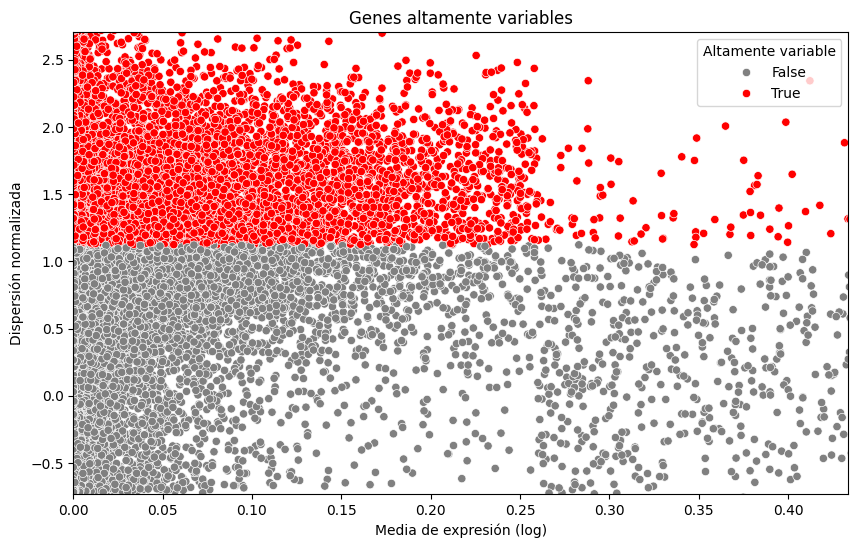

Número de genes altamente variables: 10000


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar los datos (asumiendo que ya tienes 'adata' cargado)

# Preprocesamiento para manejar valores infinitos y muy grandes
sc.pp.log1p(adata)  # Aplicar transformación logarítmica
adata.X = np.nan_to_num(adata.X, nan=0, posinf=0, neginf=0)  # Reemplazar inf y NaN con 0

# Calcular genes altamente variables
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat', n_bins=20)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=adata.var, x='means', y='dispersions_norm', 
                hue='highly_variable', palette={True: 'red', False: 'gray'})
plt.xlabel('Media de expresión (log)')
plt.ylabel('Dispersión normalizada')
plt.title('Genes altamente variables')
plt.legend(title='Altamente variable')

# Ajustar los límites del eje para excluir valores extremos
plt.xlim(adata.var['means'].quantile(0.01), adata.var['means'].quantile(0.99))
plt.ylim(adata.var['dispersions_norm'].quantile(0.01), adata.var['dispersions_norm'].quantile(0.99))

plt.show()

# Imprimir información sobre los genes altamente variables
n_hvg = adata.var['highly_variable'].sum()
print(f"Número de genes altamente variables: {n_hvg}")

Preprocesando datos...
Calculando con n_top_genes = 5000


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Calculando con n_top_genes = 7500


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Calculando con n_top_genes = 10000


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


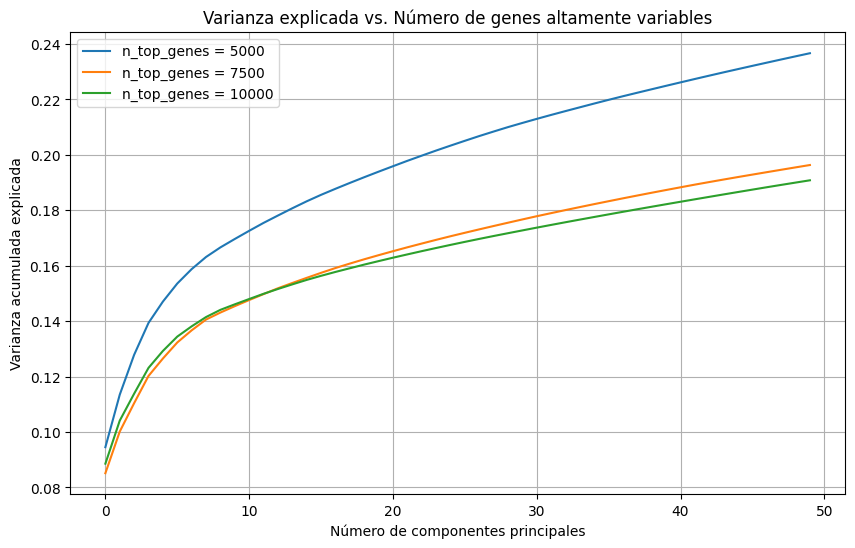


Para n_top_genes = 5000:
Varianza explicada por los primeros 10 PCs: 0.1696
Varianza explicada por los primeros 50 PCs: 0.2367

Para n_top_genes = 7500:
Varianza explicada por los primeros 10 PCs: 0.1454
Varianza explicada por los primeros 50 PCs: 0.1963

Para n_top_genes = 10000:
Varianza explicada por los primeros 10 PCs: 0.1461
Varianza explicada por los primeros 50 PCs: 0.1908


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que 'adata' ya está cargado

# Preprocesamiento para manejar valores infinitos y muy grandes
print("Preprocesando datos...")
sc.pp.log1p(adata)  # Aplicar transformación logarítmica
adata.X = np.nan_to_num(adata.X, nan=0, posinf=0, neginf=0)  # Reemplazar inf y NaN con 0

# Lista de valores de n_top_genes para probar
n_top_genes_list = [5000, 7500, 10000]

results = {}

for n_top in n_top_genes_list:
    print(f"Calculando con n_top_genes = {n_top}")
    
    # Copia los datos para no modificar el original
    adata_copy = adata.copy()
    
    # Calcula genes altamente variables
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=n_top, flavor='seurat', n_bins=20)
    
    # Filtra para quedarte solo con los genes altamente variables
    adata_copy = adata_copy[:, adata_copy.var.highly_variable]
    
    # Realiza PCA
    sc.tl.pca(adata_copy)
    
    # Calcula la varianza explicada
    variance_ratio = adata_copy.uns['pca']['variance_ratio']
    cumulative_variance_ratio = variance_ratio.cumsum()
    
    # Guarda los resultados
    results[n_top] = cumulative_variance_ratio

# Grafica los resultados
plt.figure(figsize=(10, 6))
for n_top, cumulative_variance in results.items():
    plt.plot(cumulative_variance[:50], label=f'n_top_genes = {n_top}')

plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza explicada vs. Número de genes altamente variables')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir información adicional
for n_top, cumulative_variance in results.items():
    print(f"\nPara n_top_genes = {n_top}:")
    print(f"Varianza explicada por los primeros 10 PCs: {cumulative_variance[9]:.4f}")
    print(f"Varianza explicada por los primeros 50 PCs: {cumulative_variance[49]:.4f}")